# Projet : Construire un modèle de scoring

---------

## Notebook exploration & feature engineering

Le projet vise à construire un outil de scoring crédit pour la société "Prêt à dépenser", capable d’estimer la probabilité de remboursement d’un emprunteur et de classifier chaque demande en « accordé » ou « refusé ».

Le travail se décompose en deux Jupyter Notebooks :

- **Exploration & feature engineering** : chargement du fichier `application_train.csv`, nettoyage, analyse des valeurs manquantes et extrêmes, création d’au moins trois nouvelles variables pertinentes (en rapport à celle existante), documentation détaillée. + comparaison avec `application_test.csv`
    
- **Modélisation & interprétabilité** : construction d’un pipeline scikit-learn, comparaison d’une régression logistique simple et d’un modèle plus complexe, gestion du déséquilibre (resampling ou poids de classes), optimisation des hyperparamètres via GridSearchCV, évaluation avec AUC, accuracy et un score métier intégrant un coût asymétrique des faux négatifs et positifs (FN et FP), analyse de l’importance globale des variables et explications locales avec SHAP.



---

Les données sont fournies par la société **Prêt à dépenser**.

Il y a **7 sources de données** différentes :

1.  **application_train / application_test** : Données principales d'entraînement et de test, contenant des informations sur chaque demande de prêt. Chaque ligne représente un prêt, identifié par la colonne `SK_ID_CURR`. Dans `application_train`, la colonne `TARGET` indique si le prêt a été remboursé (`0`) ou non (`1`).
    
2.  **bureau** : Informations sur les crédits antérieurs du client auprès d'autres institutions financières. Chaque ligne correspond à un ancien crédit. Un prêt dans les données principales peut être lié à plusieurs crédits précédents.
    
3.  **bureau_balance** : Données mensuelles liées aux anciens crédits présents dans `bureau`. Chaque ligne représente un mois d'un ancien crédit, donc un crédit peut avoir plusieurs lignes.
    
4.  **previous_application** : Historique des précédentes demandes de prêt du client chez "Prêt à dépenser". Chaque ligne correspond à une ancienne demande, identifiée par `SK_ID_PREV`. Un prêt actuel peut être lié à plusieurs demandes passées.
    
5.  **POS_CASH_BALANCE** : Données mensuelles sur les prêts de type point de vente ou espèces. Chaque ligne représente un mois d'un prêt de ce type. Un prêt peut avoir plusieurs lignes.
    
6.  **credit_card_balance** : Données mensuelles sur les cartes de crédit précédemment utilisées par le client chez "Prêt à dépenser". Chaque ligne correspond à un mois de relevé.
    
7.  **installments_payment** : Historique des paiements effectués (ou manqués) pour les prêts antérieurs. Une ligne par paiement effectué ou manqué.

Ce diagramme montre comment toutes les données sont liées :

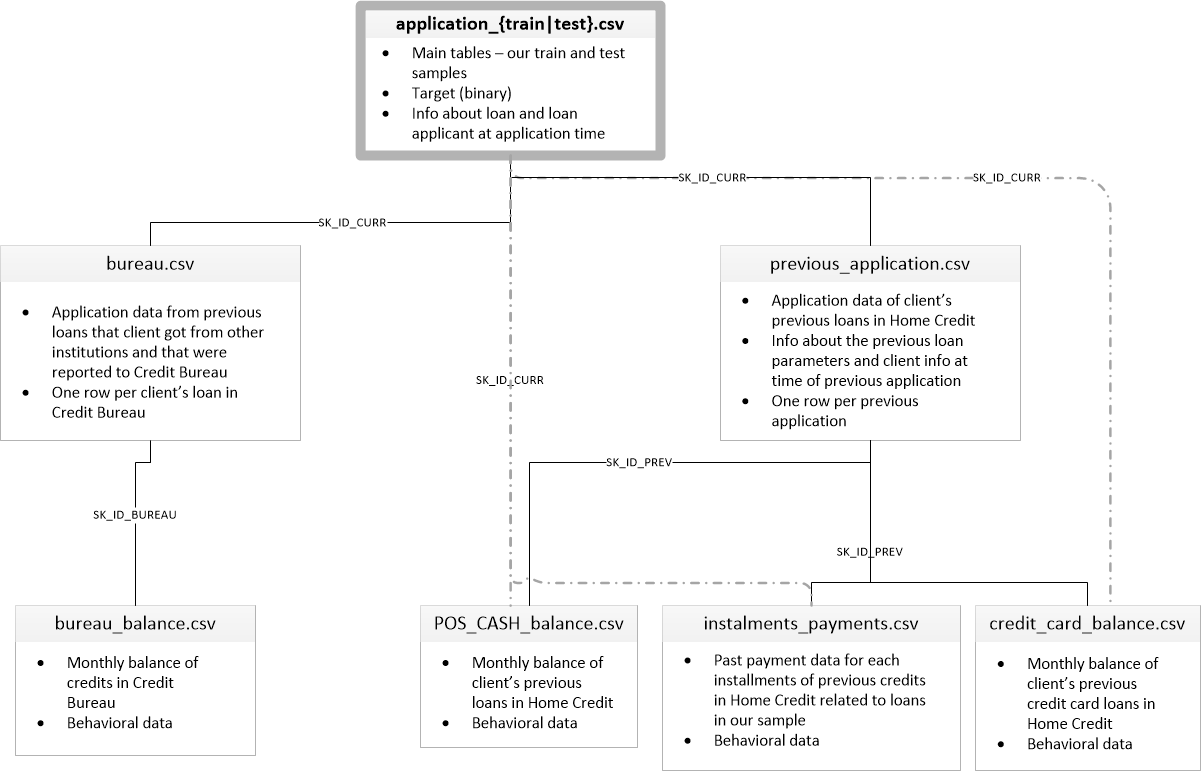

En complément, un fichier (`HomeCredit_columns_description.csv`) est fourni pour expliquer la signification de chaque colonne, ainsi qu’un exemple de fichier de soumission attendu.

---

In [4]:
# Nous chargeons les bibliothèques nécessaires pour la manipulation des données, la visualisation et le prétraitement.
import numpy as np
import pandas as pd 

# Scikit-learn pour l’encodage et l’imputation
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Gestion du système de fichiers et suppression d’avertissements inutiles
import os
import warnings
warnings.filterwarnings('ignore')

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno


Nous mettons en place l’environnement en chargeant toutes les dépendances dont nous aurons besoin pour explorer, nettoyer et visualiser nos données.

In [5]:
# Chargement du jeu de test
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

Testing data shape:  (48744, 121)


SK_ID_CURR NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      100001         Cash loans           F            N               Y   
1      100005         Cash loans           M            N               Y   
2      100013         Cash loans           M            Y               Y   
3      100028         Cash loans           F            N               Y   
4      100038         Cash loans           M            Y               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          135000.0    568800.0      20560.5         450000.0   
1             0           99000.0    222768.0      17370.0         180000.0   
2             0          202500.0    663264.0      69777.0         630000.0   
3             2          315000.0   1575000.0      49018.5        1575000.0   
4             1          180000.0    625500.0      32067.0         625500.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         NaN                        NaN   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         0.0  
1                        0.0                         3.0  
2                        1.0                         4.0  
3                        0.0                         3.0  
4                        NaN                         NaN  

[5 rows x 121 columns]

Nous commençons par importer le jeu de test pour prendre la mesure de sa structure et vérifier le nombre de variables disponibles.

---

In [6]:
# Chargement du jeu d’entraînement
app_train = pd.read_csv('application_train.csv', sep=',')

In [7]:
# Taille du DataFrame
def datacheck(data):
    shape = data.shape
    print(f"Il y a {shape[0]} lignes et {shape[1]} colonnes\n")
    
datacheck(app_train)

Il y a 307511 lignes et 122 colonnes



In [8]:
app_train.head(8)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   
5      100008       0         Cash loans           M            N   
6      100009       0         Cash loans           F            Y   
7      100010       0         Cash loans           M            Y   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   
5               Y             0           99000.0    490495.5      27517.5   
6               Y             1          171000.0   1560726.0      41301.0   
7               Y             0          360000.0   1530000.0      42075.0   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                 0                0                0                0   
1  ...                 0                0                0                0   
2  ...                 0                0                0                0   
3  ...                 0                0                0                0   
4  ...                 0                0                0                0   
5  ...                 0                0                0                0   
6  ...                 0                0                0                0   
7  ...                 0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        0.0                       0.0   
3                        NaN                       NaN   
4                        0.0                       0.0   
5                        0.0                       0.0   
6                        0.0                       0.0   
7                        0.0                       0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         NaN                        NaN   
4                         0.0                        0.0   
5                         0.0                        0.0   
6                         0.0                        1.0   
7                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         0.0  
2                        0.0                         0.0  
3                        NaN                         NaN  
4                        0.0                         0.0  
5                        1.0                         1.0  
6                        1.0                         2.0  
7                        0.0                         0.0  

[8 rows x 122 columns]

De même, nous chargeons le jeu d’entraînement et inspectons ses premières lignes ainsi que sa taille.

---

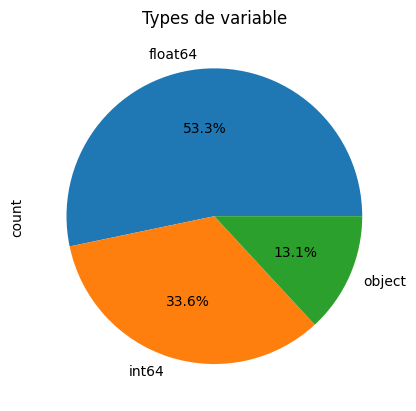

In [9]:
# Répartition des types de variables
app_train.dtypes.value_counts().plot.pie(autopct='%1.1f%%', title='Types de variable')
plt.show()

Types de variables :


float64    65
int64      41
object     16
Name: count, dtype: int64


Taux de défaut (TARGET) :


TARGET
0    282686
1     24825
Name: count, dtype: int64


Modalités par variable catégorielle :
NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
HOUSETYPE_MODE                 3
CODE_GENDER                    3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
NAME_TYPE_SUITE                7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64


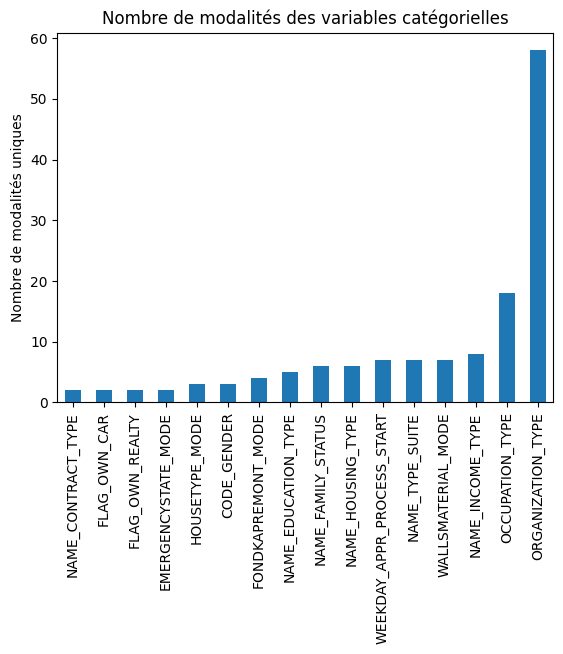

In [10]:
# Comptage de la cible et cardinalité des catégorielles
print("Types de variables :")
display(app_train.dtypes.value_counts())

print("\nTaux de défaut (TARGET) :")
display(app_train['TARGET'].value_counts(normalize=False))

print("\nModalités par variable catégorielle :")
print(app_train.select_dtypes('object').nunique().sort_values())

categorical = app_train.select_dtypes('object')
categorical.nunique().sort_values().plot.bar(title="Nombre de modalités des variables catégorielles")
plt.ylabel("Nombre de modalités uniques")
plt.show()


Ici, nous visualisons la composition du dataset : proportion de variables numériques vs catégorielles, déséquilibre de la cible et nombre de modalités par variable.

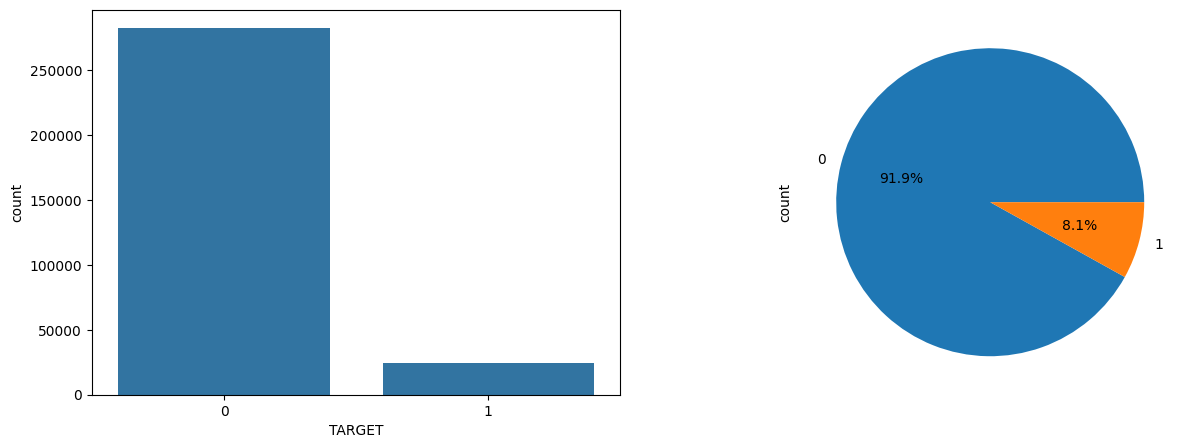


Taux de défaut (TARGET) :


TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

In [11]:
# Visualisation du déséquilibre
count = app_train['TARGET'].value_counts()
pct   = app_train['TARGET'].value_counts(normalize=True)*100

fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x='TARGET', data=app_train, ax=ax[0])
app_train['TARGET'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[1])
plt.show()

print("\nTaux de défaut (TARGET) :")
display(app_train['TARGET'].value_counts(normalize=True))

Nous confirmons le fort déséquilibre dans nos données — un point crucial pour la suite (gestion des poids ou du sur‑échantillonnage). (≈ 92% de remboursements, 8% de défauts).

---

In [12]:
# Fonctions pour lister les NaN
def missing_values_table(df):
    mis = df.isnull().sum()
    pct = 100 * mis / len(df)
    tab = pd.concat([mis, pct], axis=1)
    tab.columns = ['Missing','%']
    tab = tab[tab['Missing']>0].sort_values('%',ascending=False)
    print(f"Colonnes totales: {df.shape[1]}, avec NaN: {tab.shape[0]}")
    return tab

miss_tab = missing_values_table(app_train)
miss_tab.head(60)

Colonnes totales: 122, avec NaN: 67


Missing          %
COMMONAREA_MEDI                214865  69.872297
COMMONAREA_MODE                214865  69.872297
COMMONAREA_AVG                 214865  69.872297
NONLIVINGAPARTMENTS_MODE       213514  69.432963
NONLIVINGAPARTMENTS_MEDI       213514  69.432963
NONLIVINGAPARTMENTS_AVG        213514  69.432963
FONDKAPREMONT_MODE             210295  68.386172
LIVINGAPARTMENTS_AVG           210199  68.354953
LIVINGAPARTMENTS_MEDI          210199  68.354953
LIVINGAPARTMENTS_MODE          210199  68.354953
FLOORSMIN_MEDI                 208642  67.848630
FLOORSMIN_MODE                 208642  67.848630
FLOORSMIN_AVG                  208642  67.848630
YEARS_BUILD_MODE               204488  66.497784
YEARS_BUILD_MEDI               204488  66.497784
YEARS_BUILD_AVG                204488  66.497784
OWN_CAR_AGE                    202929  65.990810
LANDAREA_AVG                   182590  59.376738
LANDAREA_MEDI                  182590  59.376738
LANDAREA_MODE                  182590  59.376738
BASEMENTAREA_MODE              179943  58.515956
BASEMENTAREA_MEDI              179943  58.515956
BASEMENTAREA_AVG               179943  58.515956
EXT_SOURCE_1                   173378  56.381073
NONLIVINGAREA_MEDI             169682  55.179164
NONLIVINGAREA_AVG              169682  55.179164
NONLIVINGAREA_MODE             169682  55.179164
ELEVATORS_MEDI                 163891  53.295980
ELEVATORS_MODE                 163891  53.295980
ELEVATORS_AVG                  163891  53.295980
WALLSMATERIAL_MODE             156341  50.840783
APARTMENTS_AVG                 156061  50.749729
APARTMENTS_MEDI                156061  50.749729
APARTMENTS_MODE                156061  50.749729
ENTRANCES_MODE                 154828  50.348768
ENTRANCES_MEDI                 154828  50.348768
ENTRANCES_AVG                  154828  50.348768
LIVINGAREA_AVG                 154350  50.193326
LIVINGAREA_MODE                154350  50.193326
LIVINGAREA_MEDI                154350  50.193326
HOUSETYPE_MODE                 154297  50.176091
FLOORSMAX_AVG                  153020  49.760822
FLOORSMAX_MEDI                 153020  49.760822
FLOORSMAX_MODE                 153020  49.760822
YEARS_BEGINEXPLUATATION_MODE   150007  48.781019
YEARS_BEGINEXPLUATATION_MEDI   150007  48.781019
YEARS_BEGINEXPLUATATION_AVG    150007  48.781019
TOTALAREA_MODE                 148431  48.268517
EMERGENCYSTATE_MODE            145755  47.398304
OCCUPATION_TYPE                 96391  31.345545
EXT_SOURCE_3                    60965  19.825307
AMT_REQ_CREDIT_BUREAU_WEEK      41519  13.501631
AMT_REQ_CREDIT_BUREAU_MON       41519  13.501631
AMT_REQ_CREDIT_BUREAU_HOUR      41519  13.501631
AMT_REQ_CREDIT_BUREAU_YEAR      41519  13.501631
AMT_REQ_CREDIT_BUREAU_QRT       41519  13.501631
AMT_REQ_CREDIT_BUREAU_DAY       41519  13.501631
NAME_TYPE_SUITE                  1292   0.420148
DEF_30_CNT_SOCIAL_CIRCLE         1021   0.332021
DEF_60_CNT_SOCIAL_CIRCLE         1021   0.332021

Nous listons les colonnes les plus affectées par les NaN.

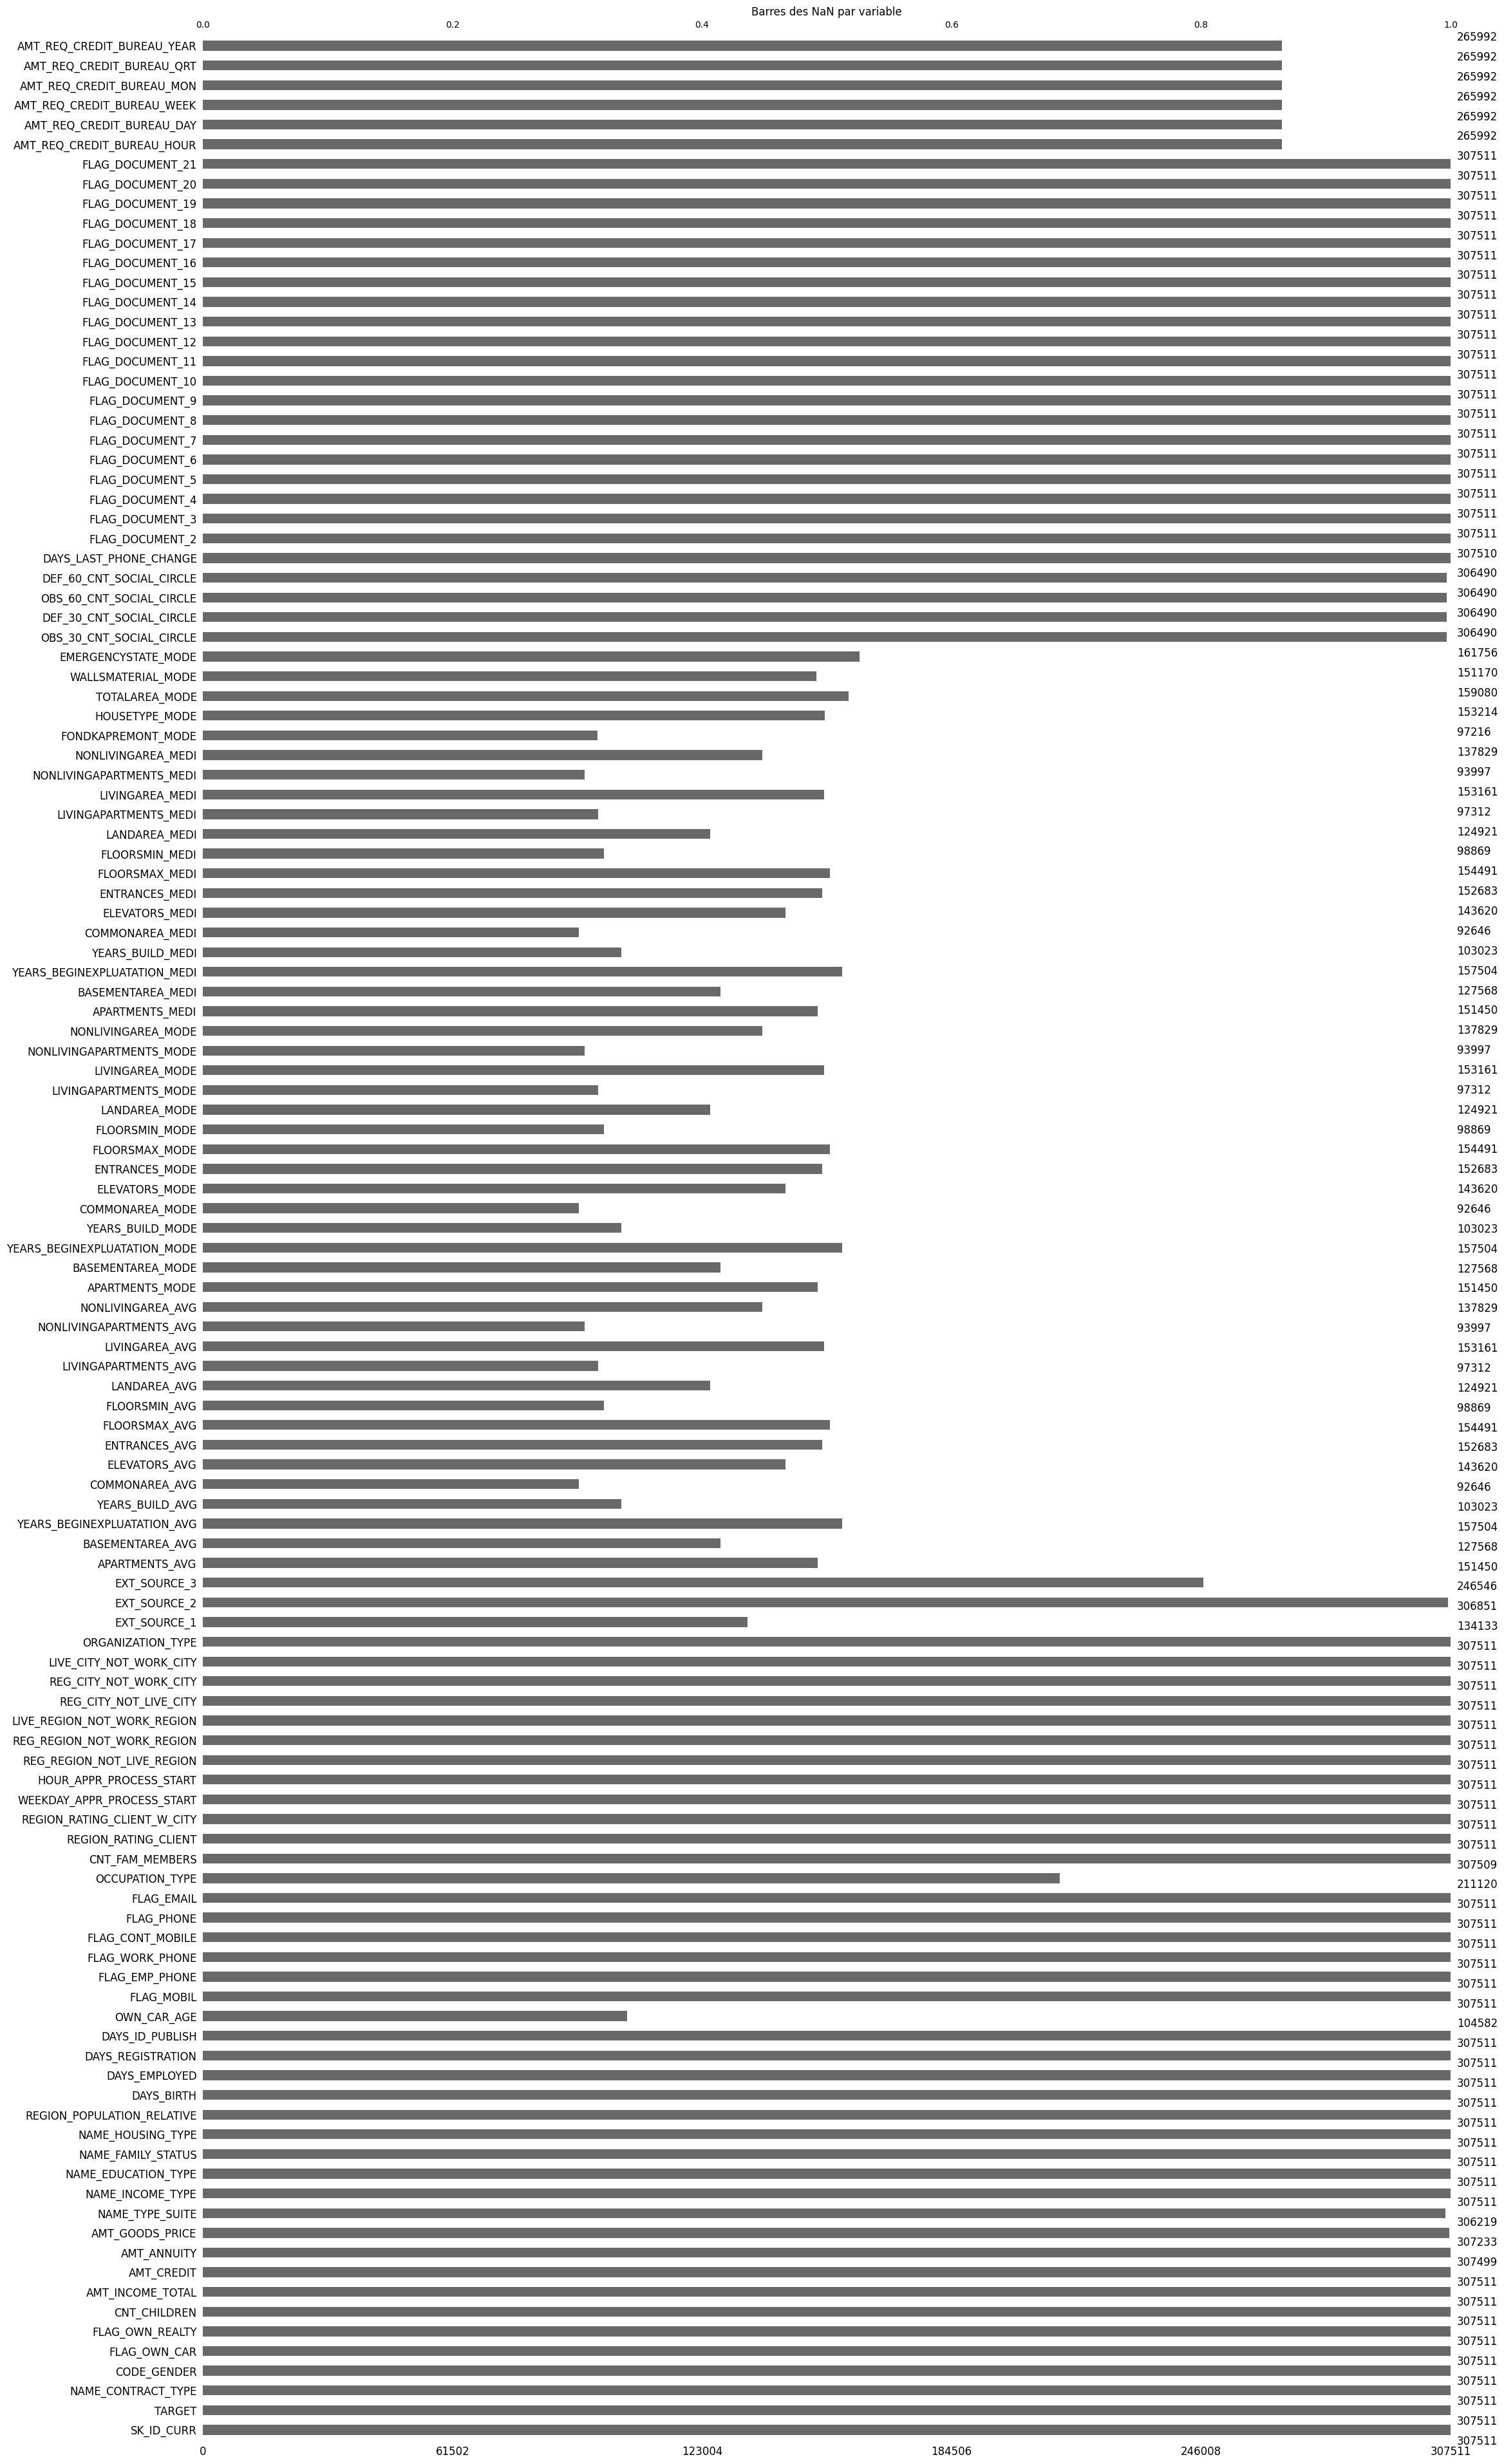

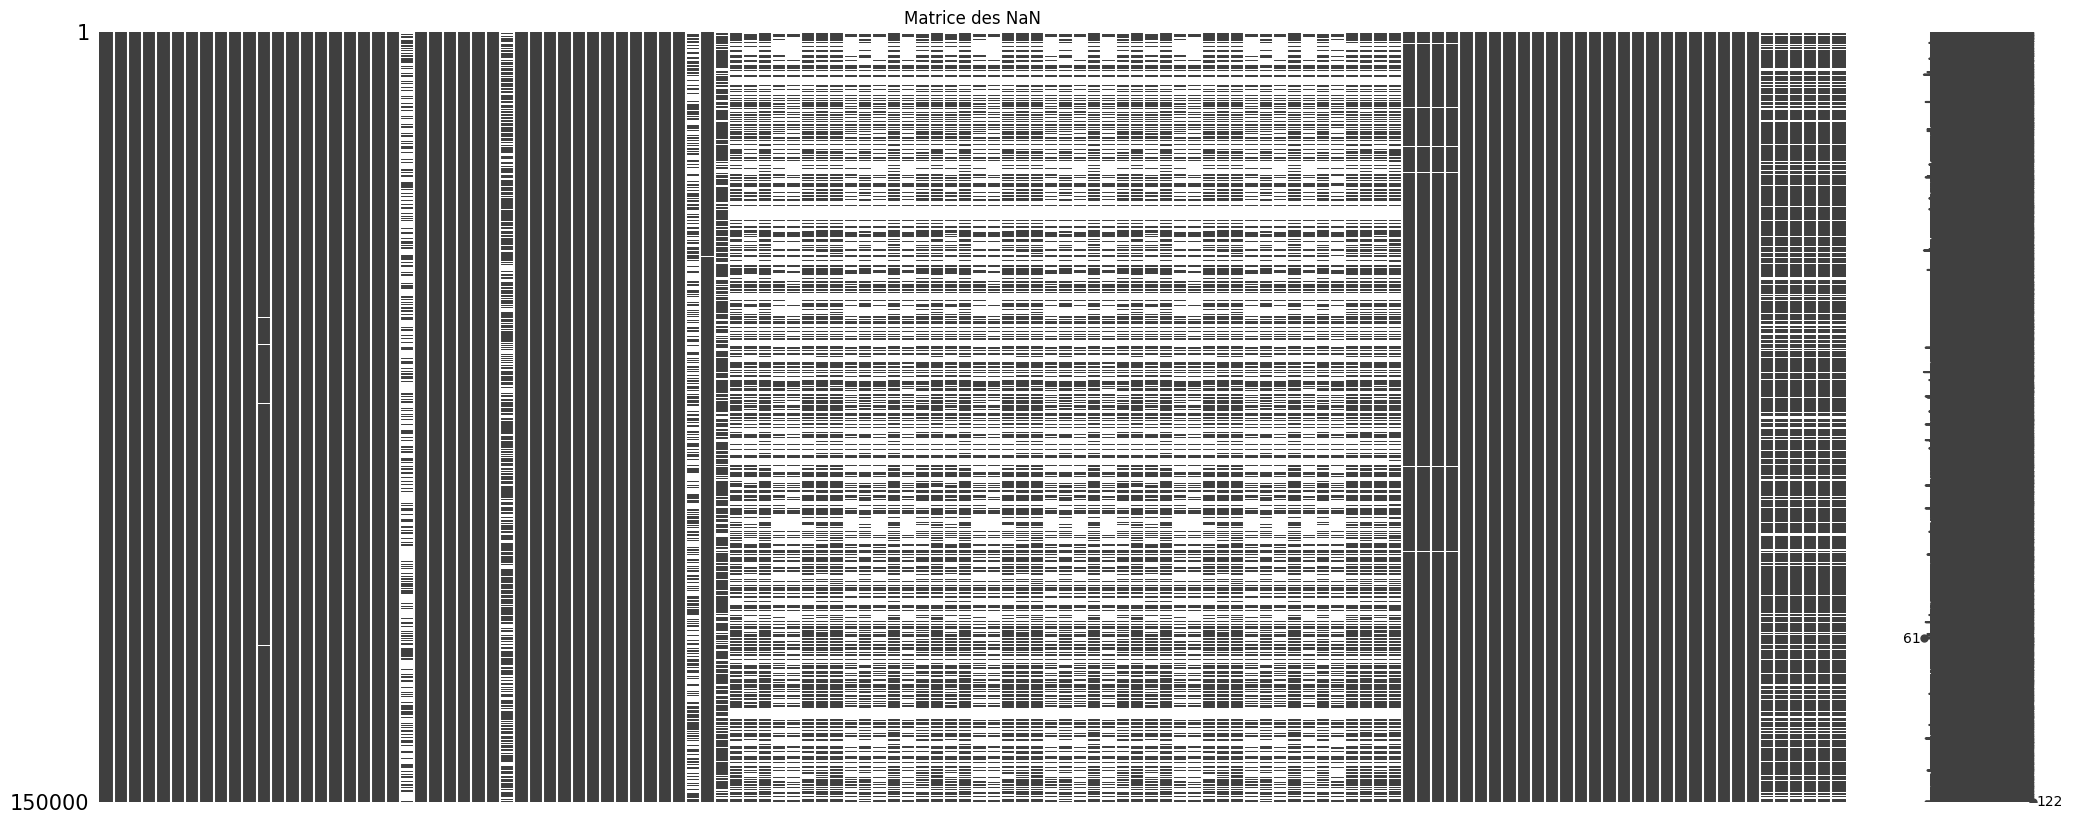

In [13]:
# Visualisations des patterns de manquants
msno.bar(app_train, fontsize=12)
plt.title("Barres des NaN par variable")
plt.show()

msno.matrix(app_train.sample(150000), fontsize=12)
plt.title("Matrice des NaN")
plt.show()

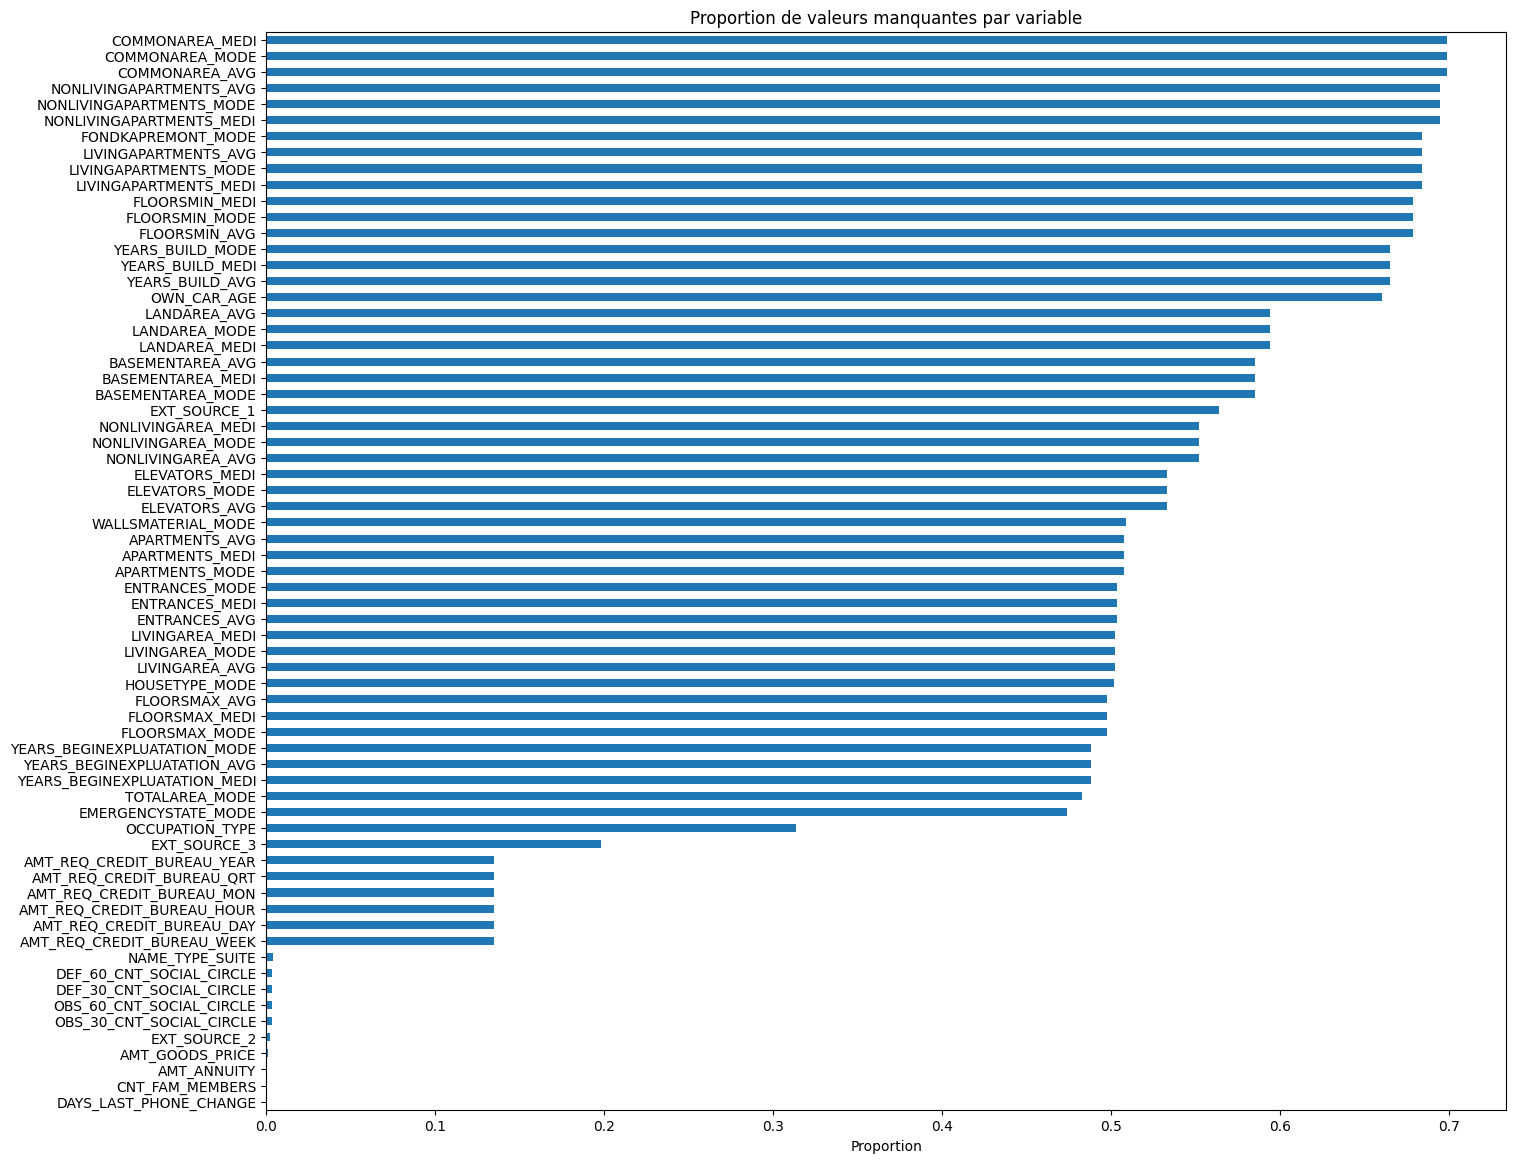

In [14]:
missing = app_train.isnull().mean().sort_values(ascending=True)
missing = missing[missing > 0]

plt.figure(figsize=(16,14))
missing.plot.barh(title='Proportion de valeurs manquantes par variable')
plt.xlabel("Proportion")
plt.show()


Nous quantifions et visualisons les valeurs manquantes à l'aide de Missigno principalement.

---

In [15]:
# Statistiques descriptives avec percentiles extrêmes
desc = app_train.describe(percentiles=[0.01,0.25,0.5,0.75,0.99]).T
display(desc[['min','1%','25%','50%','75%','99%','max']].head(50))

min             1%            25%  \
SK_ID_CURR                    1.000020e+05  103590.200000  189145.500000   
TARGET                        0.000000e+00       0.000000       0.000000   
CNT_CHILDREN                  0.000000e+00       0.000000       0.000000   
AMT_INCOME_TOTAL              2.565000e+04   45000.000000  112500.000000   
AMT_CREDIT                    4.500000e+04   76410.000000  270000.000000   
AMT_ANNUITY                   1.615500e+03    6182.910000   16524.000000   
AMT_GOODS_PRICE               4.050000e+04   67500.000000  238500.000000   
REGION_POPULATION_RELATIVE    2.900000e-04       0.002134       0.010006   
DAYS_BIRTH                   -2.522900e+04  -24419.000000  -19682.000000   
DAYS_EMPLOYED                -1.791200e+04  -10894.900000   -2760.000000   
DAYS_REGISTRATION            -2.467200e+04  -13879.000000   -7479.500000   
DAYS_ID_PUBLISH              -7.197000e+03   -5447.000000   -4299.000000   
OWN_CAR_AGE                   0.000000e+00       0.000000       5.000000   
FLAG_MOBIL                    0.000000e+00       1.000000       1.000000   
FLAG_EMP_PHONE                0.000000e+00       0.000000       1.000000   
FLAG_WORK_PHONE               0.000000e+00       0.000000       0.000000   
FLAG_CONT_MOBILE              0.000000e+00       1.000000       1.000000   
FLAG_PHONE                    0.000000e+00       0.000000       0.000000   
FLAG_EMAIL                    0.000000e+00       0.000000       0.000000   
CNT_FAM_MEMBERS               1.000000e+00       1.000000       2.000000   
REGION_RATING_CLIENT          1.000000e+00       1.000000       2.000000   
REGION_RATING_CLIENT_W_CITY   1.000000e+00       1.000000       2.000000   
HOUR_APPR_PROCESS_START       0.000000e+00       4.000000      10.000000   
REG_REGION_NOT_LIVE_REGION    0.000000e+00       0.000000       0.000000   
REG_REGION_NOT_WORK_REGION    0.000000e+00       0.000000       0.000000   
LIVE_REGION_NOT_WORK_REGION   0.000000e+00       0.000000       0.000000   
REG_CITY_NOT_LIVE_CITY        0.000000e+00       0.000000       0.000000   
REG_CITY_NOT_WORK_CITY        0.000000e+00       0.000000       0.000000   
LIVE_CITY_NOT_WORK_CITY       0.000000e+00       0.000000       0.000000   
EXT_SOURCE_1                  1.456813e-02       0.084257       0.334007   
EXT_SOURCE_2                  8.173617e-08       0.029477       0.392457   
EXT_SOURCE_3                  5.272652e-04       0.064672       0.370650   
APARTMENTS_AVG                0.000000e+00       0.002100       0.057700   
BASEMENTAREA_AVG              0.000000e+00       0.000000       0.044200   
YEARS_BEGINEXPLUATATION_AVG   0.000000e+00       0.948800       0.976700   
YEARS_BUILD_AVG               0.000000e+00       0.347200       0.687200   
COMMONAREA_AVG                0.000000e+00       0.000000       0.007800   
ELEVATORS_AVG                 0.000000e+00       0.000000       0.000000   
ENTRANCES_AVG                 0.000000e+00       0.034500       0.069000   
FLOORSMAX_AVG                 0.000000e+00       0.000000       0.166700   
FLOORSMIN_AVG                 0.000000e+00       0.000000       0.083300   
LANDAREA_AVG                  0.000000e+00       0.000000       0.018700   
LIVINGAPARTMENTS_AVG          0.000000e+00       0.003400       0.050400   
LIVINGAREA_AVG                0.000000e+00       0.002200       0.045300   
NONLIVINGAPARTMENTS_AVG       0.000000e+00       0.000000       0.000000   
NONLIVINGAREA_AVG             0.000000e+00       0.000000       0.000000   
APARTMENTS_MODE               0.000000e+00       0.002100       0.052500   
BASEMENTAREA_MODE             0.000000e+00       0.000000       0.040700   
YEARS_BEGINEXPLUATATION_MODE  0.000000e+00       0.948900       0.976700   
YEARS_BUILD_MODE              0.000000e+00       0.366200       0.699400   

                                        50%            75%           99%  \
SK_ID_CURR                    278202.000000  367142.500000  4.527129e+05   
TARGET    

Nous analysons les bornes extrêmes de nos variables pour détecter d’éventuelles anomalies ou valeurs aberrantes.

---

##### Information sur les valeurs uniques :

Informations sur les variables OBJECT :

In [16]:
# Statistiques descriptives et nombre de modalités des variables object
data_object_infos = app_train.select_dtypes("object").describe().T
data_object_infos["unique_values"] = app_train.select_dtypes("object").apply(pd.Series.unique, axis=0)
data_object_infos["n_unique"]      = app_train.select_dtypes("object").nunique()
display(data_object_infos)

count unique                            top  \
NAME_CONTRACT_TYPE          307511      2                     Cash loans   
CODE_GENDER                 307511      3                              F   
FLAG_OWN_CAR                307511      2                              N   
FLAG_OWN_REALTY             307511      2                              Y   
NAME_TYPE_SUITE             306219      7                  Unaccompanied   
NAME_INCOME_TYPE            307511      8                        Working   
NAME_EDUCATION_TYPE         307511      5  Secondary / secondary special   
NAME_FAMILY_STATUS          307511      6                        Married   
NAME_HOUSING_TYPE           307511      6              House / apartment   
OCCUPATION_TYPE             211120     18                       Laborers   
WEEKDAY_APPR_PROCESS_START  307511      7                        TUESDAY   
ORGANIZATION_TYPE           307511     58         Business Entity Type 3   
FONDKAPREMONT_MODE           97216      4               reg oper account   
HOUSETYPE_MODE              153214      3                 block of flats   
WALLSMATERIAL_MODE          151170      7                          Panel   
EMERGENCYSTATE_MODE         161756      2                             No   

                              freq  \
NAME_CONTRACT_TYPE          278232   
CODE_GENDER                 202448   
FLAG_OWN_CAR                202924   
FLAG_OWN_REALTY             213312   
NAME_TYPE_SUITE             248526   
NAME_INCOME_TYPE            158774   
NAME_EDUCATION_TYPE         218391   
NAME_FAMILY_STATUS          196432   
NAME_HOUSING_TYPE           272868   
OCCUPATION_TYPE              55186   
WEEKDAY_APPR_PROCESS_START   53901   
ORGANIZATION_TYPE            67992   
FONDKAPREMONT_MODE           73830   
HOUSETYPE_MODE              150503   
WALLSMATERIAL_MODE           66040   
EMERGENCYSTATE_MODE         159428   

                                                                unique_values  \
NAME_CONTRACT_TYPE                              [Cash loans, Revolving loans]   
CODE_GENDER                                                       [M, F, XNA]   
FLAG_OWN_CAR                                                           [N, Y]   
FLAG_OWN_REALTY                                                        [Y, N]   
NAME_TYPE_SUITE             [Unaccompanied, Family, Spouse, partner, Child...   
NAME_INCOME_TYPE            [Working, State servant, Commercial associate,...   
NAME_EDUCATION_TYPE         [Secondary / secondary special, Higher educati...   
NAME_FAMILY_STATUS          [Single / not married, Married, Civil marriage...   
NAME_HOUSING_TYPE           [House / apartment, Rented apartment, With par...   
OCCUPATION_TYPE             [Laborers, Core staff, Accountants, Managers, ...   
WEEKDAY_APPR_PROCESS_START  [WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY...   
ORGANIZATION_TYPE           [Business Entity Type 3, School, Government, R...   
FONDKAPREMONT_MODE          [reg oper account, nan, org spec account, reg ...   
HOUSETYPE_MODE              [block of flats, nan, terraced house, specific...   
WALLSMATERIAL_MODE          [Stone, brick, Block, nan, Panel, Mixed, Woode...   
EMERGENCYSTATE_MODE                                            [No, nan, Yes]   

                            n_unique  
NAME_CONTRACT_TYPE                 2  
CODE_GENDER                        3  
FLAG_OWN_CAR                       2  
FLAG_OWN_REALTY                    2  
NAME_TYPE_SUITE                    7  
NAME_INCOME_TYPE                   8  
NAME_EDUCATION_TYPE                5  
NAME_FAMILY_STATUS                 6  
NAME_HOUSING_TYPE                  6  
OCCUPATION_TYPE                   18  
WEEKDAY_APPR_PROCESS_START         7  
ORGANIZATION_TYPE                 58  
FONDKAPREMONT_MODE                 4  
HOUSETYPE_MODE                     3  
WALLSMATERIAL_MODE                 7  
EMERGENCYSTATE_MODE                2

Nous listons pour chaque variable catégorielle ses modalités et leur nombre afin de préparer l’encodage. 

Informations sur les variables INT :

In [17]:
# Nombre de valeurs uniques et aperçu des modalités pour les variables int64
data_int_infos = pd.DataFrame(
    app_train.select_dtypes("int64").nunique(), 
    columns=["n_unique"]
)
data_int_infos["unique_values"] = app_train.select_dtypes("int64").apply(pd.Series.unique, axis=0)
display(data_int_infos.sort_values("n_unique"))

n_unique  \
TARGET                              2   
FLAG_EMP_PHONE                      2   
FLAG_MOBIL                          2   
REG_REGION_NOT_LIVE_REGION          2   
FLAG_EMAIL                          2   
FLAG_PHONE                          2   
FLAG_CONT_MOBILE                    2   
FLAG_WORK_PHONE                     2   
FLAG_DOCUMENT_4                     2   
FLAG_DOCUMENT_3                     2   
FLAG_DOCUMENT_2                     2   
LIVE_CITY_NOT_WORK_CITY             2   
REG_CITY_NOT_WORK_CITY              2   
REG_CITY_NOT_LIVE_CITY              2   
LIVE_REGION_NOT_WORK_REGION         2   
REG_REGION_NOT_WORK_REGION          2   
FLAG_DOCUMENT_5                     2   
FLAG_DOCUMENT_6                     2   
FLAG_DOCUMENT_7                     2   
FLAG_DOCUMENT_8                     2   
FLAG_DOCUMENT_9                     2   
FLAG_DOCUMENT_10                    2   
FLAG_DOCUMENT_11                    2   
FLAG_DOCUMENT_12                    2   
FLAG_DOCUMENT_20                    2   
FLAG_DOCUMENT_19                    2   
FLAG_DOCUMENT_18                    2   
FLAG_DOCUMENT_17                    2   
FLAG_DOCUMENT_16                    2   
FLAG_DOCUMENT_15                    2   
FLAG_DOCUMENT_14                    2   
FLAG_DOCUMENT_13                    2   
FLAG_DOCUMENT_21                    2   
REGION_RATING_CLIENT                3   
REGION_RATING_CLIENT_W_CITY         3   
CNT_CHILDREN                       15   
HOUR_APPR_PROCESS_START            24   
DAYS_ID_PUBLISH                  6168   
DAYS_EMPLOYED                   12574   
DAYS_BIRTH                      17460   
SK_ID_CURR                     307511   

                                                                 unique_values  
TARGET                                                                  [1, 0]  
FLAG_EMP_PHONE                                                          [1, 0]  
FLAG_MOBIL                                                              [1, 0]  
REG_REGION_NOT_LIVE_REGION                                              [0, 1]  
FLAG_EMAIL                                                              [0, 1]  
FLAG_PHONE                                                              [1, 0]  
FLAG_CONT_MOBILE                                                        [1, 0]  
FLAG_WORK_PHONE                                                         [0, 1]  
FLAG_DOCUMENT_4                                                         [0, 1]  
FLAG_DOCUMENT_3                                                         [1, 0]  
FLAG_DOCUMENT_2                                                         [0, 1]  
LIVE_CITY_NOT_WORK_CITY                                                 [0, 1]  
REG_CITY_NOT_WORK_CITY                                                  [0, 1]  
REG_CITY_NOT_LIVE_CITY                                                  [0, 1]  
LIVE_REGION_NOT_WORK_REGION                                             [0, 1]  
REG_REGION_NOT_WORK_REGION                                              [0, 1]  
FLAG_DOCUMENT_5                                                         [0, 1]  
FLAG_DOCUMENT_6                                                         [0, 1]  
FLAG_DOCUMENT_7                                                         [0, 1]  
FLAG_DOCUMENT_8                                                         [0, 1]  
FLAG_DOCUMENT_9                                                         [0, 1]  
FLAG_DOCUMENT_10                                                        [0, 1]  
FLAG_DOCUMENT_11                                                        [0, 1]  
FLAG_DOCUMENT_12                                                        [0, 1]  
FLAG_DOCUMENT_20                                                        [0, 1]  
FLAG_DOCUMENT_19                                                        [0, 1]  
FLAG_DOCUMENT_18                                                        [0, 1]  
FLAG_DOCUMENT_17                      

Nous recensons pour chaque variable entière le nombre de valeurs distinctes et leurs modalités afin d’identifier celles qui pourront être directement utilisées ou nécessiter un regroupement. 

Informations sur les variables FLOAT :

In [18]:
# Nombre de valeurs uniques et aperçu des modalités pour les variables float
data_float_infos = pd.DataFrame(
    app_train.select_dtypes("float64").nunique(), 
    columns=["n_unique"]
)
data_float_infos["unique_values"] = app_train.select_dtypes("float64").apply(pd.Series.unique, axis=0)
display(data_float_infos.sort_values("n_unique"))

n_unique  \
AMT_REQ_CREDIT_BUREAU_HOUR         5   
DEF_60_CNT_SOCIAL_CIRCLE           9   
AMT_REQ_CREDIT_BUREAU_WEEK         9   
AMT_REQ_CREDIT_BUREAU_DAY          9   
DEF_30_CNT_SOCIAL_CIRCLE          10   
...                              ...   
AMT_CREDIT                      5603   
AMT_ANNUITY                    13672   
DAYS_REGISTRATION              15688   
EXT_SOURCE_1                  114584   
EXT_SOURCE_2                  119831   

                                                                unique_values  
AMT_REQ_CREDIT_BUREAU_HOUR                     [0.0, nan, 1.0, 2.0, 3.0, 4.0]  
DEF_60_CNT_SOCIAL_CIRCLE    [2.0, 0.0, 1.0, nan, 3.0, 5.0, 4.0, 7.0, 24.0,...  
AMT_REQ_CREDIT_BUREAU_WEEK  [0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 8.0, ...  
AMT_REQ_CREDIT_BUREAU_DAY   [0.0, nan, 1.0, 3.0, 2.0, 4.0, 5.0, 6.0, 9.0, ...  
DEF_30_CNT_SOCIAL_CIRCLE    [2.0, 0.0, 1.0, nan, 3.0, 4.0, 5.0, 6.0, 7.0, ...  
...                                                                       ...  
AMT_CREDIT                  [406597.5, 1293502.5, 135000.0, 312682.5, 5130...  
AMT_ANNUITY                 [24700.5, 35698.5, 6750.0, 29686.5, 21865.5, 2...  
DAYS_REGISTRATION           [-3648.0, -1186.0, -4260.0, -9833.0, -4311.0, ...  
EXT_SOURCE_1                [0.0830369673913225, 0.3112673113812225, nan, ...  
EXT_SOURCE_2                [0.2629485927471776, 0.6222457752555098, 0.555...  

[65 rows x 2 columns]

Nous évaluons la cardinalité et les valeurs distinctes des colonnes float pour décider d’éventuels regroupements ou transformations. 



---

#### Analyse exploratoire :

In [19]:
# Statistiques descriptives sur l’âge des clients (en années)
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Nous examinons la répartition de l’âge des clients pour avoir un aperçu de la population cible.

In [20]:
# Statistiques descriptives sur l'ancienneté professionnelle (en jours)
app_train['DAYS_EMPLOYED'].describe()


count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Nous analysons l’ancienneté professionnelle déclarée pour détecter d’éventuelles anomalies ou valeurs extrêmes.

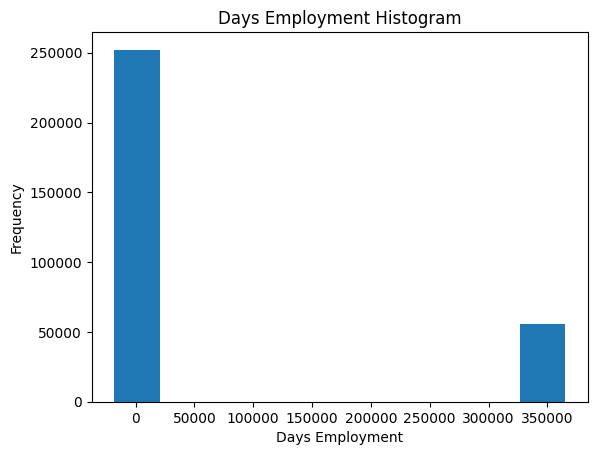

In [21]:
# Visualisation de la distribution de l'ancienneté professionnelle
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

Nous visualisons la distribution de l’ancienneté professionnelle afin d’identifier facilement les valeurs aberrantes.  

In [22]:
# Calcul du taux de défaut chez les anomalies et les non-anomalies
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Nous comparons le taux de défaut entre les dossiers normaux et ceux avec une valeur aberrante pour DAYS_EMPLOYED.

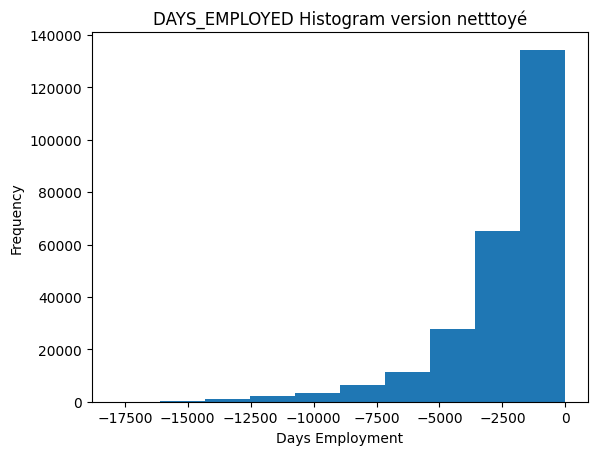

In [23]:
# Création d'un indicateur d'anomalie et remplacement de la valeur par NaN
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'DAYS_EMPLOYED Histogram version netttoyé');
plt.xlabel('Days Employment');

Nous ajoutons un indicateur d’anomalie, remplaçons la valeur extrême par NaN et vérifions la nouvelle distribution.

---

##### Correlations

Statut des corrélations -> plus mauvaise au plus forte !

- 00-.19 “very weak”
- 20-.39 “weak”
- 40-.59 “moderate”
- 60-.79 “strong”
- 80-1.0 “very strong”

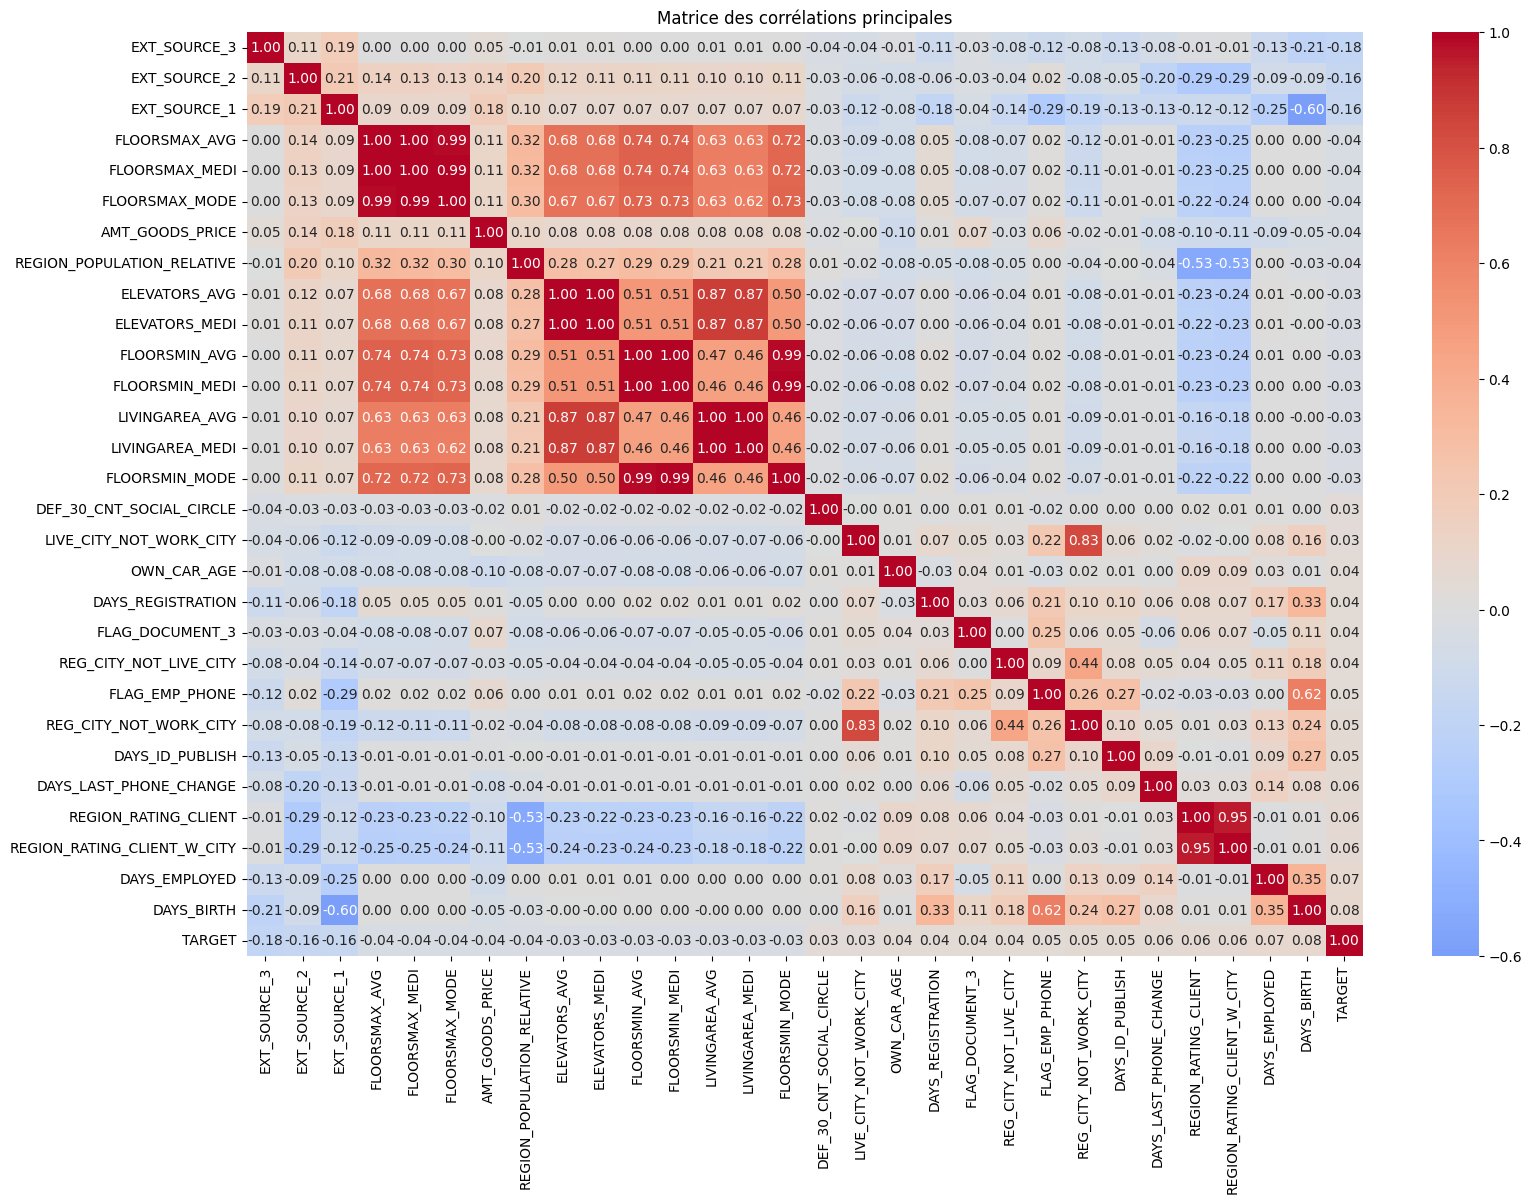

In [24]:
# Matrice de corrélation pour les principales variables numériques
numerics = app_train.select_dtypes(include=['int64', 'float64'])

corrs = numerics.corr()['TARGET'].sort_values()
top_corr_vars = corrs.head(15).index.tolist() + corrs.tail(15).index.tolist()

plt.figure(figsize=(18,12))
sns.heatmap(numerics[top_corr_vars].corr(), cmap='coolwarm', annot=True, fmt='.2f', center=0)
plt.title("Matrice des corrélations principales")
plt.show()

Nous visualisons les corrélations entre les variables numériques les plus corrélées avec la cible pour guider la sélection des features.

In [25]:
# Liste des variables les plus corrélées avec la cible
numeric_cols   = app_train.select_dtypes(include=['int64','float64'])
correlations   = numeric_cols.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(25))
print('\nMost Negative Correlations:\n', correlations.head(25))


Most Positive Correlations:
 FLAG_DOCUMENT_2                0.005417
REG_REGION_NOT_LIVE_REGION     0.005576
REG_REGION_NOT_WORK_REGION     0.006942
OBS_60_CNT_SOCIAL_CIRCLE       0.009022
OBS_30_CNT_SOCIAL_CIRCLE       0.009131
CNT_FAM_MEMBERS                0.009308
CNT_CHILDREN                   0.019187
AMT_REQ_CREDIT_BUREAU_YEAR     0.019930
FLAG_WORK_PHONE                0.028524
DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET     

Nous listons précisément les variables les plus positivement et négativement corrélées à TARGET.

---

Effet de l'âge sur le remboursement

In [26]:
# Trouve la corrélation entre les jours positifs depuis la naissance et la cible
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

np.float64(-0.07823930830982709)

On note une relation linéaire négative entre l’âge du client et la variable cible : plus le client vieillit, plus il rembourse ses prêts à temps.

Pour explorer cette variable, traçons d’abord un histogramme des âges, avec l’axe des abscisses en années pour plus de clarté.

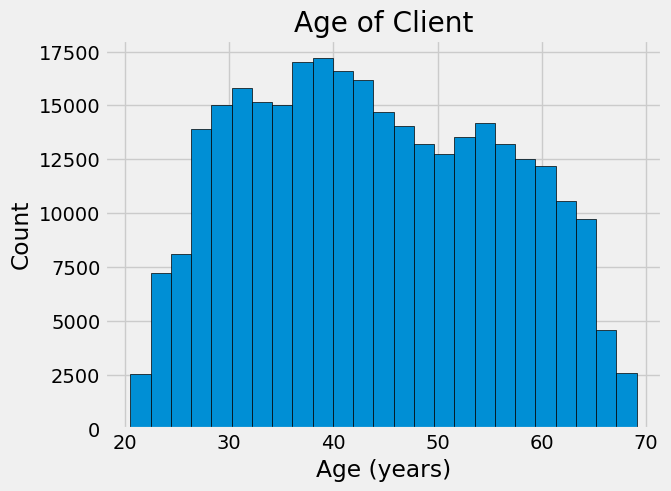

In [27]:
# Histogramme de l'âge des clients (en années)
plt.style.use('fivethirtyeight')

plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

Nous visualisons la répartition des âges pour détecter d’éventuelles valeurs aberrantes.

La distribution des âges n’apporte pas d’information majeure, si ce n’est l’absence de valeurs aberrantes. Pour étudier l’influence de l’âge sur la variable cible, nous allons tracer une estimation de densité à noyau (KDE) colorée selon cette cible. 

Le KDE équivaut à un histogramme lissé : on place un noyau gaussien sur chaque donnée, puis on moyenne ces noyaux pour obtenir une courbe continue. Nous utiliserons pour cela la fonction kdeplot de Seaborn.

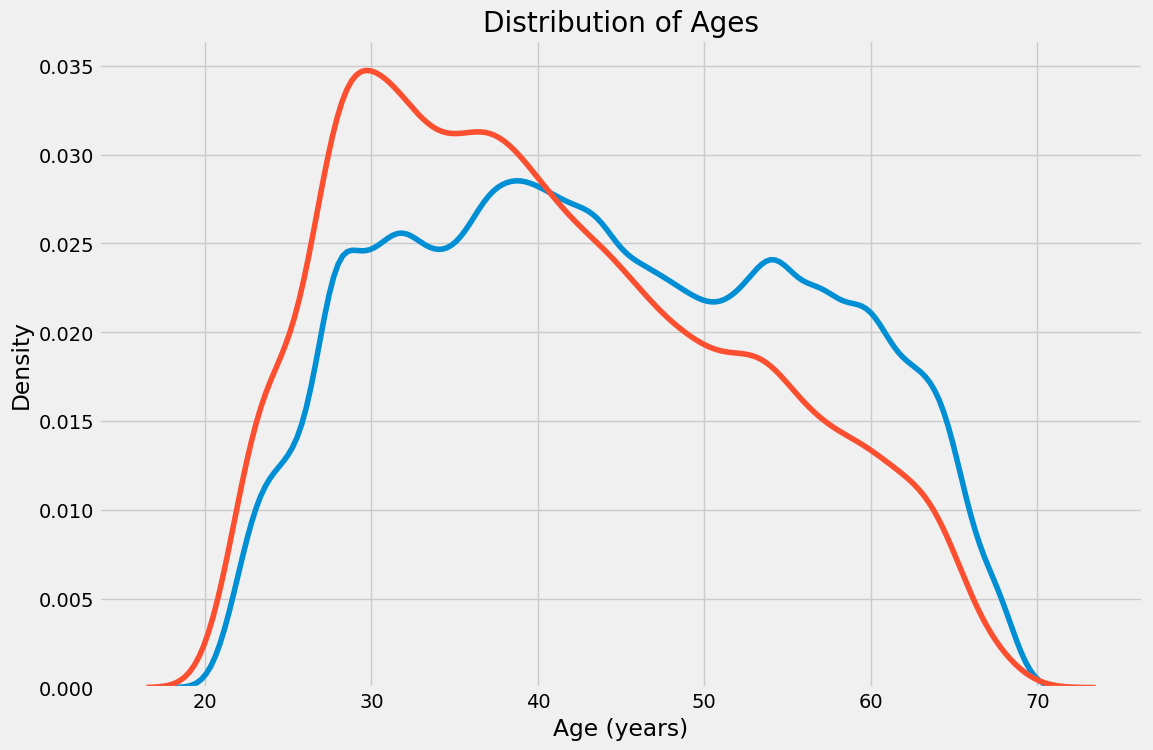

In [28]:
# KDE plot de l'âge selon le statut de remboursement
plt.figure(figsize = (12, 8))

# Bleu = Target 0 = Rembourser à temps 
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# Rouge = Target 1 = Non rembourser à temps 
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

Nous comparons la distribution des âges pour les clients remboursant ou non leur crédit.

ICI -> Rouge = Target 1 = Non rembourser à temps && Bleu = Target 0 = Rembourser à temps

La courbe pour “target = 1” penche vers les âges les plus jeunes. Même si la corrélation est faible (coef. = –0,07), l’âge reste un atout pour le modèle, car il influe sur la cible.
Pour l’autre graphique, on découpe l’âge en tranches de 5 ans, puis on calcule, pour chaque tranche, la moyenne de la cible, ce qui donne le taux de prêts non remboursés par catégorie d’âge.

In [29]:
# Découpage de l'âge en tranches et calcul du taux de défaut moyen
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

TARGET  DAYS_BIRTH  YEARS_BIRTH  YEARS_BINNED
0       1        9461    25.920548  (25.0, 30.0]
1       0       16765    45.931507  (45.0, 50.0]
2       0       19046    52.180822  (50.0, 55.0]
3       0       19005    52.068493  (50.0, 55.0]
4       0       19932    54.608219  (50.0, 55.0]
5       0       16941    46.413699  (45.0, 50.0]
6       0       13778    37.747945  (35.0, 40.0]
7       0       18850    51.643836  (50.0, 55.0]
8       0       20099    55.065753  (55.0, 60.0]
9       0       14469    39.641096  (35.0, 40.0]

In [30]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

TARGET    DAYS_BIRTH  YEARS_BIRTH
YEARS_BINNED                                     
(20.0, 25.0]  0.123036   8532.795625    23.377522
(25.0, 30.0]  0.111436  10155.219250    27.822518
(30.0, 35.0]  0.102814  11854.848377    32.479037
(35.0, 40.0]  0.089414  13707.908253    37.555913
(40.0, 45.0]  0.078491  15497.661233    42.459346
(45.0, 50.0]  0.074171  17323.900441    47.462741
(50.0, 55.0]  0.066968  19196.494791    52.593136
(55.0, 60.0]  0.055314  20984.262742    57.491131
(60.0, 65.0]  0.052737  22780.547460    62.412459
(65.0, 70.0]  0.037270  24292.614340    66.555108

Nous segmentons l’âge en classes et analysons le taux de défaut par tranche.

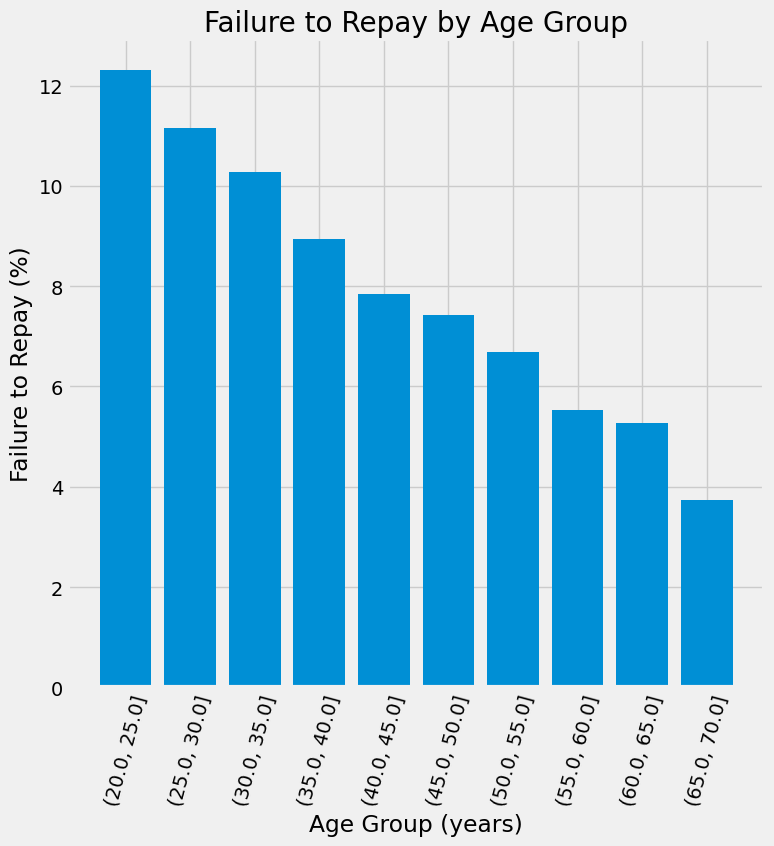

In [71]:
# Affichage du taux de défaut par tranche d’âge
plt.figure(figsize = (8, 8))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

On observe une tendance nette : les plus jeunes candidats sont plus susceptibles de ne pas rembourser leur prêt. Le taux de défaut dépasse 10 % pour les trois premières tranches d’âge et tombe sous 5 % pour la plus âgée.

Ces données peuvent guider la banque : comme les jeunes ont un risque de défaut plus élevé, il serait pertinent de leur offrir davantage de conseils ou un accompagnement financier. Il ne s’agit pas de les pénaliser, mais de prendre des mesures préventives pour les aider à rembourser à temps.

---

Les trois variables les plus corrélées négativement à la cible sont EXT_SOURCE_1, EXT_SOURCE_2 et EXT_SOURCE_3. D’après la documentation, ce sont des « scores normalisés issus de sources de données externes », probablement une évaluation de crédit cumulative sur plusieurs sources.

Examinons ces variables.
D’abord, affichons leurs corrélations avec la cible et entre elles.

In [32]:
# Extraction des variables EXT_SOURCE, l'age et la cible pour analyse de corrélation
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

TARGET  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  DAYS_BIRTH
TARGET        1.000000     -0.155317     -0.160472     -0.178919   -0.078239
EXT_SOURCE_1 -0.155317      1.000000      0.213982      0.186846    0.600610
EXT_SOURCE_2 -0.160472      0.213982      1.000000      0.109167    0.091996
EXT_SOURCE_3 -0.178919      0.186846      0.109167      1.000000    0.205478
DAYS_BIRTH   -0.078239      0.600610      0.091996      0.205478    1.000000

Nous extrayons les variables EXT_SOURCE, l'age et la cible pour étudier leurs corrélations et leur impact sur le risque de défaut.

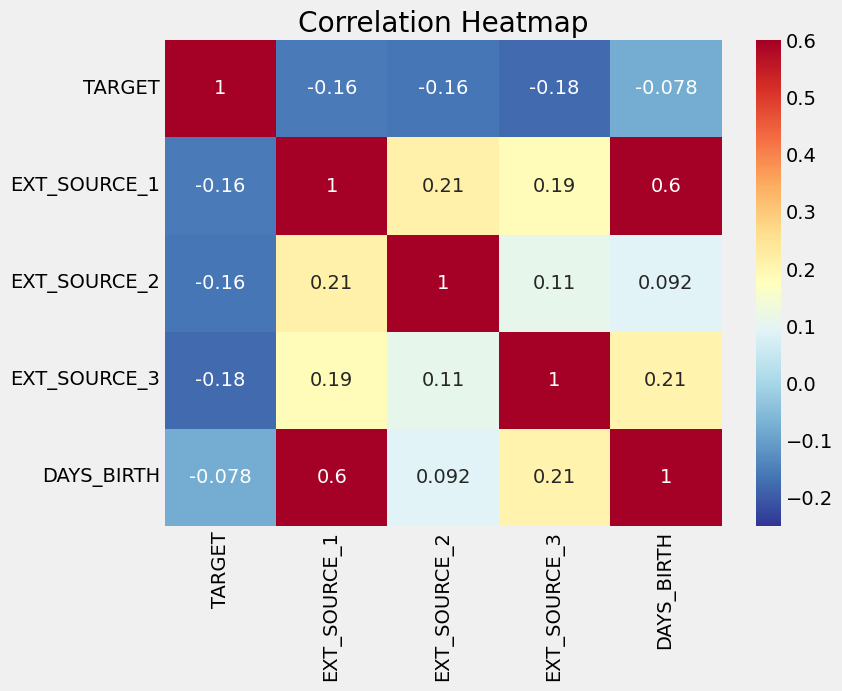

In [33]:
# Affichage de la heatmap des corrélations
plt.figure(figsize = (8, 6))

sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Les trois variables EXT_SOURCE sont négativement corrélées à la cible : plus leur valeur est élevée, plus le client a de chances de rembourser son prêt. On constate aussi que DAYS_BIRTH est positivement corrélé à EXT_SOURCE_1, ce qui suggère que l’âge du client contribue à ce score.



---

Passons maintenant à la représentation de la distribution de chacune de ces variables, colorée selon la valeur de la cible, pour en visualiser l’influence.

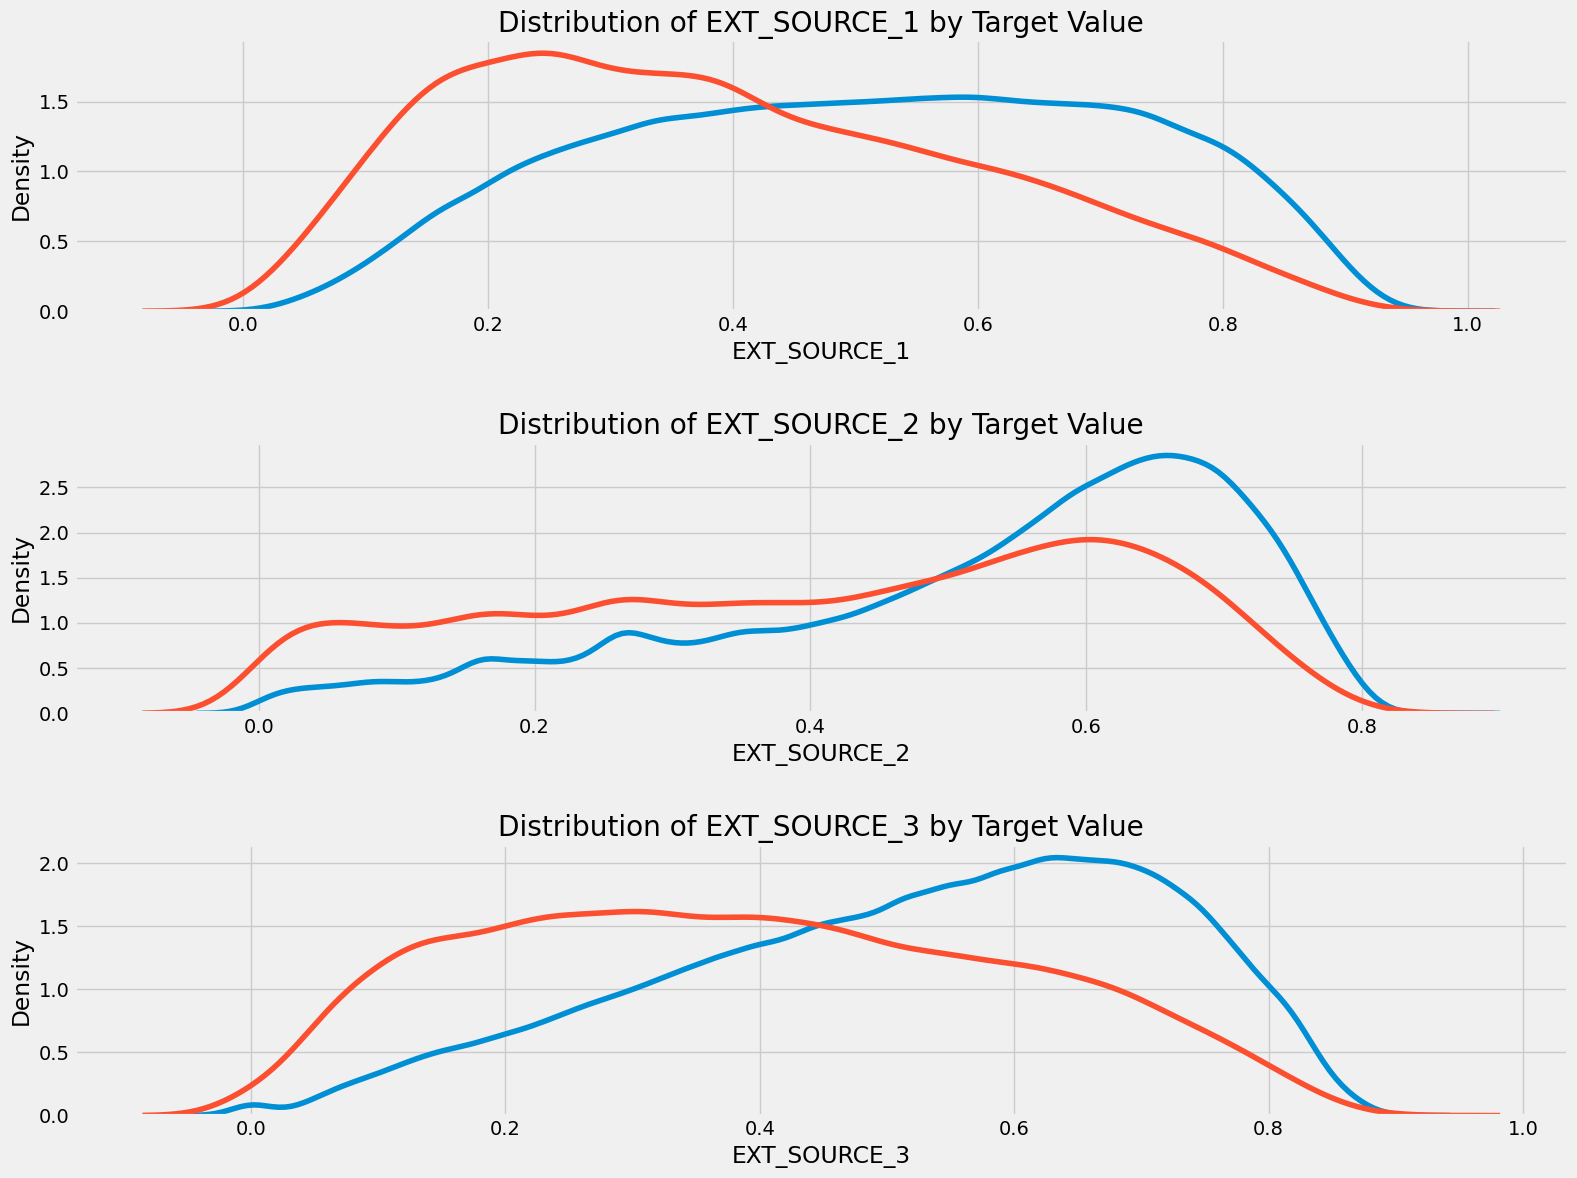

In [34]:
# Visualisation des distributions EXT_SOURCE selon la cible
plt.figure(figsize = (16, 12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)
    

ICI -> Rouge = Target 1 = Non rembourser à temps && Bleu = Target 0 = Rembourser à temps

EXT_SOURCE_3 présente le plus grand écart entre les deux modalités de la cible. 

On y voit clairement un lien avec la probabilité de remboursement : plus le score est élevé, plus le client rembourse. Même si ces relations restent faibles, ces variables restent utiles pour un modèle d'apprentissage visant à prédire le remboursement à temps.

---

Pour conclure l’exploration, réalisons un pairs plot des variables EXT_SOURCE et de DAYS_BIRTH. Cet outil permet d’observer à la fois les relations entre paires de variables et la distribution de chacune. Nous utilisons Seaborn avec PairGrid : en haut à droite des nuages de points, sur la diagonale des histogrammes, et en bas à gauche des densités 2D accompagnées des coefficients de corrélation.

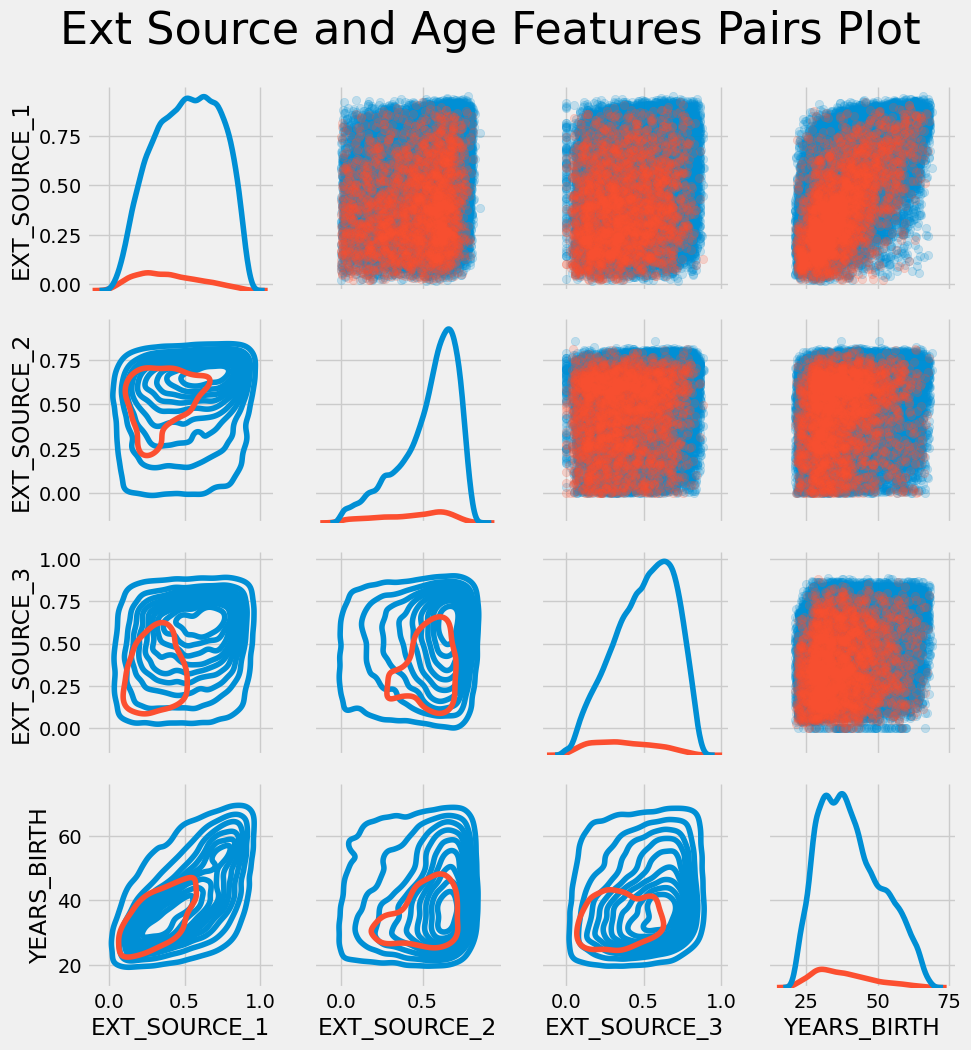

In [35]:
# Analyse croisée âge et scores externes (pairplot)
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

plot_data = plot_data.dropna().loc[:100000, :]

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

grid = sns.PairGrid(data = plot_data, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

grid.map_upper(plt.scatter, alpha = 0.2)

grid.map_diag(sns.kdeplot)

grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

Ici, le rouge correspond aux prêts non remboursés et le bleu aux prêts remboursés. On y perçoit différentes relations entre les variables. On note notamment une corrélation linéaire positive modérée entre EXT_SOURCE_1 et DAYS_BIRTH (ou YEARS_BIRTH), ce qui suggère que ce score intègre l’âge du client.

---

#### Visualisation et répartition globale :

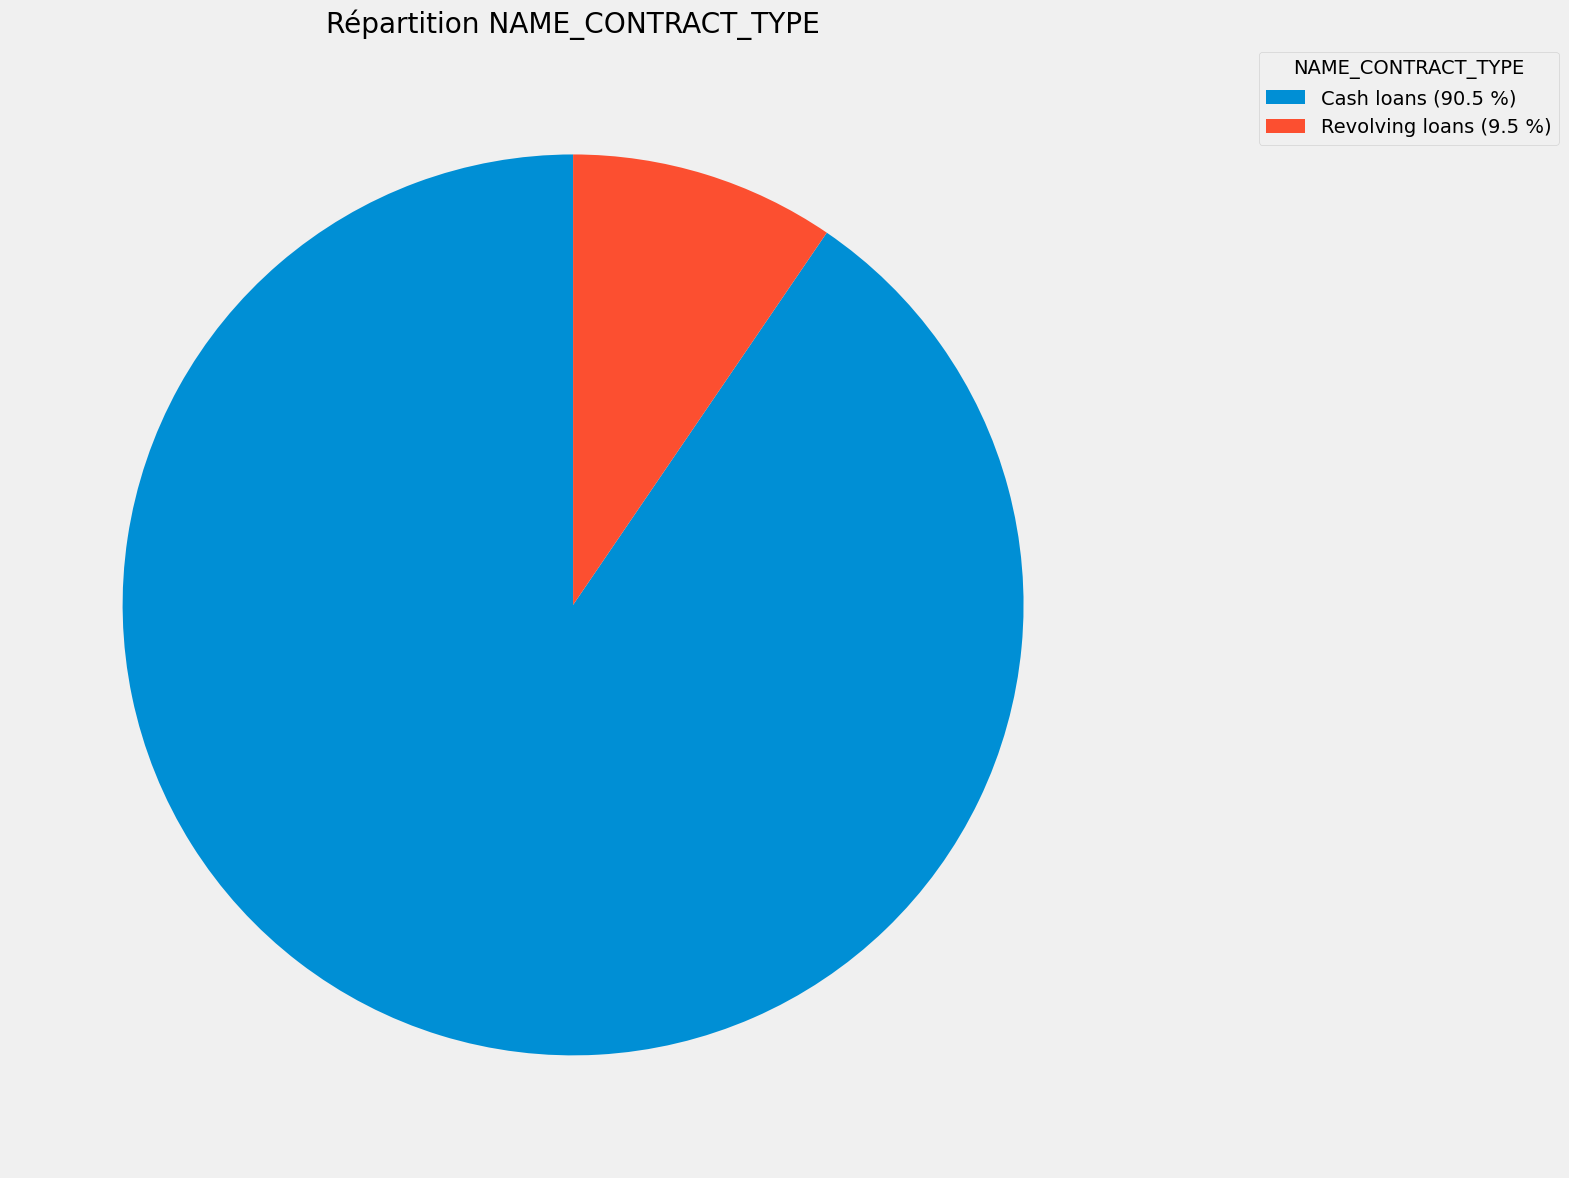

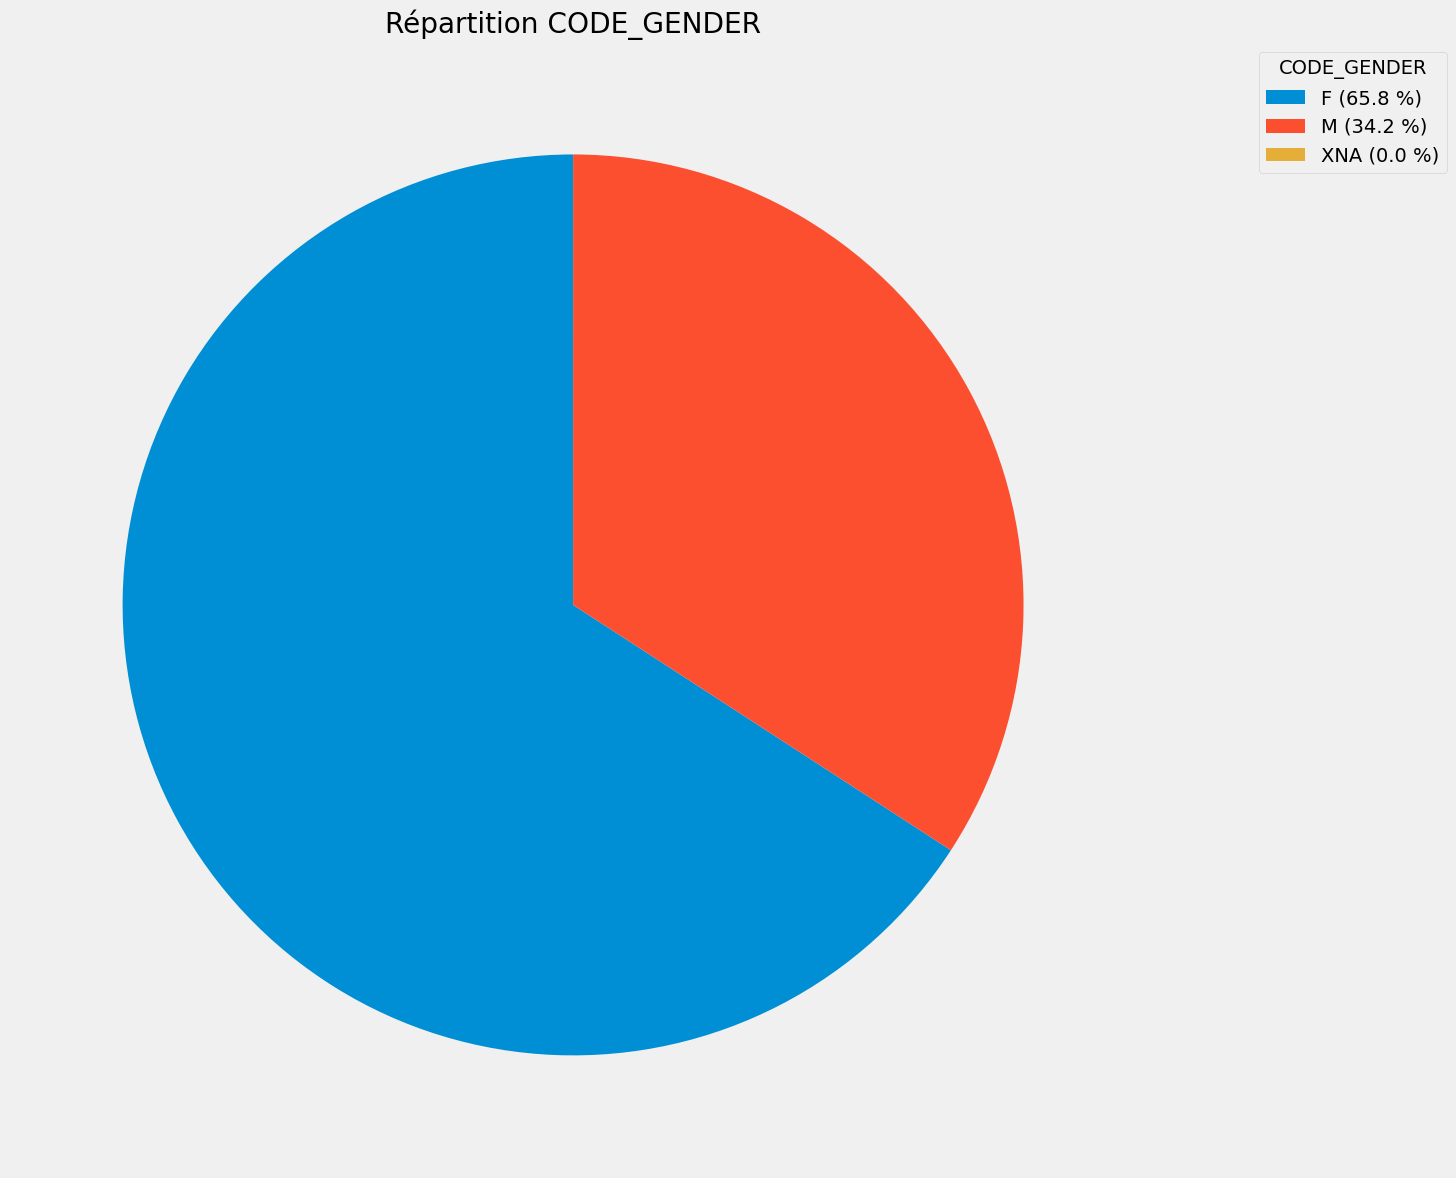

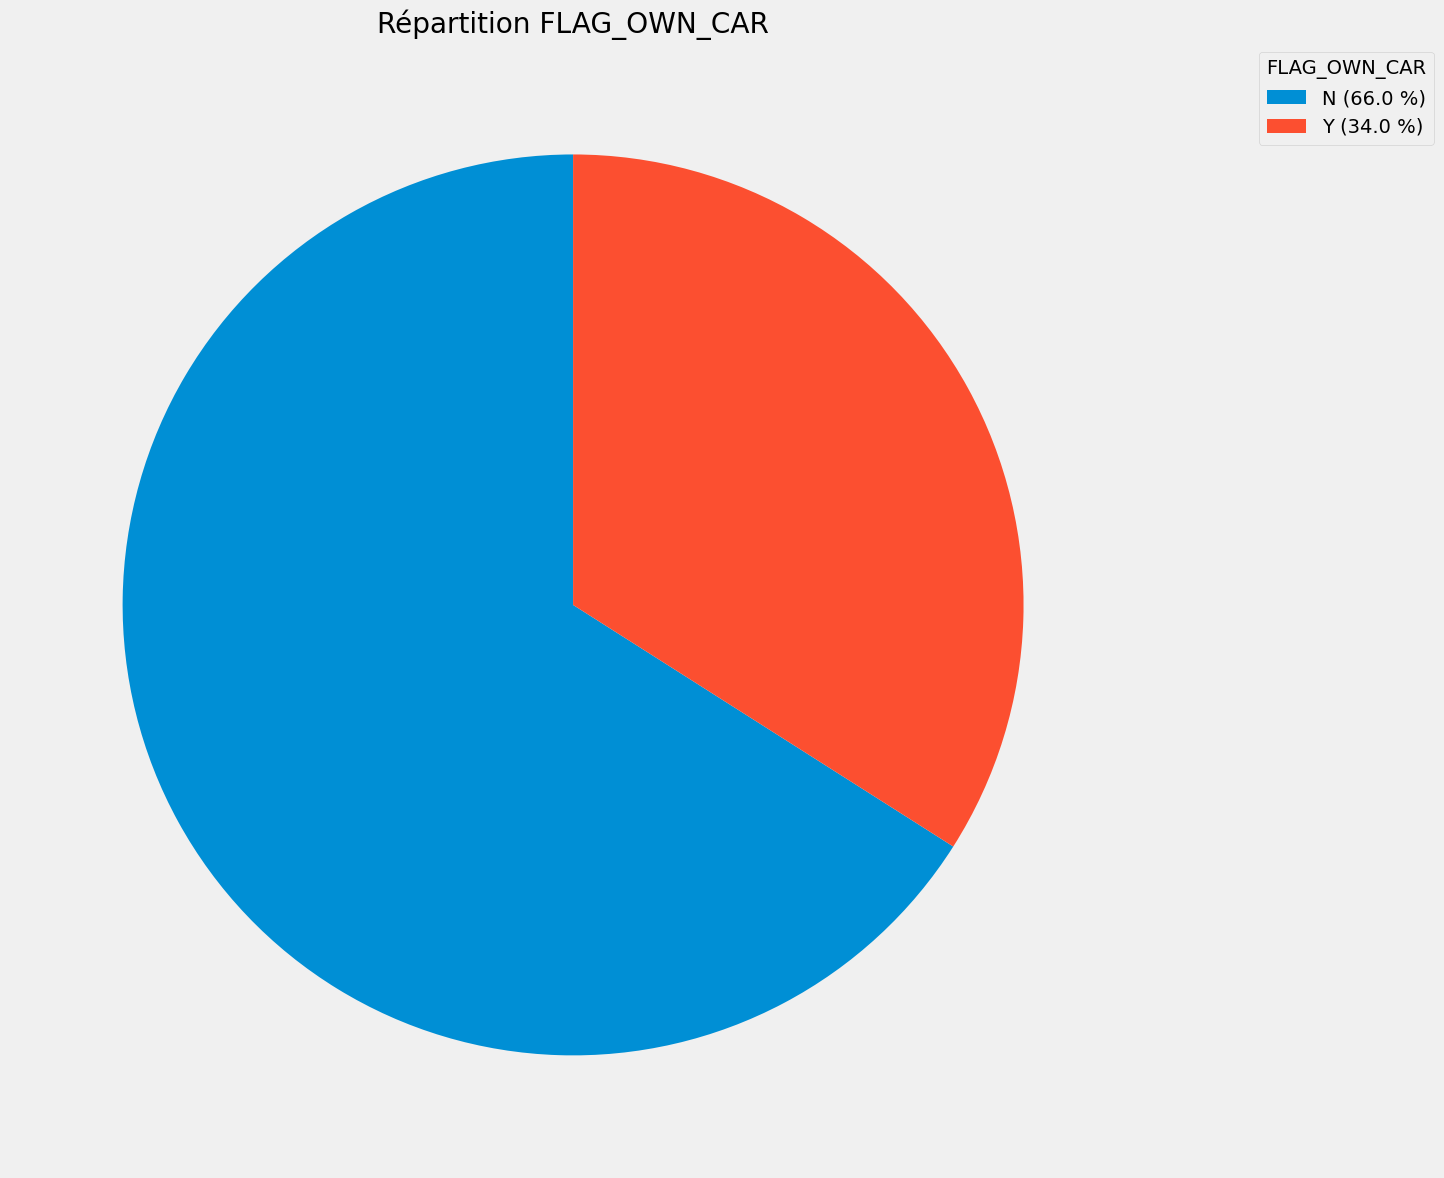

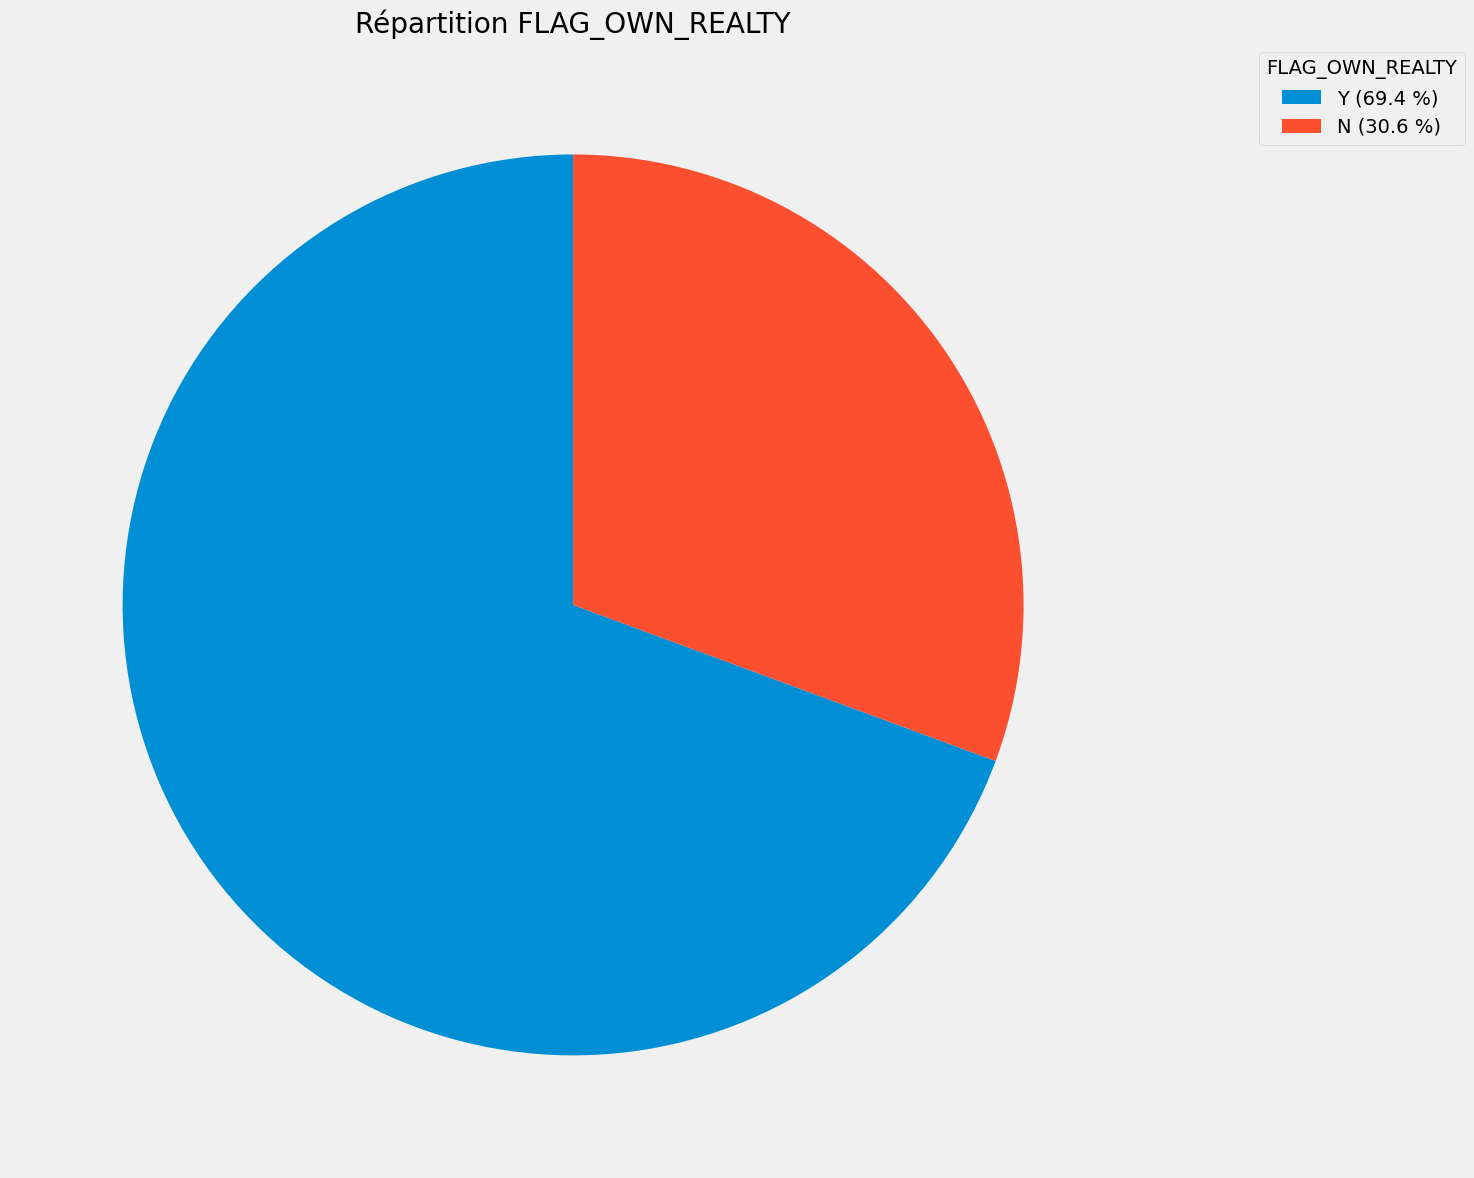

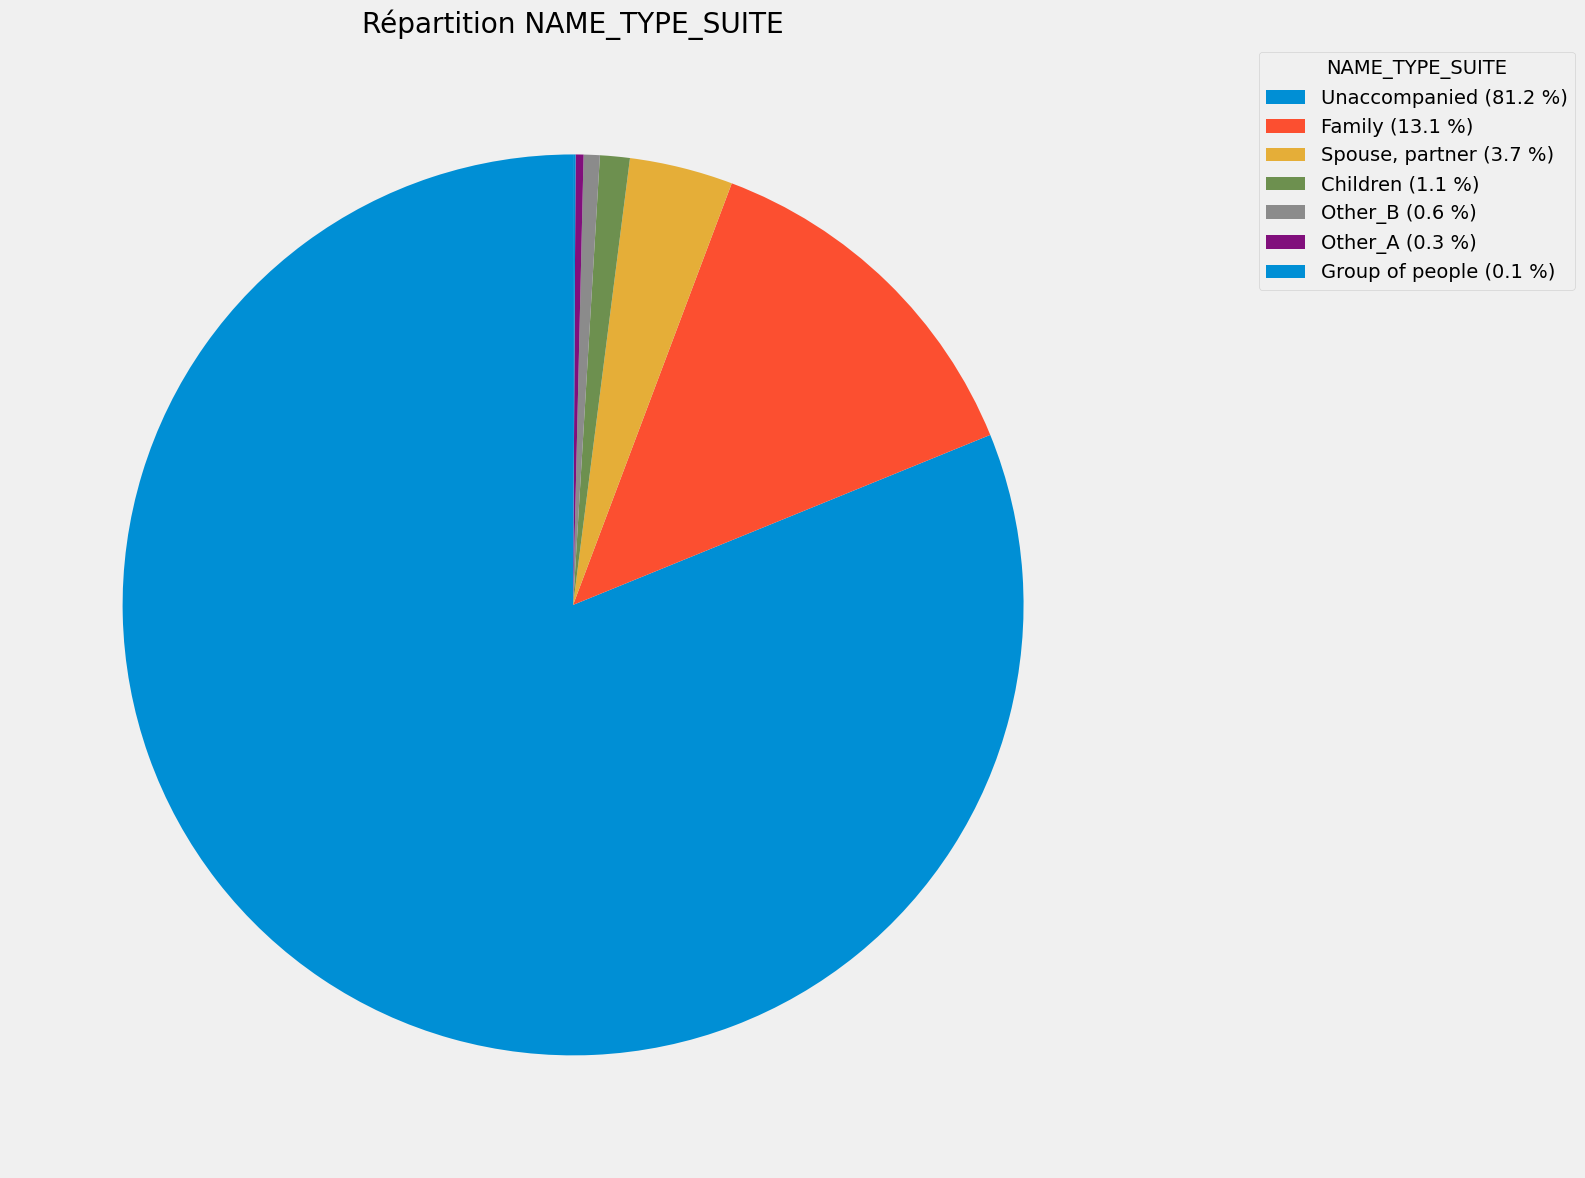

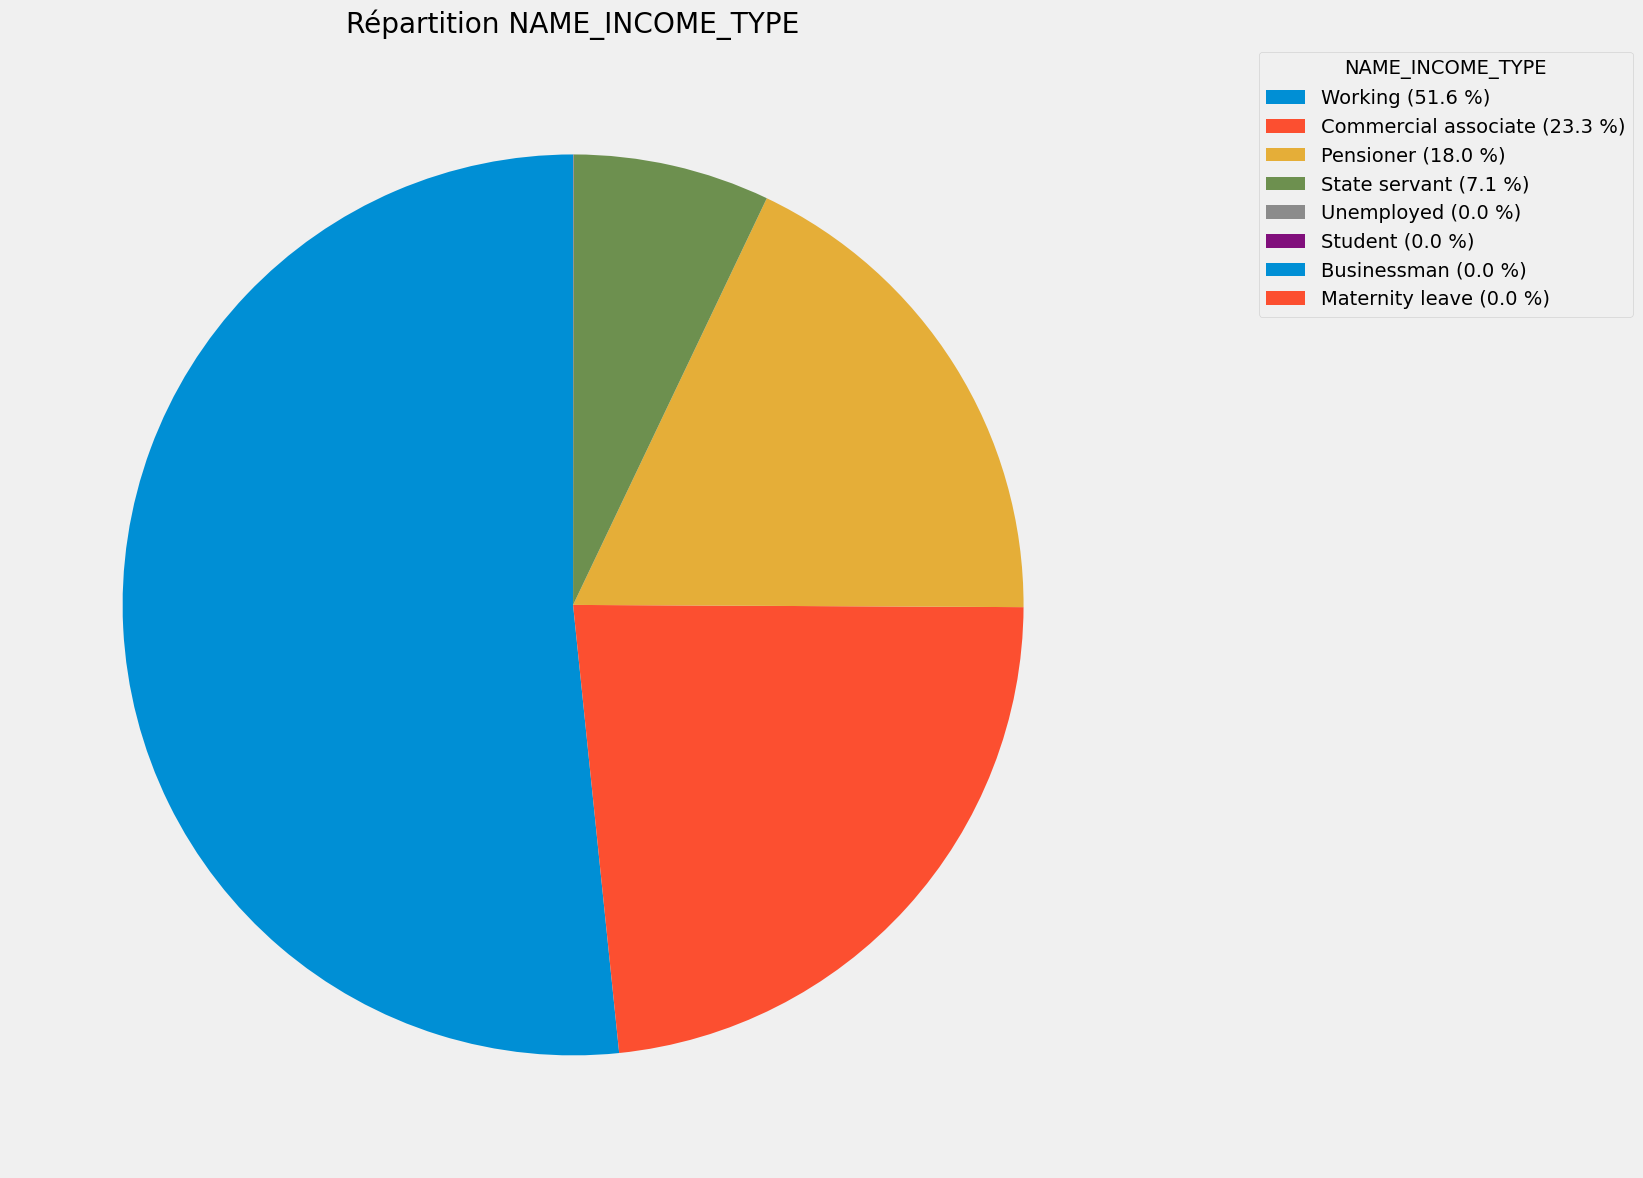

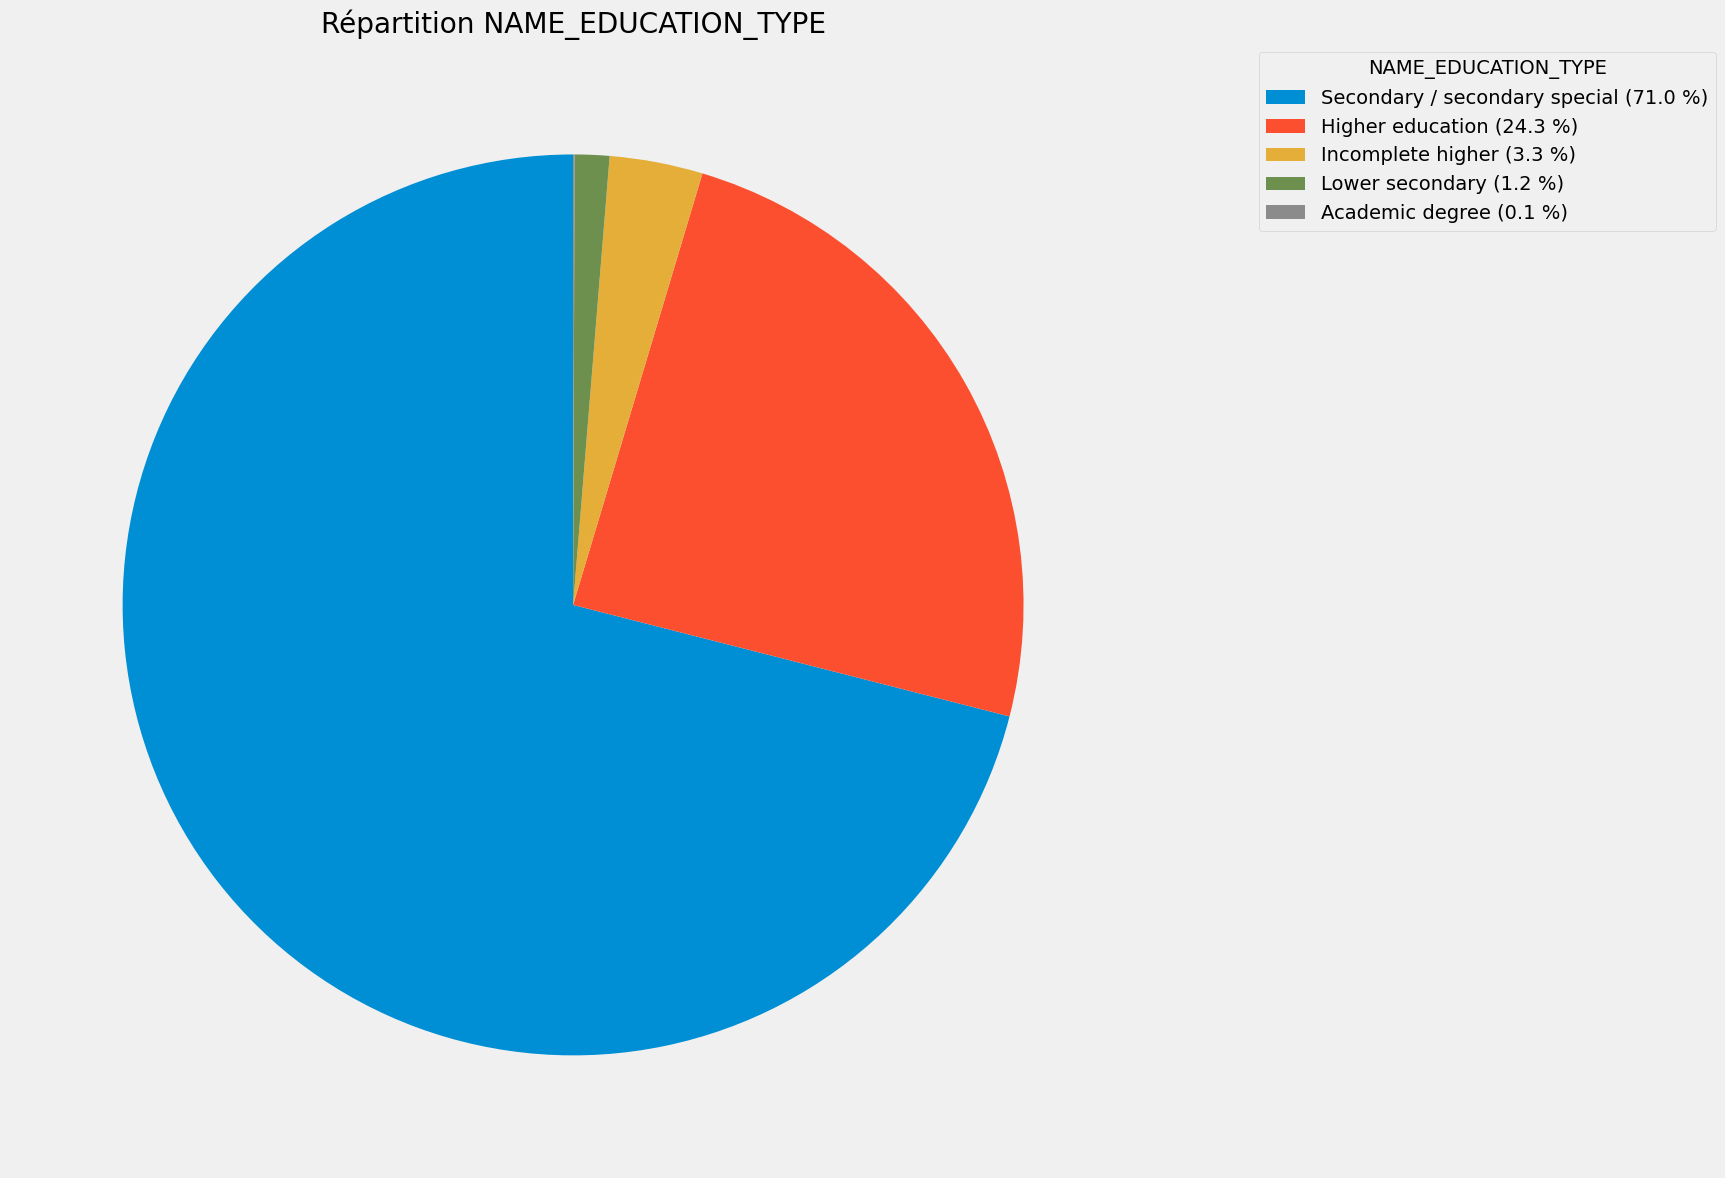

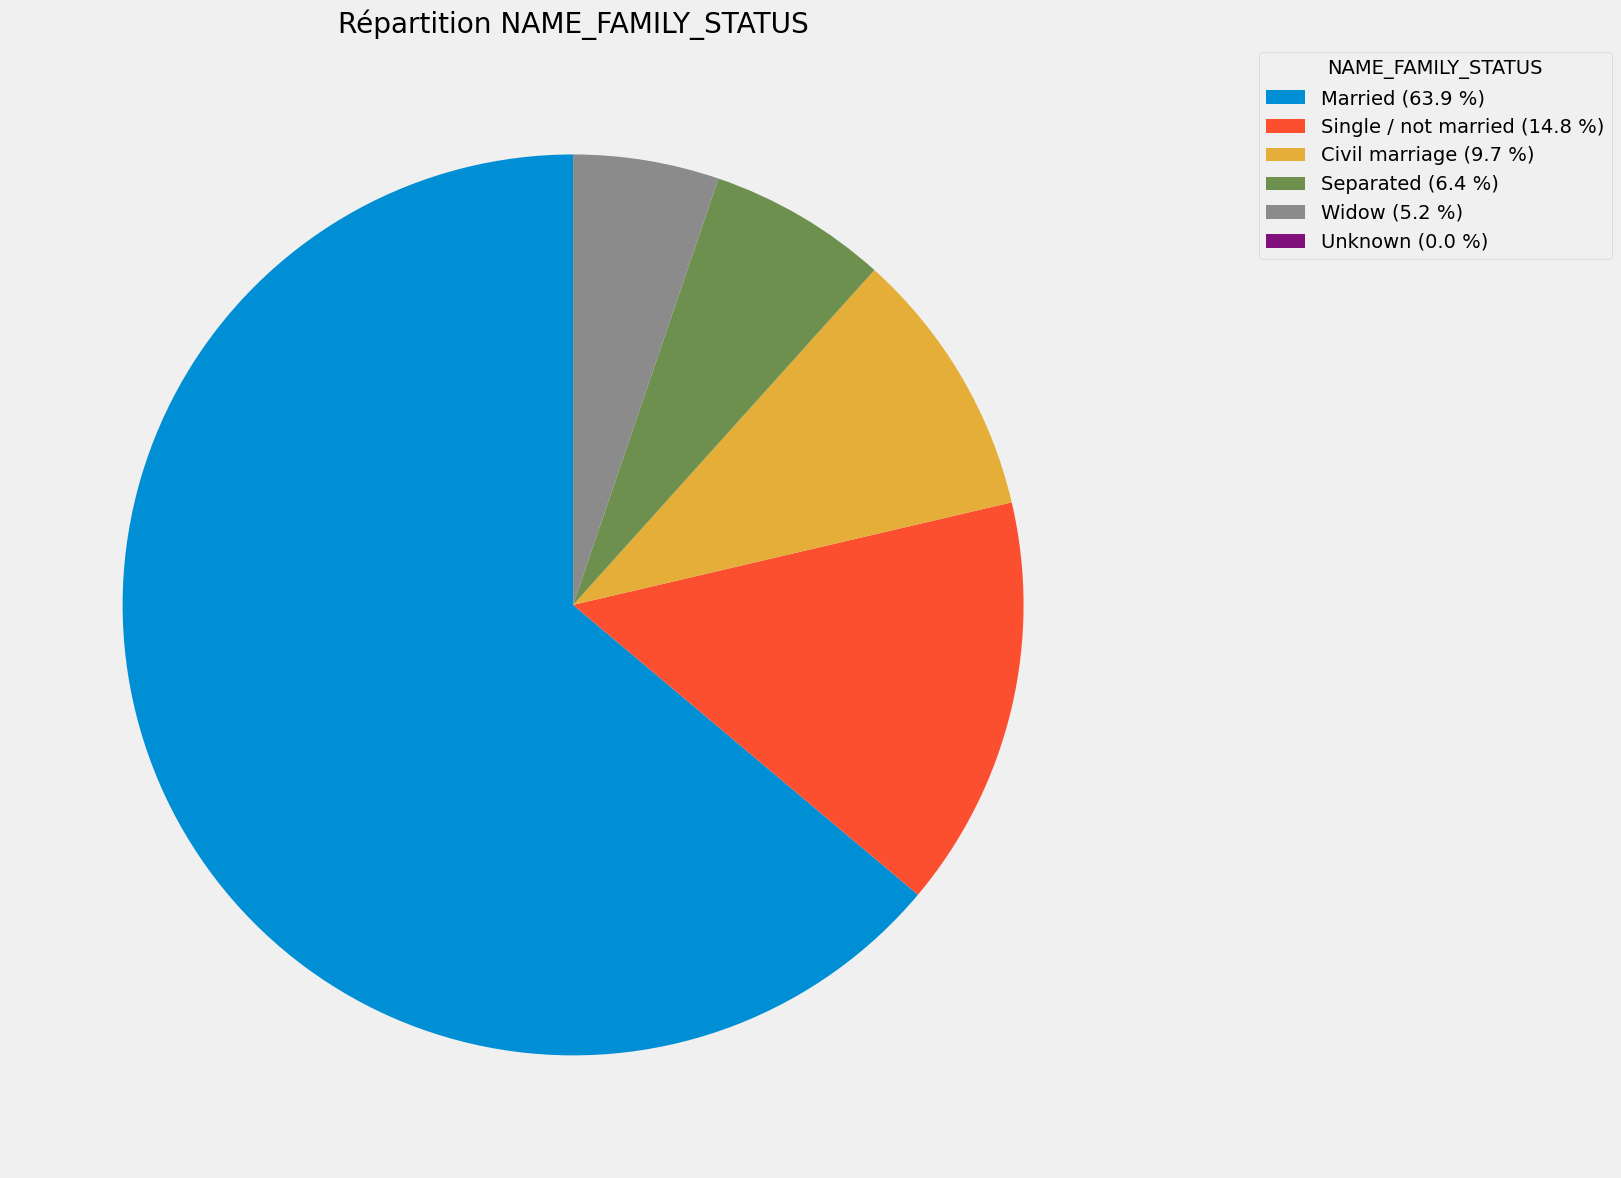

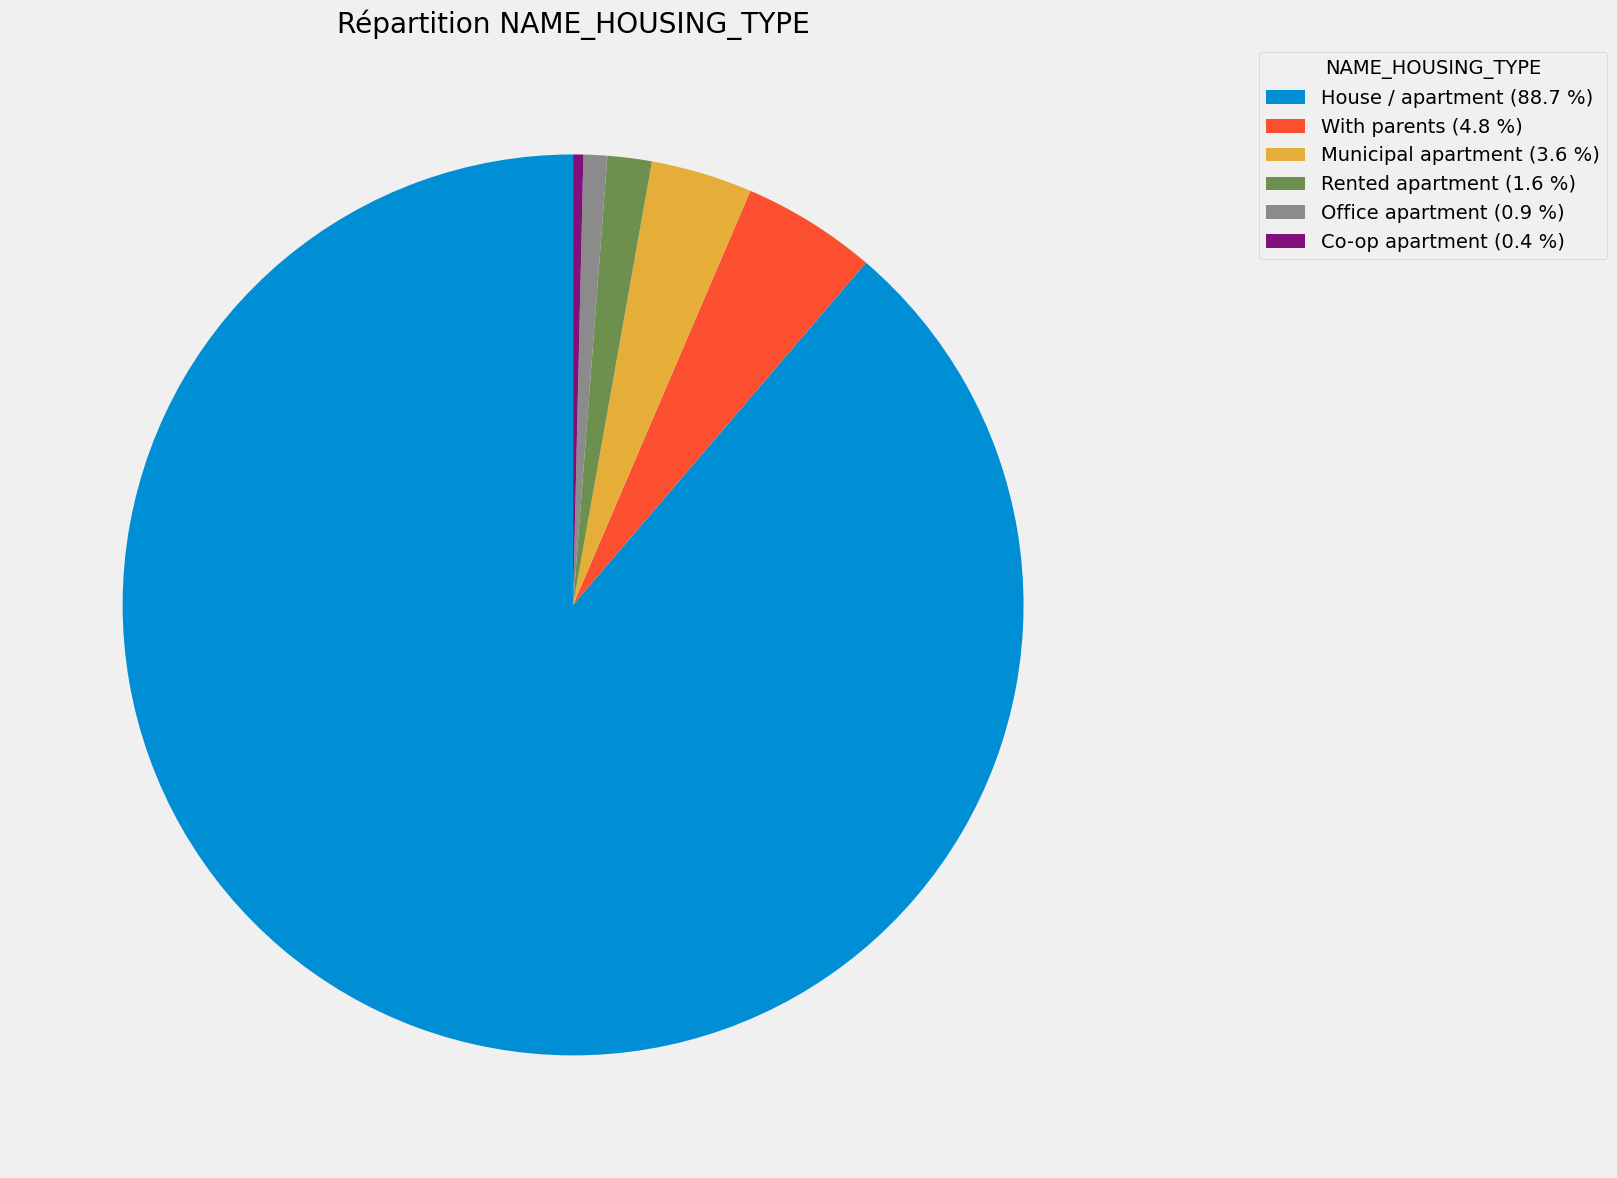

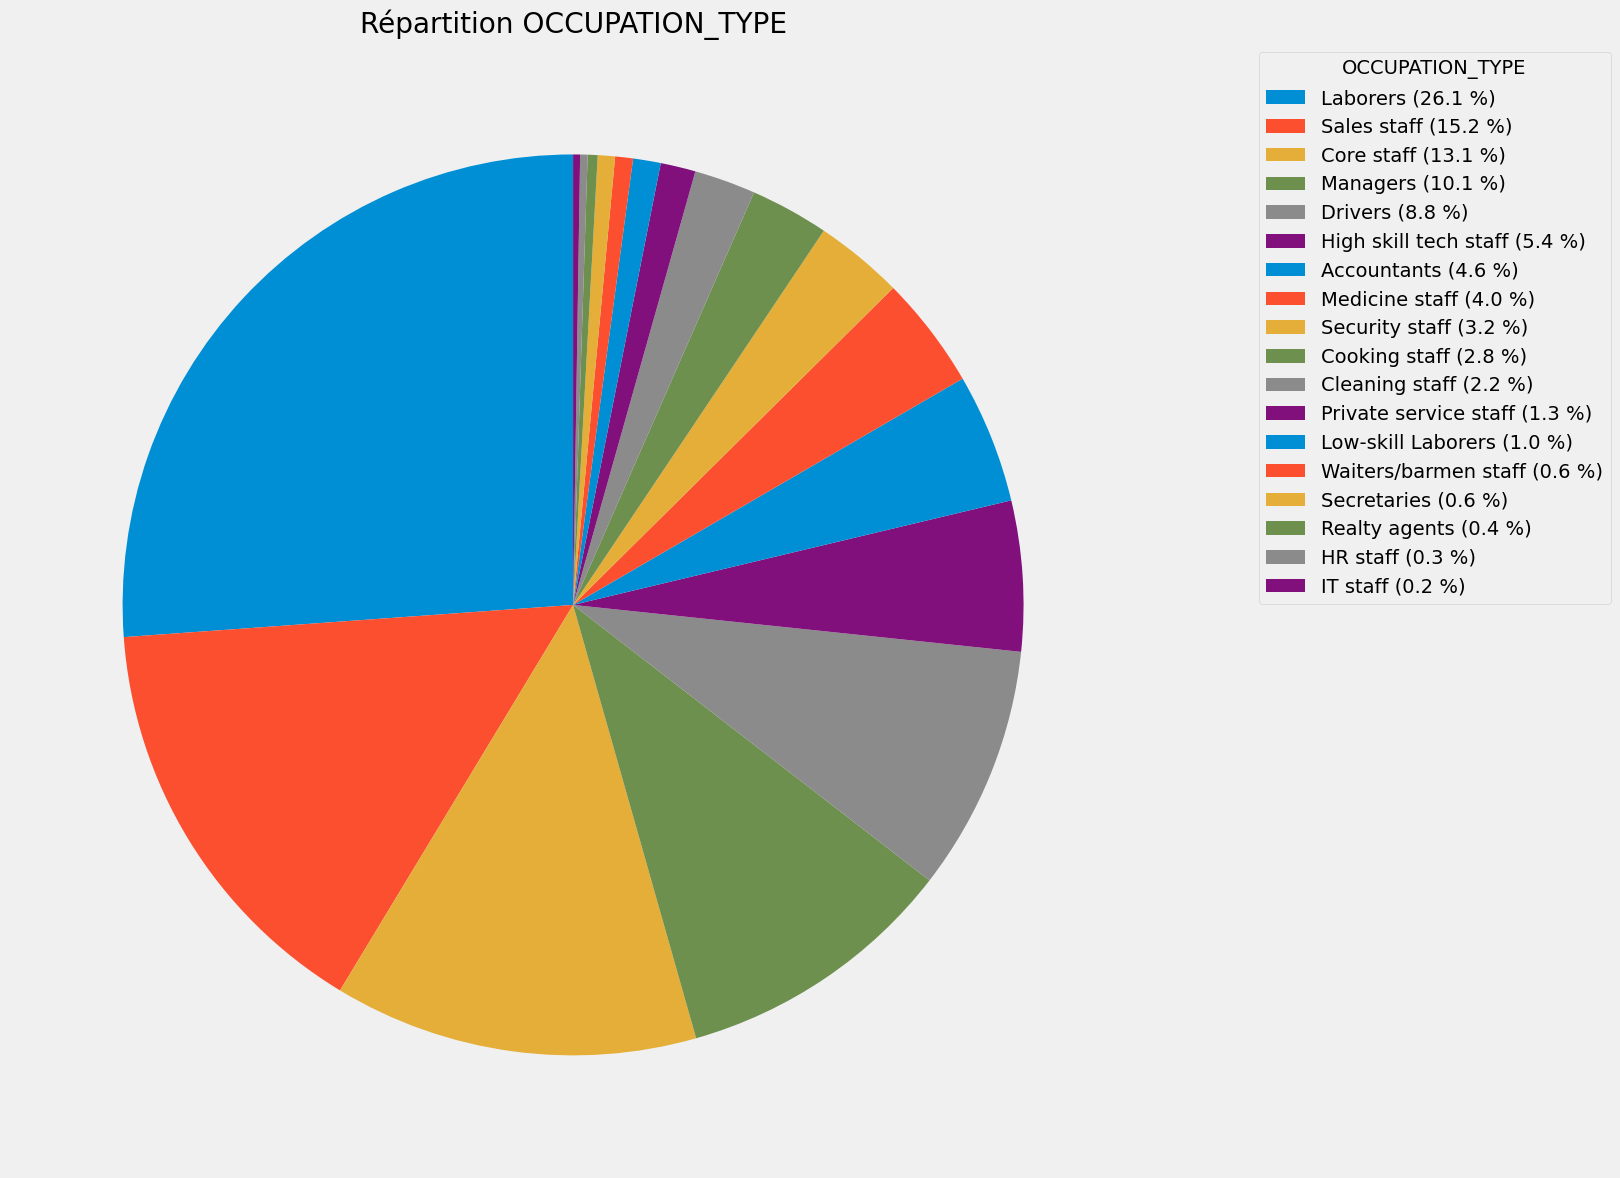

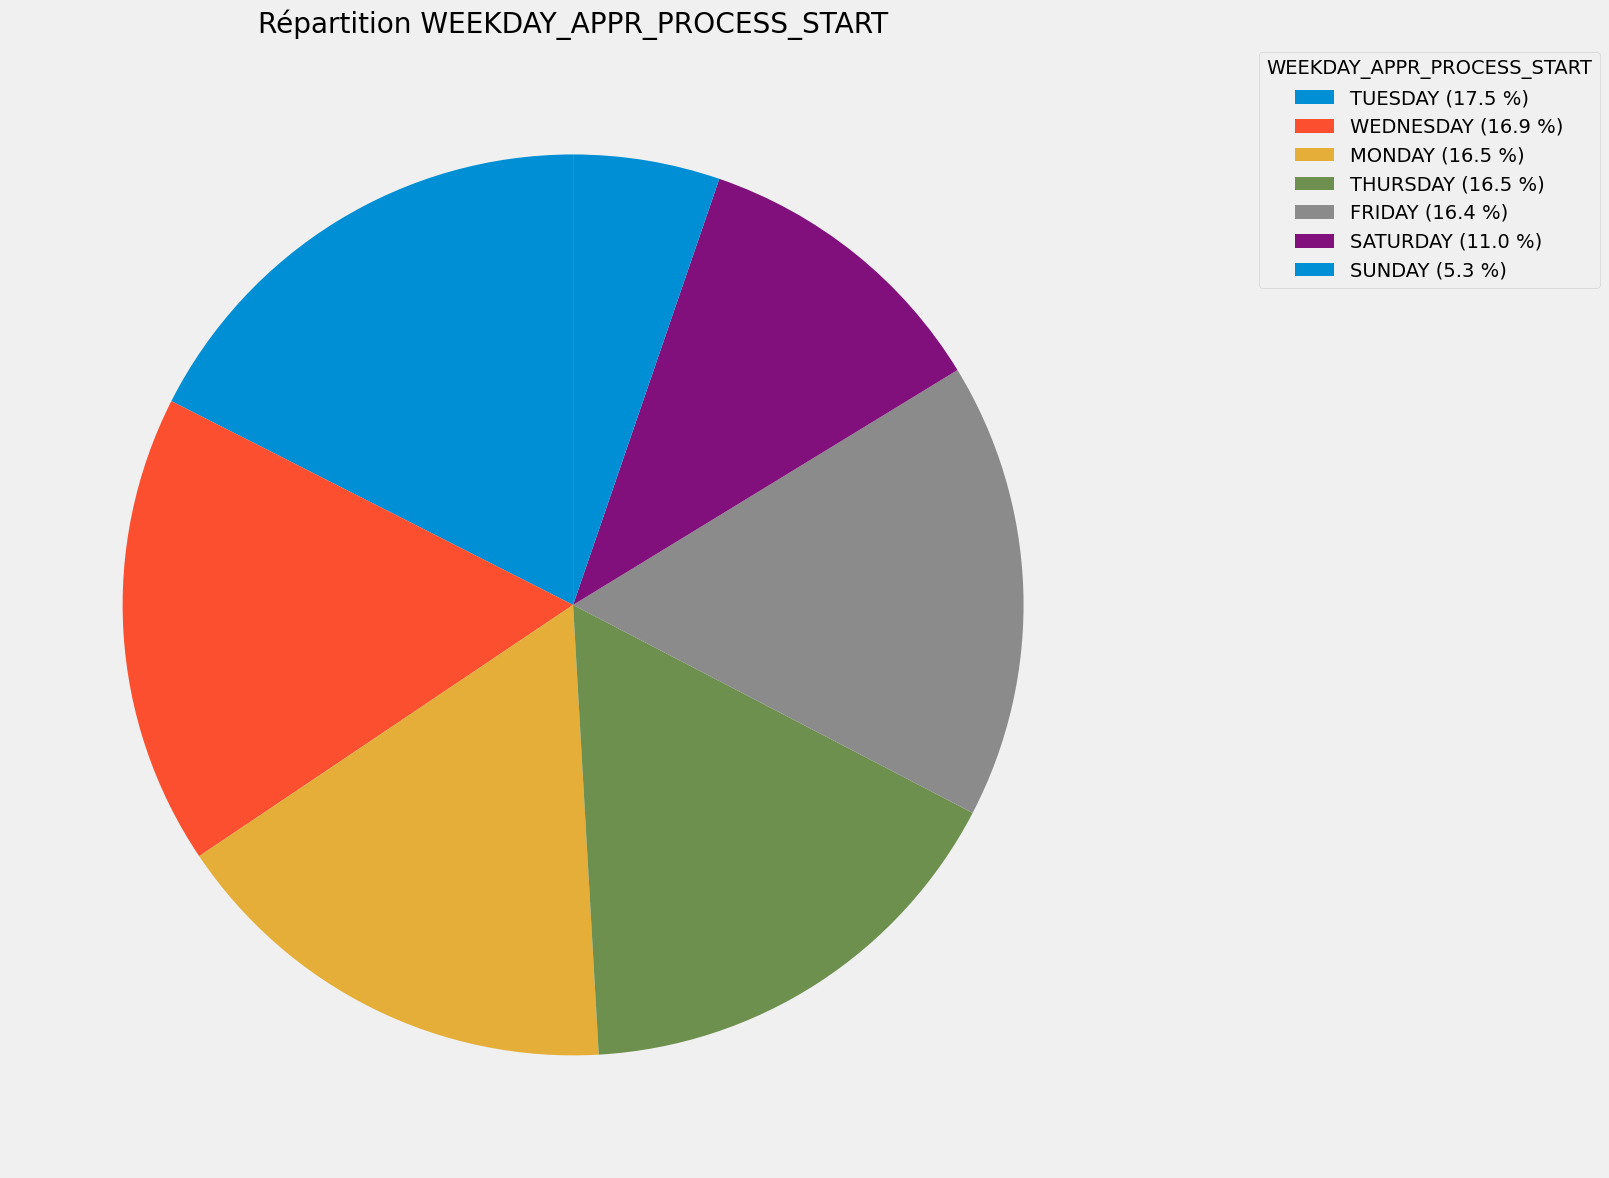

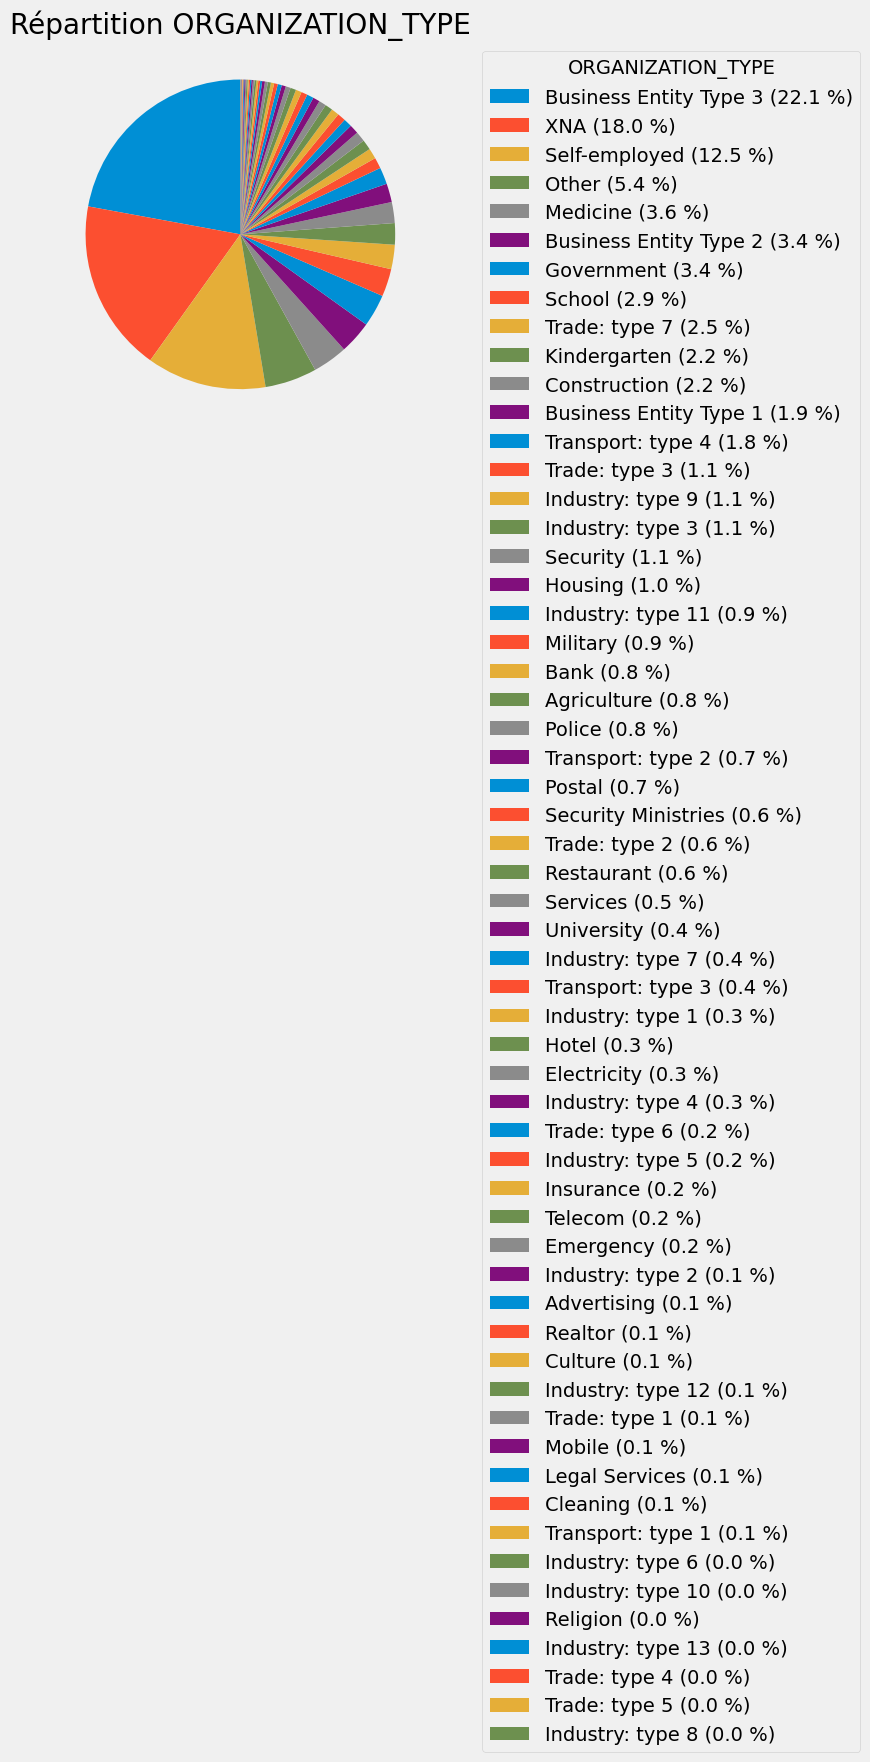

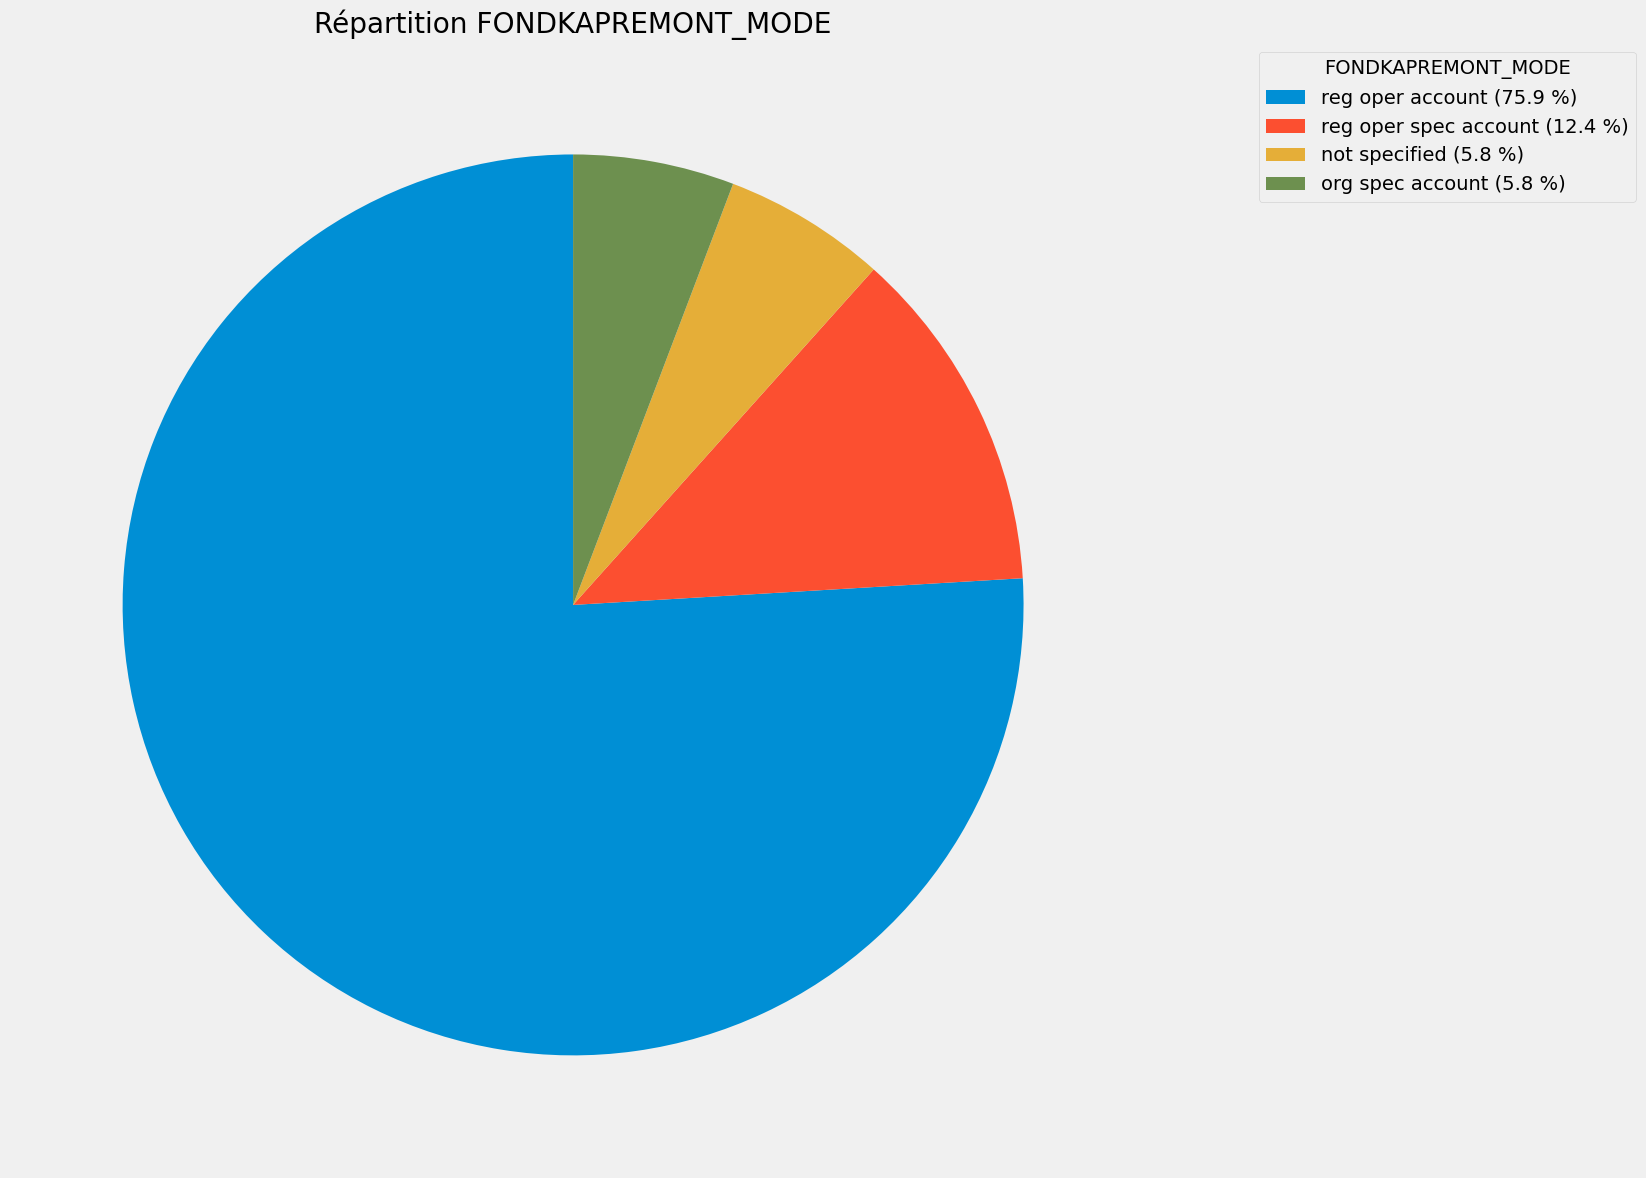

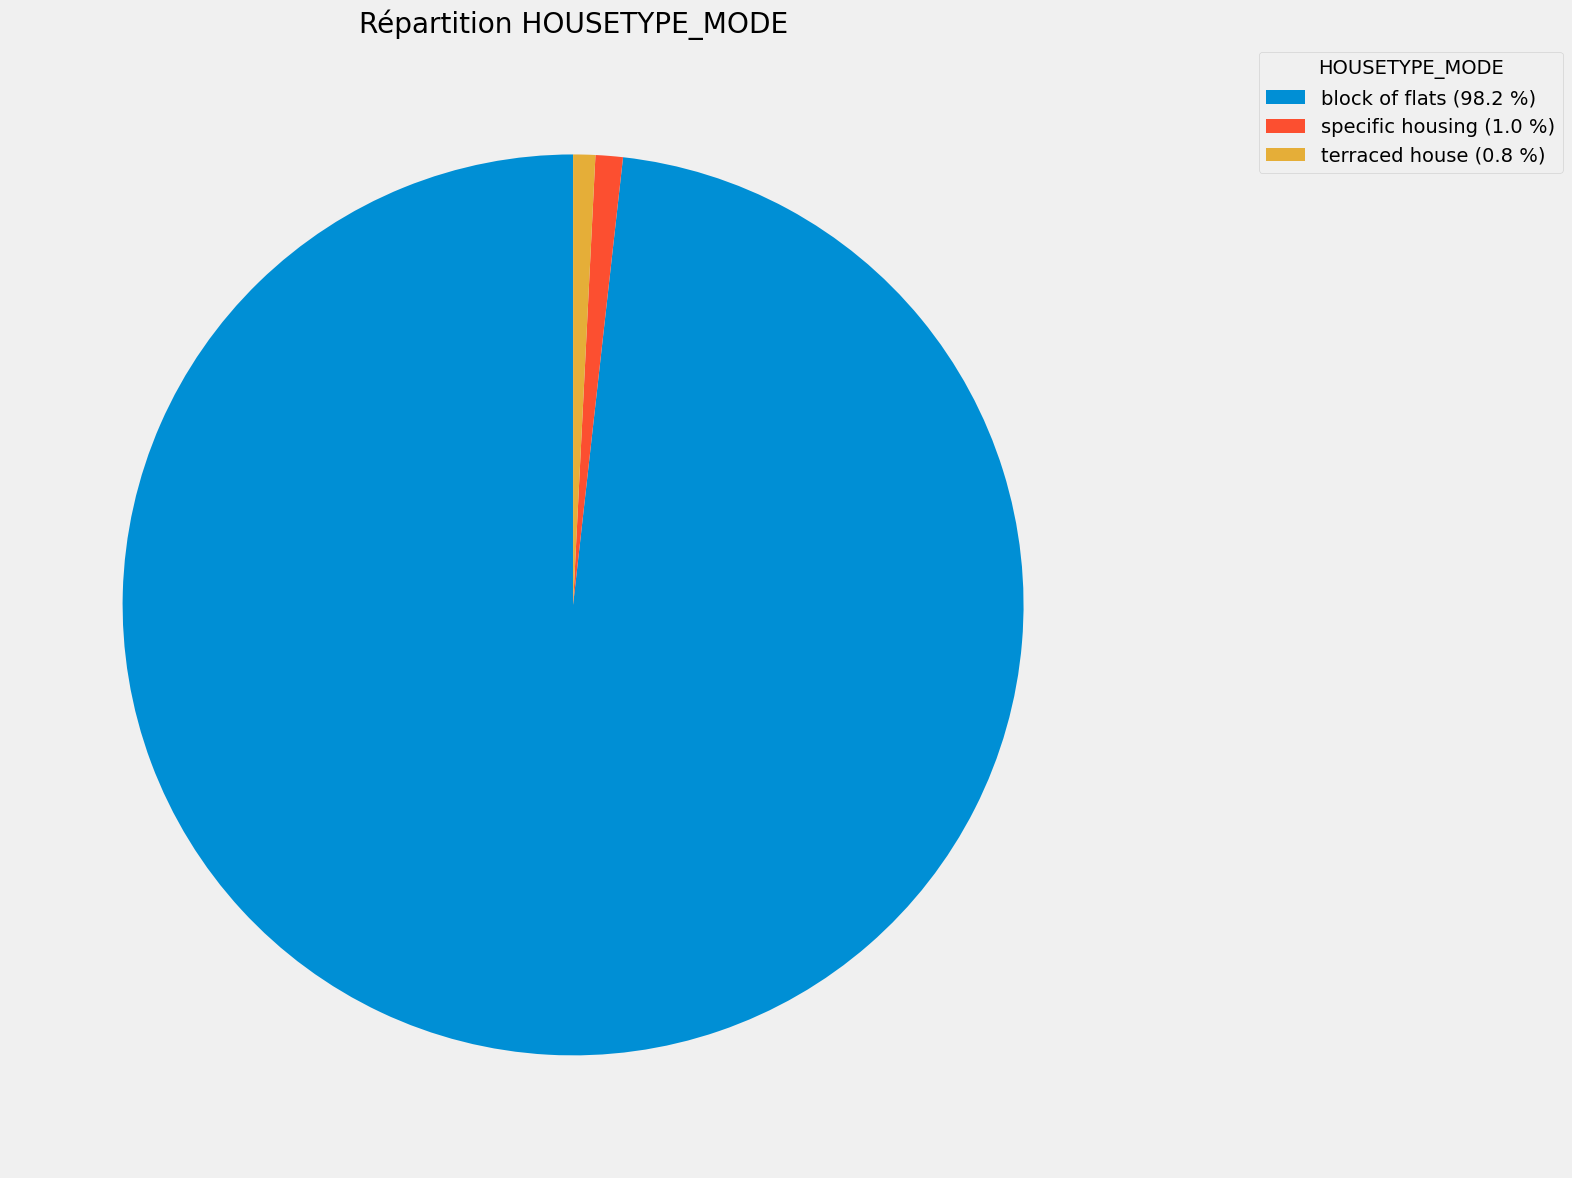

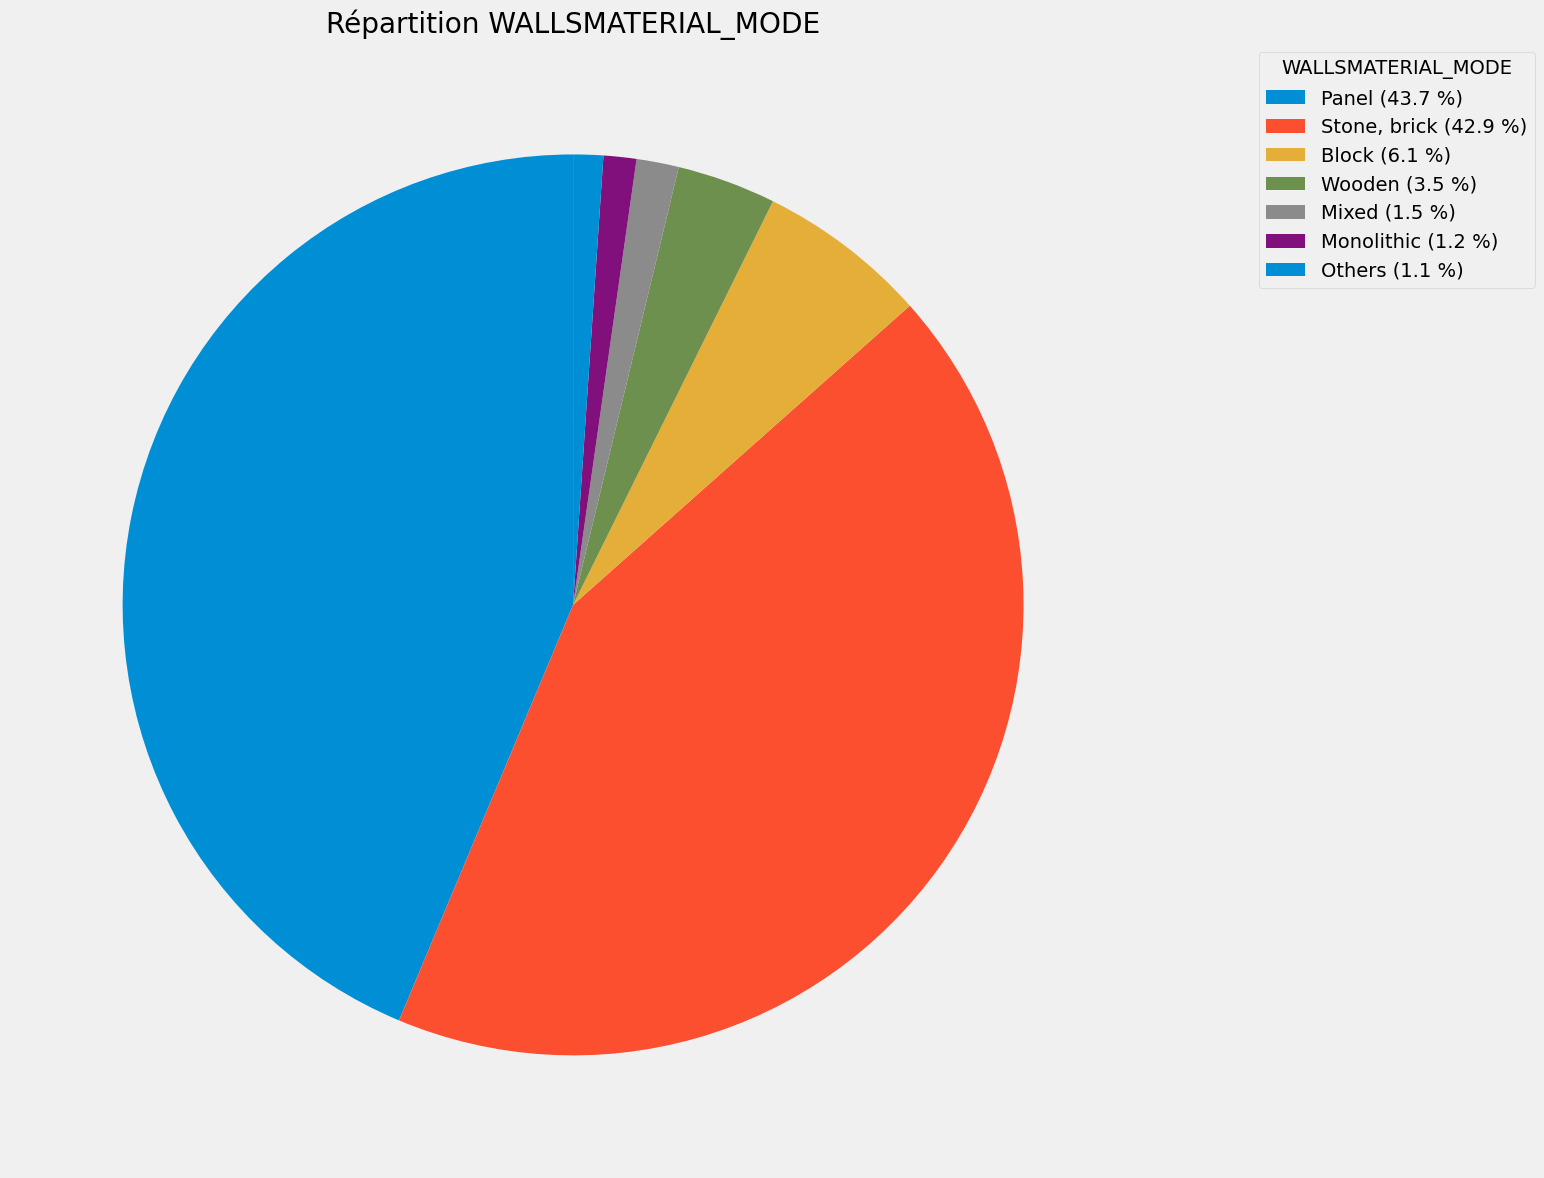

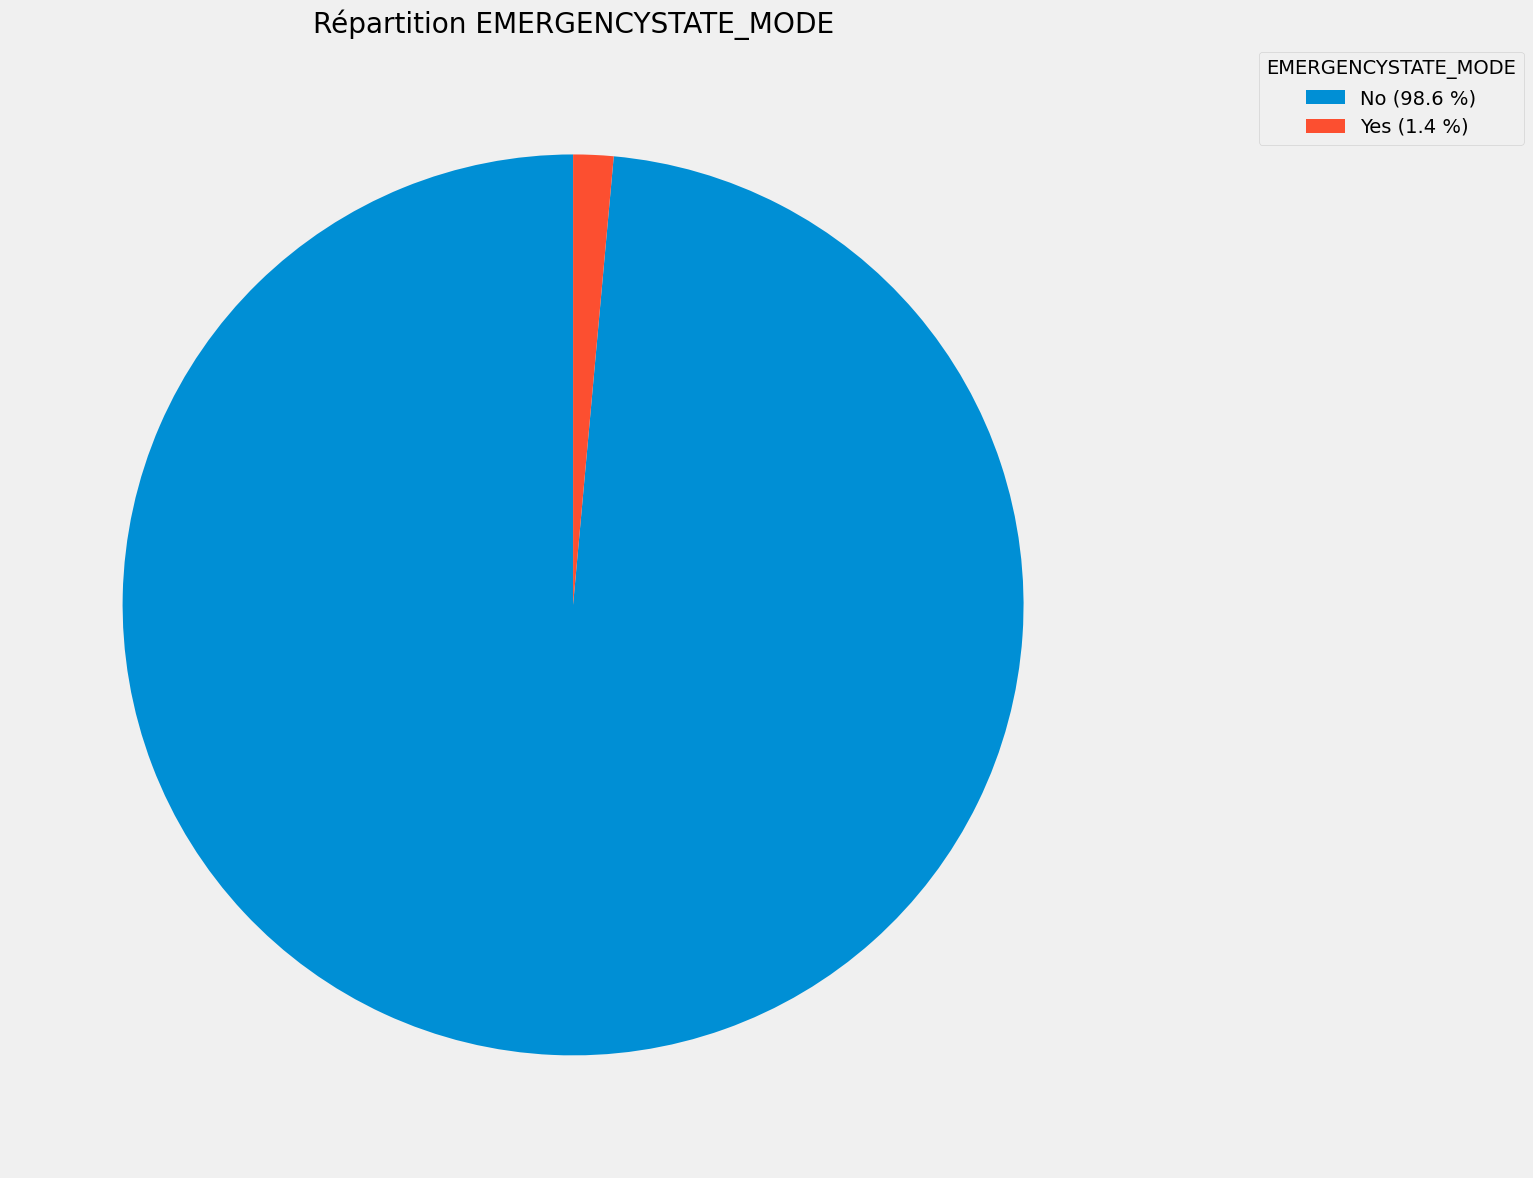

In [36]:
# Visualisation de la répartition de chaque variable catégorielle sous forme de camembert
for col in app_train.select_dtypes('object').columns[:150]:
    counts = app_train[col].value_counts(normalize=True)

    legend_labels = [
        f"{cat} ({pct*100:.1f} %)"
        for cat, pct in zip(counts.index, counts.values)
    ]

    fig, ax = plt.subplots(figsize=(18, 12))
    counts.plot.pie(
        labels=None,         
        autopct=None, 
        pctdistance=0.8,
        startangle=90,
        ax=ax
    )
    ax.set_ylabel('')
    ax.set_title(f"Répartition {col}")

    ax.legend(
        legend_labels,
        title=col,
        bbox_to_anchor=(1.1, 1),
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


Nous vérifions visuellement la répartition de chaque variable. On voit vite si une modalité domine ou si la variable est bien équilibrée.

---

Visualisation – variables INT (histogrammes + boxplots) :

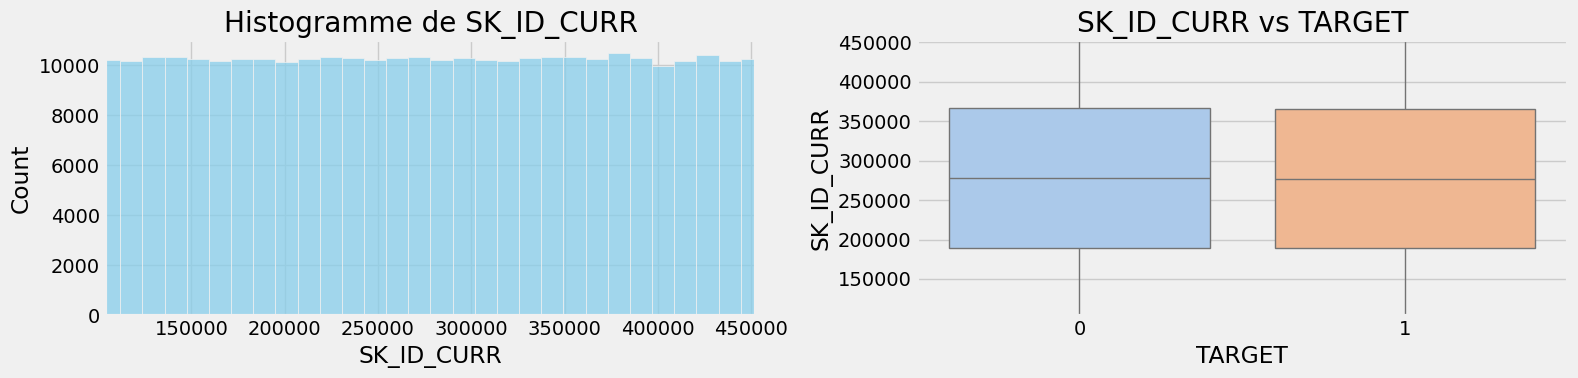

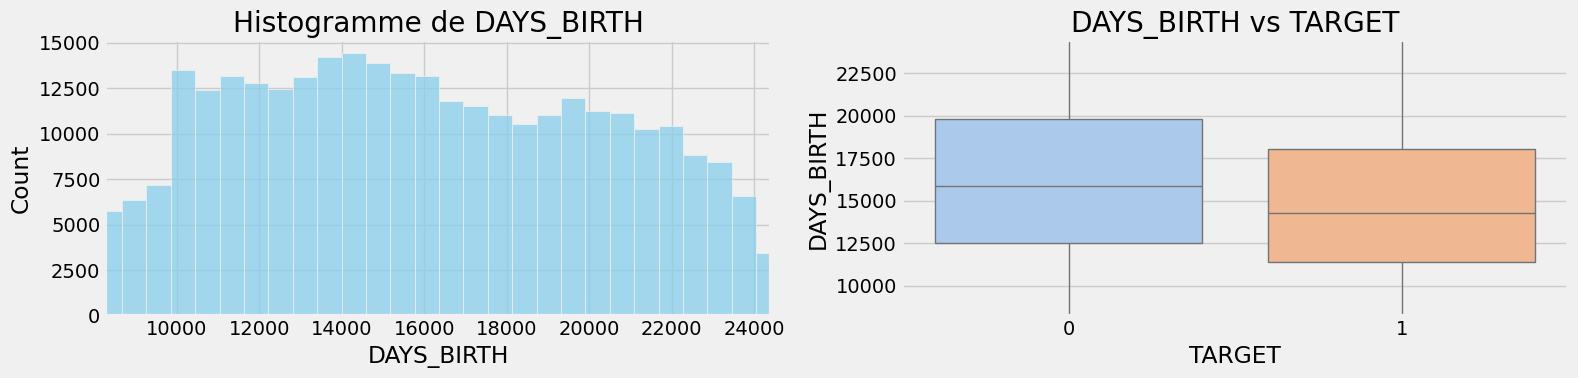

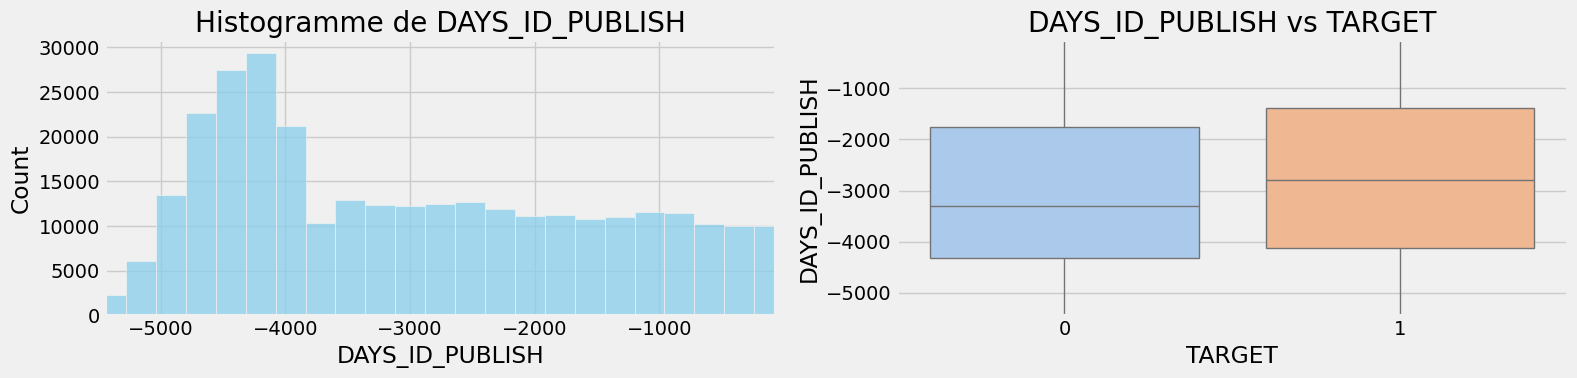

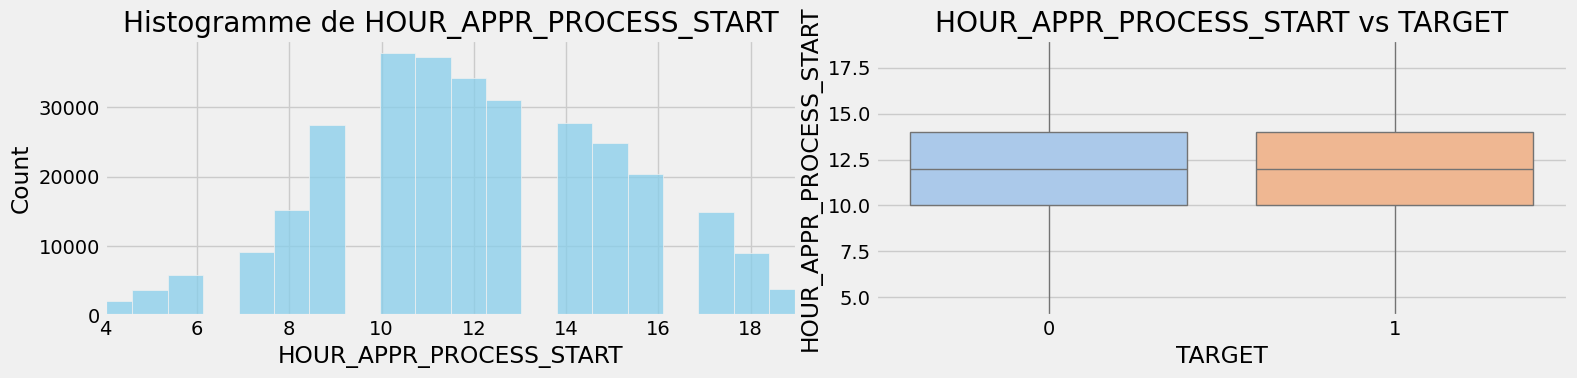

In [37]:
# Visualisation – variables INT (histogrammes + boxplots)
int_infos = pd.DataFrame(app_train.select_dtypes('int64').nunique(), columns=['n_unique'])
int_cols  = int_infos.sort_values('n_unique', ascending=False).head(4).index.tolist()

for col in int_cols:
    series = app_train[col].dropna()
    low, high = series.quantile(0.01), series.quantile(0.99)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # Histogramme
    sns.histplot(series, bins=30, kde=False, ax=axes[0], color='skyblue')
    axes[0].set_title(f"Histogramme de {col}")
    axes[0].set_xlim(low, high)
    axes[0].set_xlabel(col)
    
    # Boxplot par TARGET
    sns.boxplot(x='TARGET', y=col, data=app_train, ax=axes[1], showfliers=False, palette='pastel')
    axes[1].set_title(f"{col} vs TARGET")
    axes[1].set_ylim(low, high)
    axes[1].set_xlabel('TARGET')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()

Nous visualisons ici les variables entières principales. On voit par exemple que certaines, comme “DAYS_BIRTH”, couvrent des plages très larges, et les boxplots révèlent si les distributions diffèrent selon la cible. C’est utile pour repérer des variables vraiment discriminantes.

Suite de l'analyse :

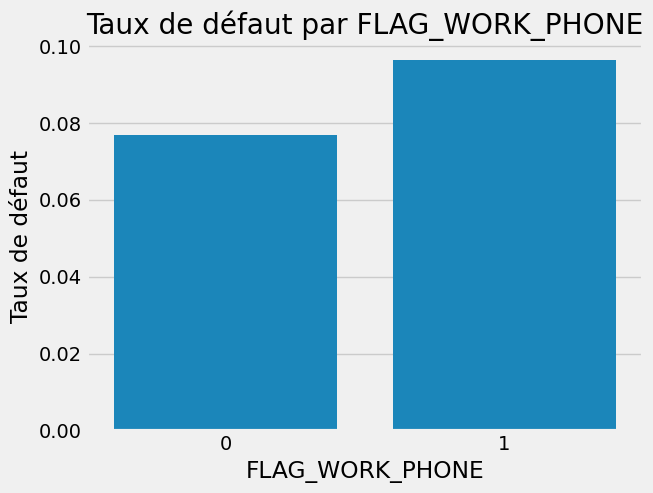

In [38]:
# Taux de défaut par FLAG_WORK_PHONE
sns.barplot(
    x='FLAG_WORK_PHONE',
    y='TARGET',
    data=app_train,
    estimator=lambda x: np.mean(x),
    ci=None
)
plt.ylabel("Taux de défaut")
plt.title("Taux de défaut par FLAG_WORK_PHONE")
plt.show()

Nous regardons ici si posséder un téléphone professionnel est lié au risque de défaut. On constate que la différence de taux est faible, donc ce critère semble peu discriminant.

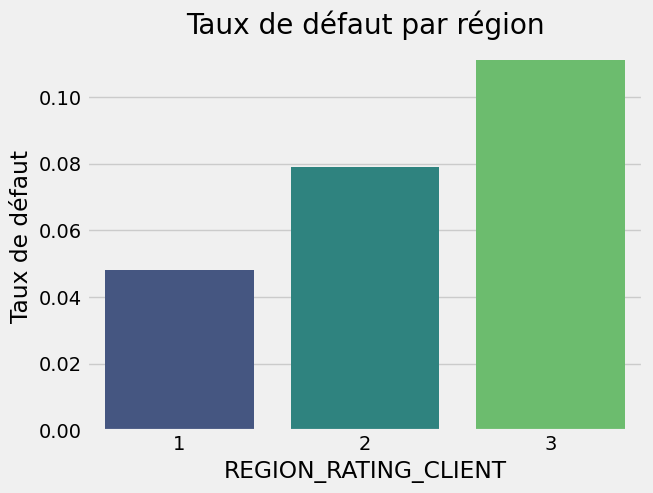

In [39]:
# Taux de défaut par REGION_RATING_CLIENT
sns.barplot(
    x='REGION_RATING_CLIENT',
    y='TARGET',
    data=app_train,
    estimator=lambda x: np.mean(x),
    ci=None,
    palette='viridis'
)
plt.ylabel("Taux de défaut")
plt.title("Taux de défaut par région")
plt.show()

Nous comparons le taux de défaut selon la “note” de la région. Plus la note est élevée, moins le taux de défaut est important. Cette variable pourra donc être utile pour le scoring.

---

Visualisation – variables FLOAT (histogrammes + boxplots) :

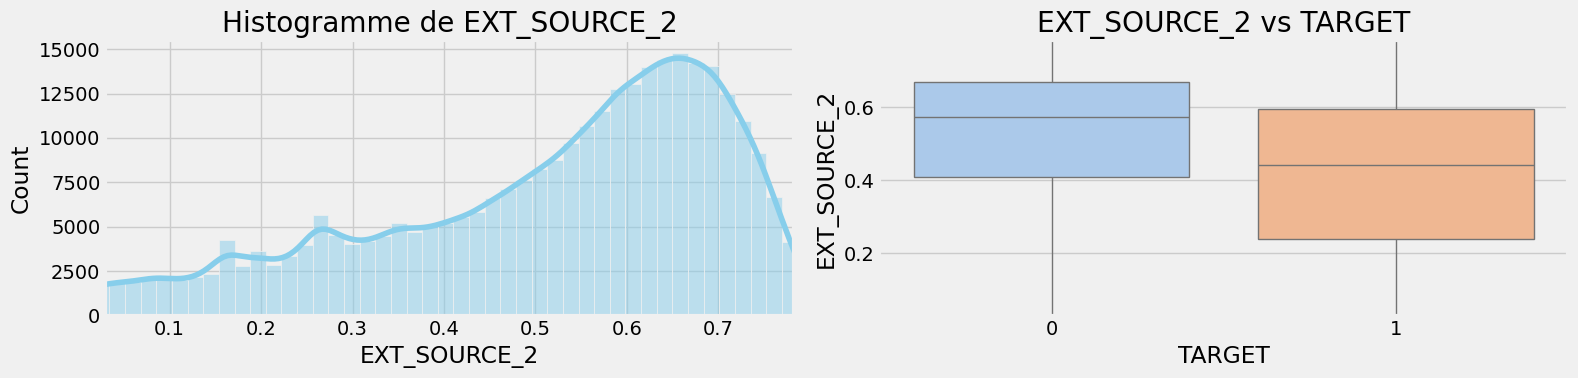

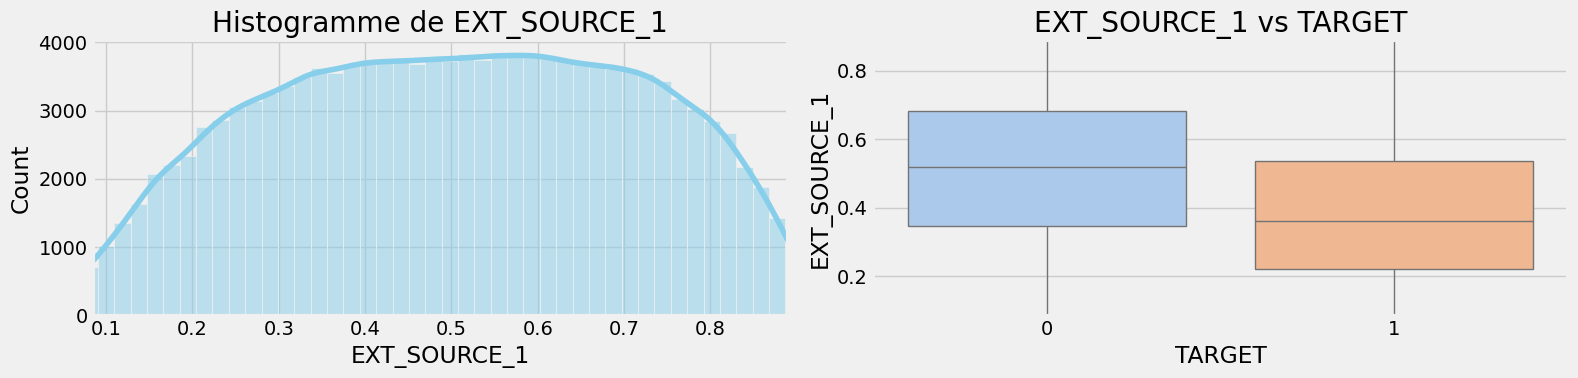

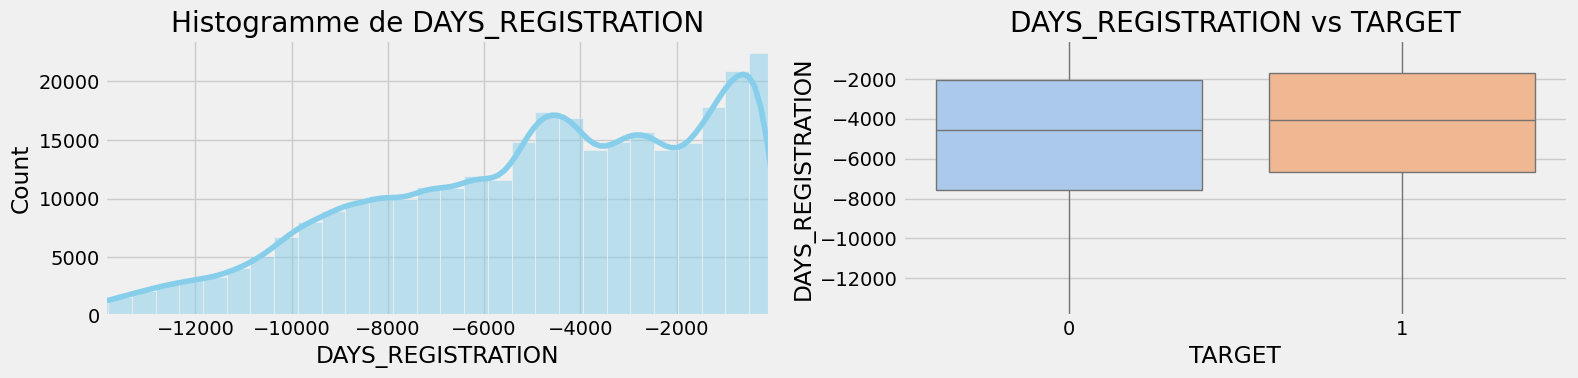

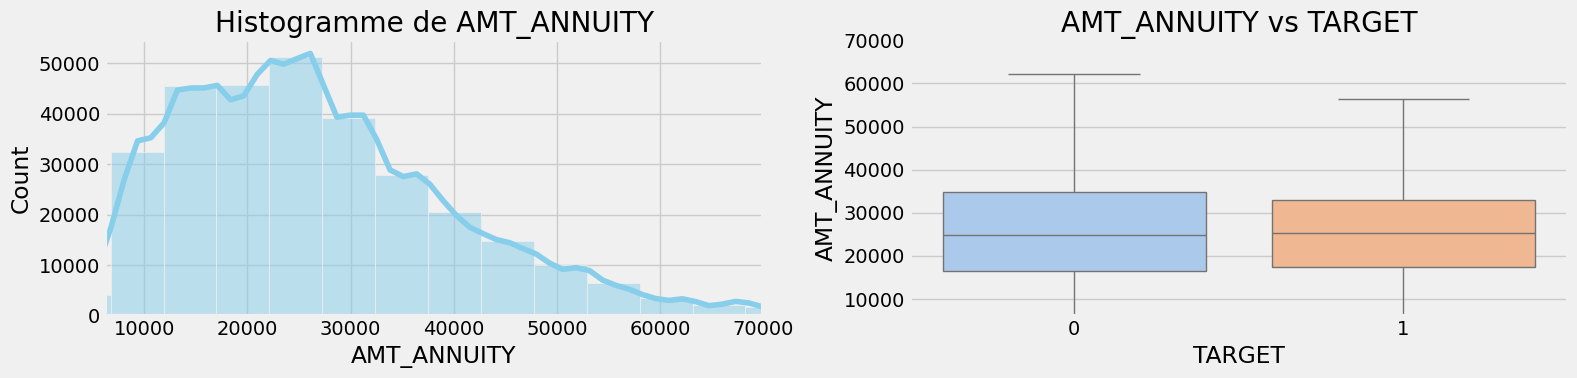

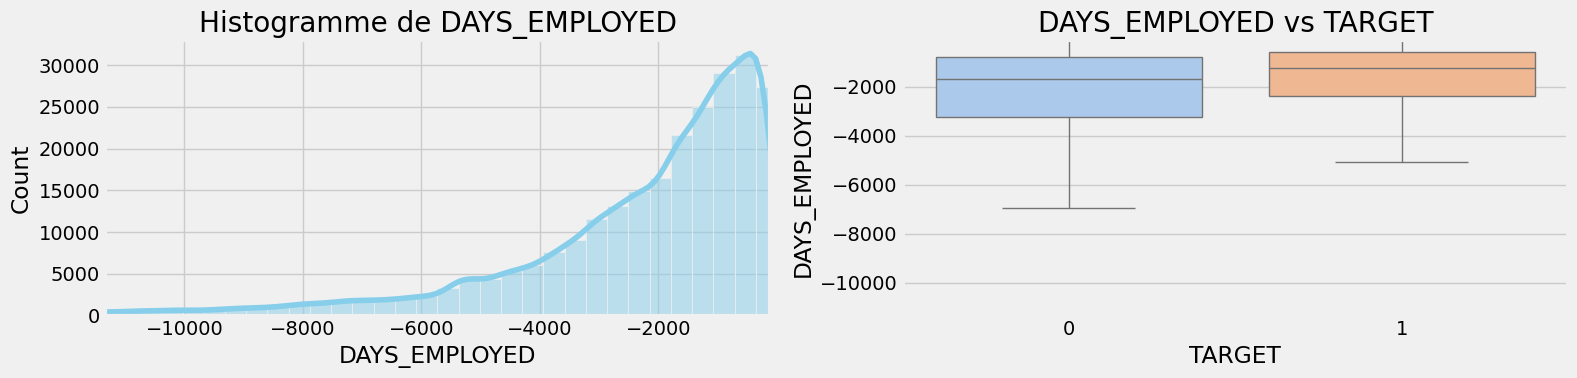

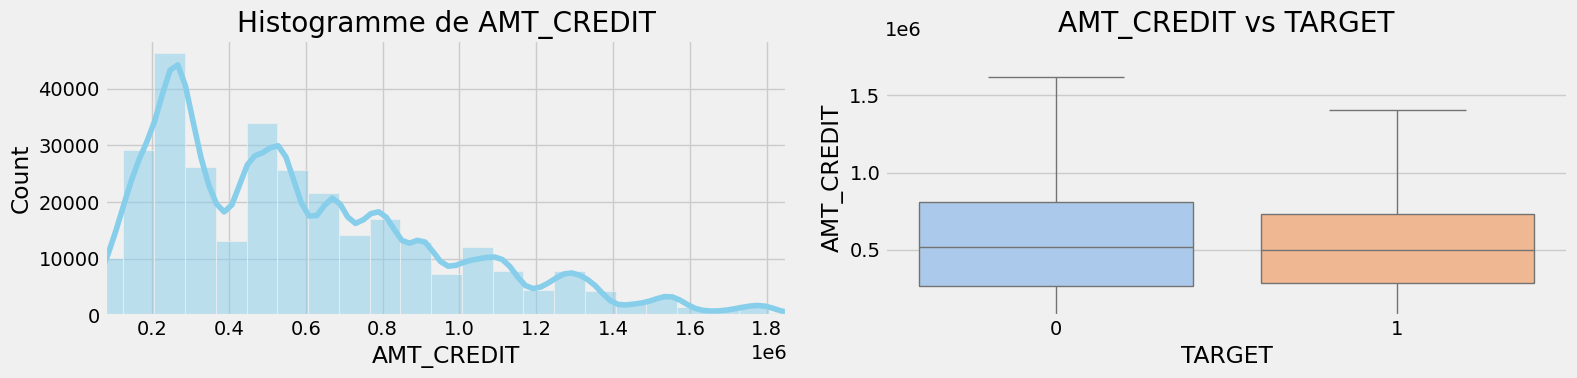

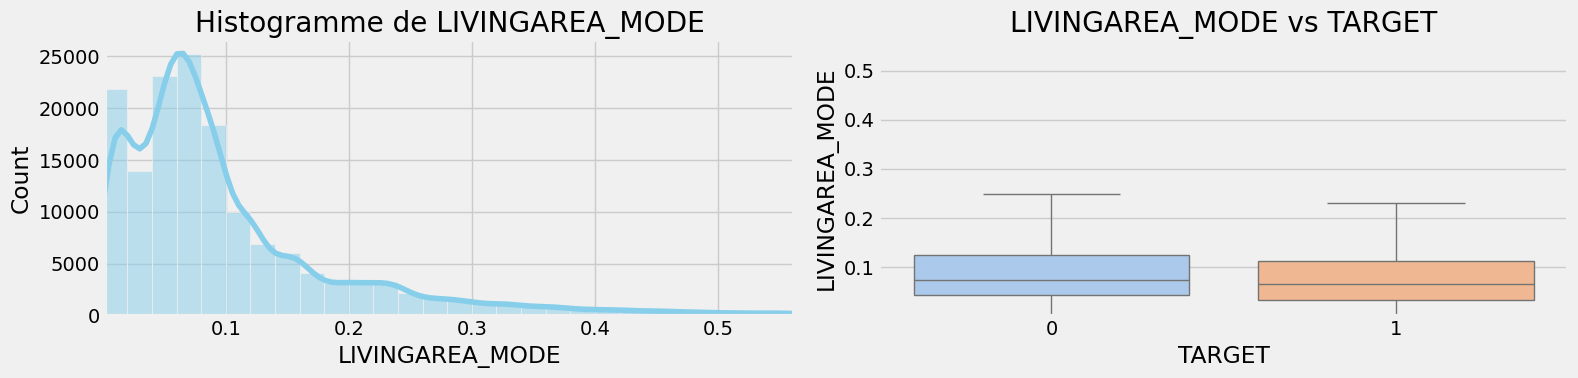

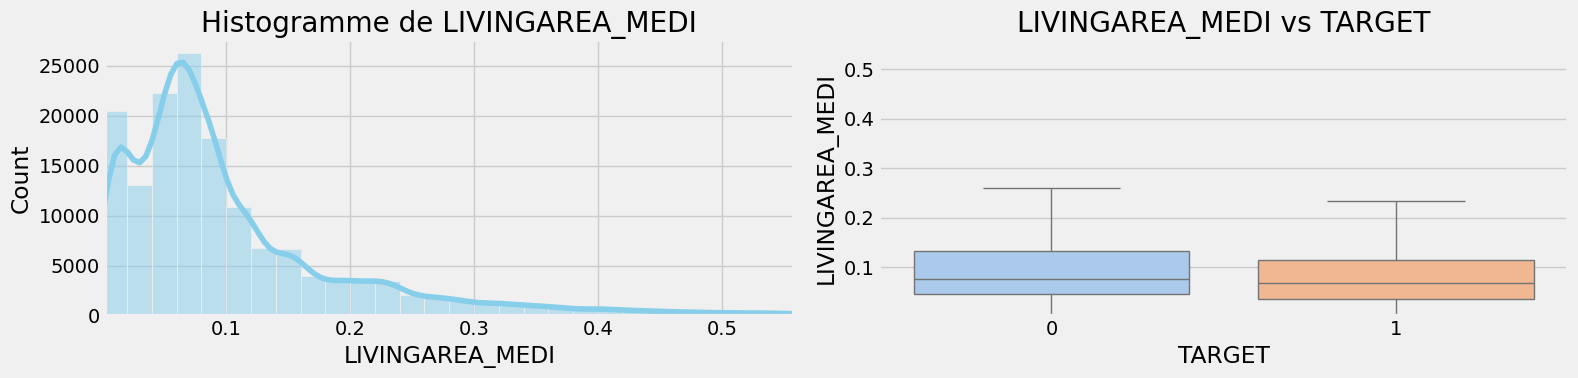

In [40]:
# Visualisation – variables FLOAT (histogrammes + boxplots)
float_infos = pd.DataFrame(app_train.select_dtypes('float64').nunique(), columns=['n_unique'])
float_cols = float_infos.sort_values('n_unique', ascending=False).head(8).index.tolist()

for col in float_cols:
    series = app_train[col].dropna()
    low, high = series.quantile(0.01), series.quantile(0.99)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    
    # histogrammes
    sns.histplot(series, bins=50, kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f"Histogramme de {col}")
    axes[0].set_xlim(low, high)
    axes[0].set_xlabel(col)
    
    # boxplots
    sns.boxplot(x='TARGET', y=col, data=app_train, ax=axes[1], showfliers=False, palette='pastel')
    axes[1].set_title(f"{col} vs TARGET")
    axes[1].set_ylim(low, high)
    axes[1].set_xlabel('TARGET')
    axes[1].set_ylabel(col)
    
    plt.tight_layout()
    plt.show()


Nous faisons la même analyse pour les variables flottantes. Certaines sont très asymétriques ou présentent des outliers, ce qui pourra demander une transformation pour le modèle.

---

Zoom sur 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE'

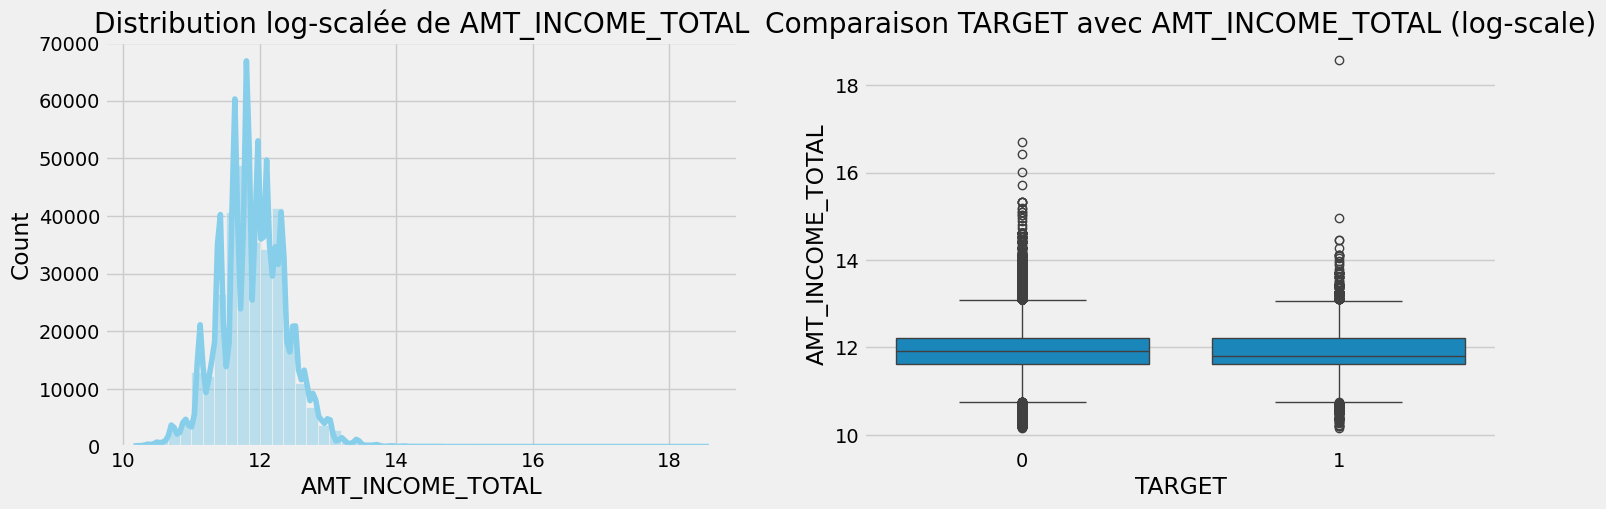

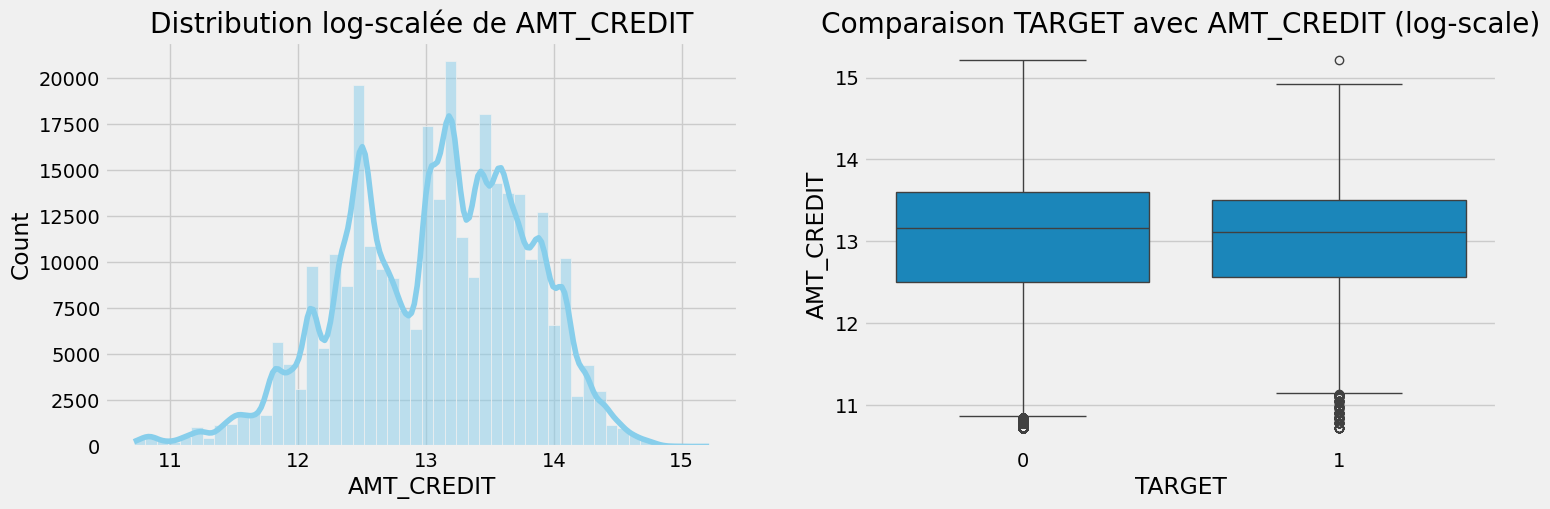

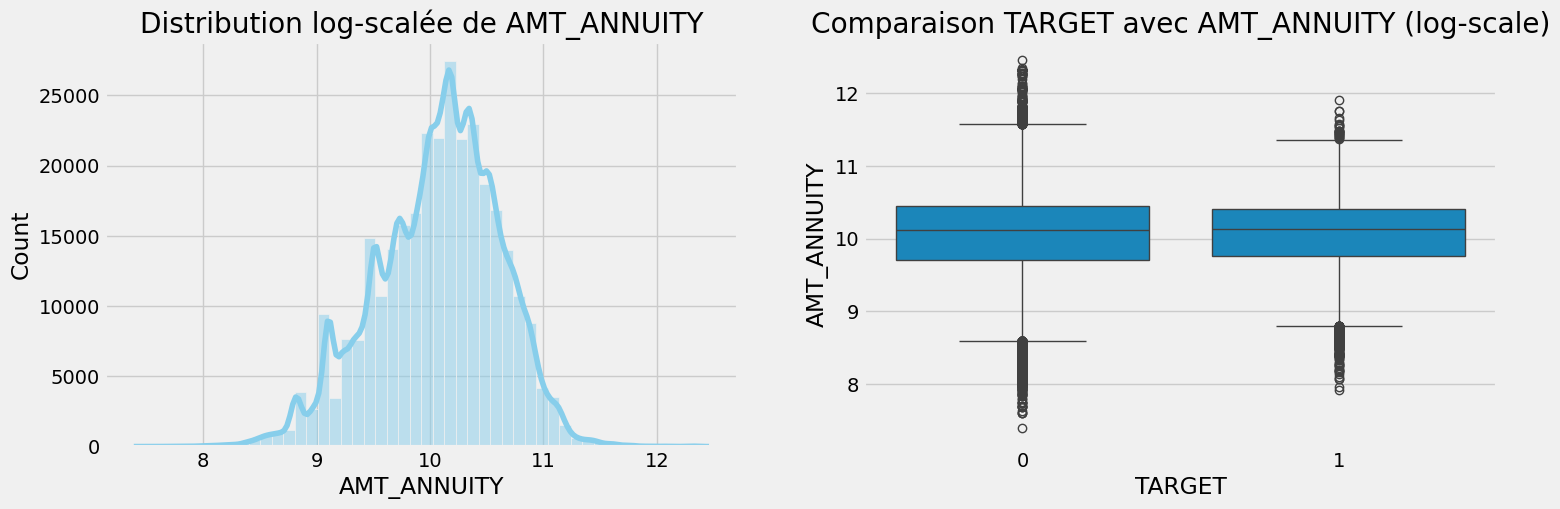

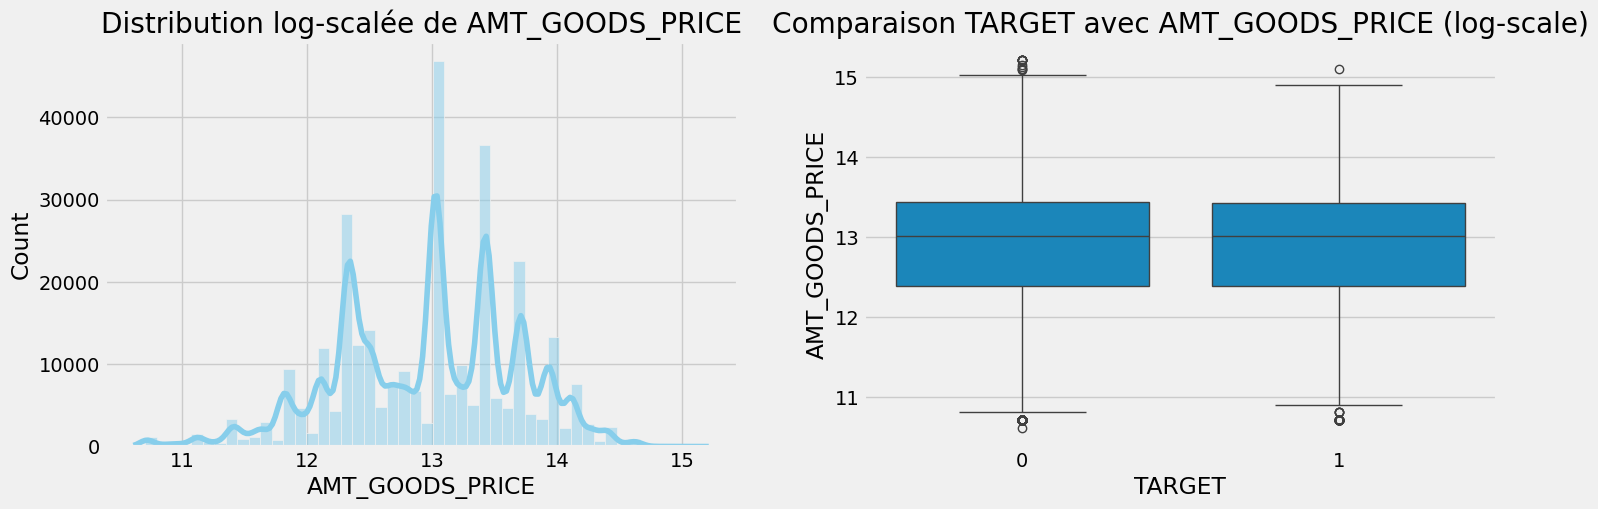

In [41]:
# Zoom sur les variables montant : log-histogrammes + boxplots
cols_num = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE']

for col in cols_num:
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    sns.histplot(np.log(app_train[col] + 1), kde=True, ax=ax[0], bins=50, color='skyblue')
    ax[0].set_title(f'Distribution log-scalée de {col}')
    
    sns.boxplot(x='TARGET', y=np.log(app_train[col] + 1), data=app_train, ax=ax[1])
    ax[1].set_title(f'Comparaison TARGET avec {col} (log-scale)')
    plt.show()

Nous visualisons les montants principaux sur une échelle logarithmique, ce qui permet de mieux voir les différences entre clients, même avec des valeurs extrêmes. Les boxplots montrent que le montant du crédit ou de l’annuité est un peu plus élevé pour les dossiers qui font défaut, mais la séparation reste faible.

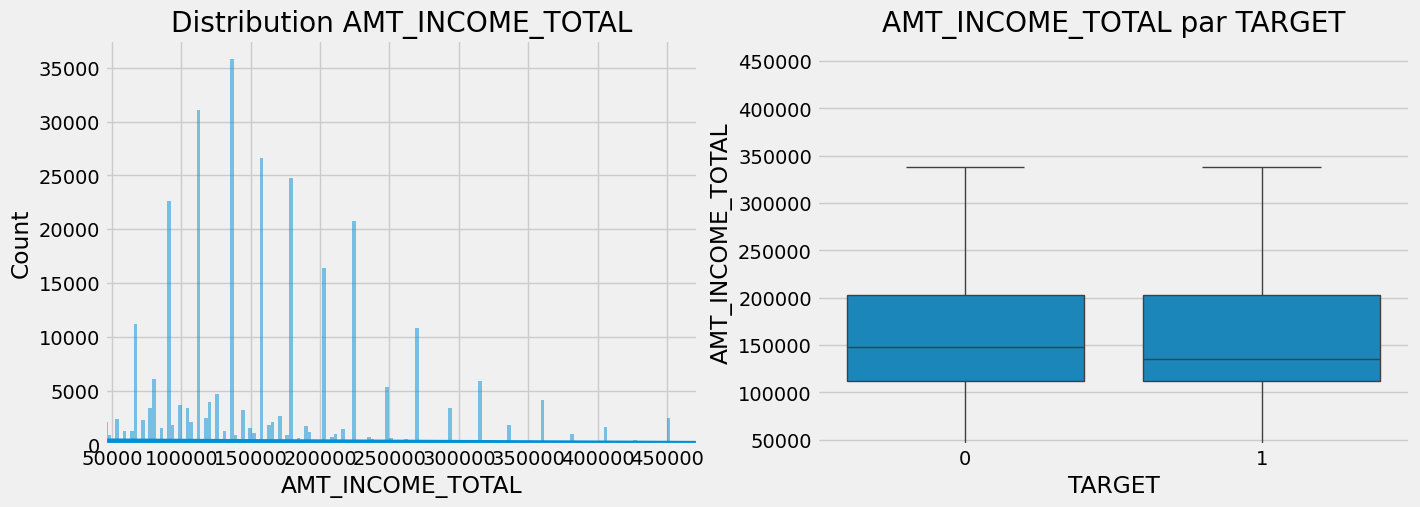

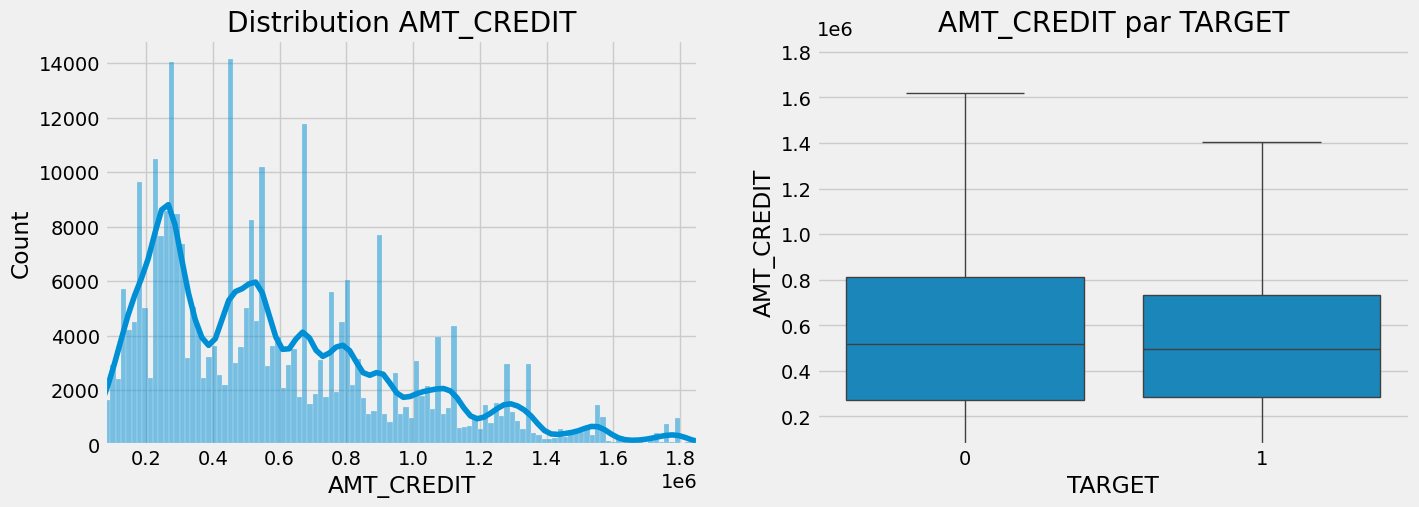

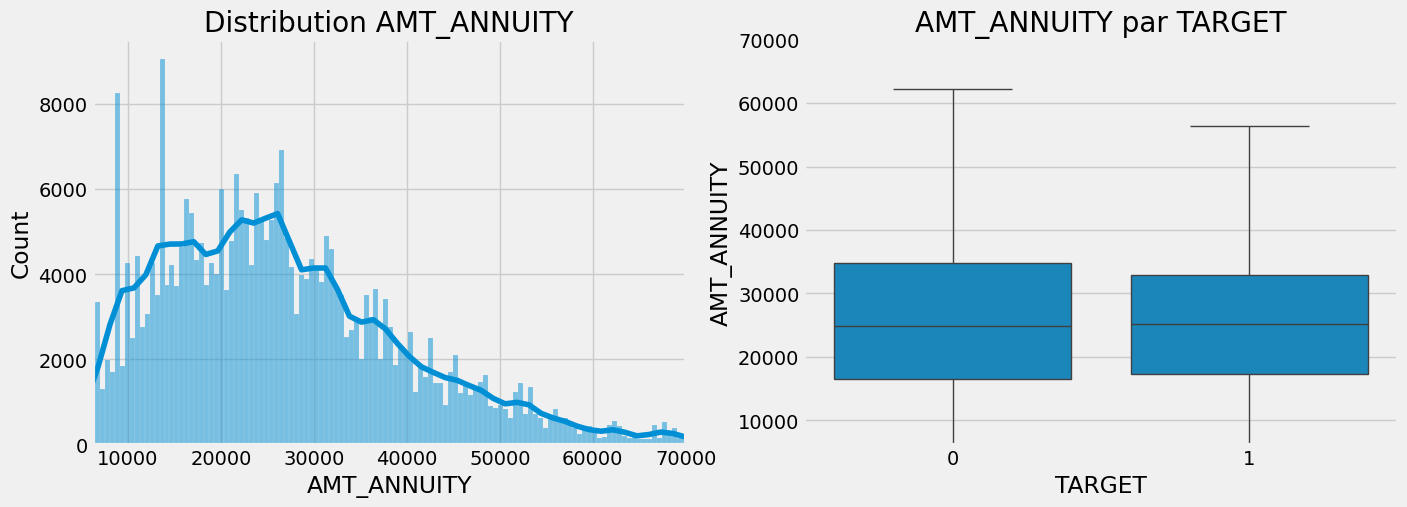

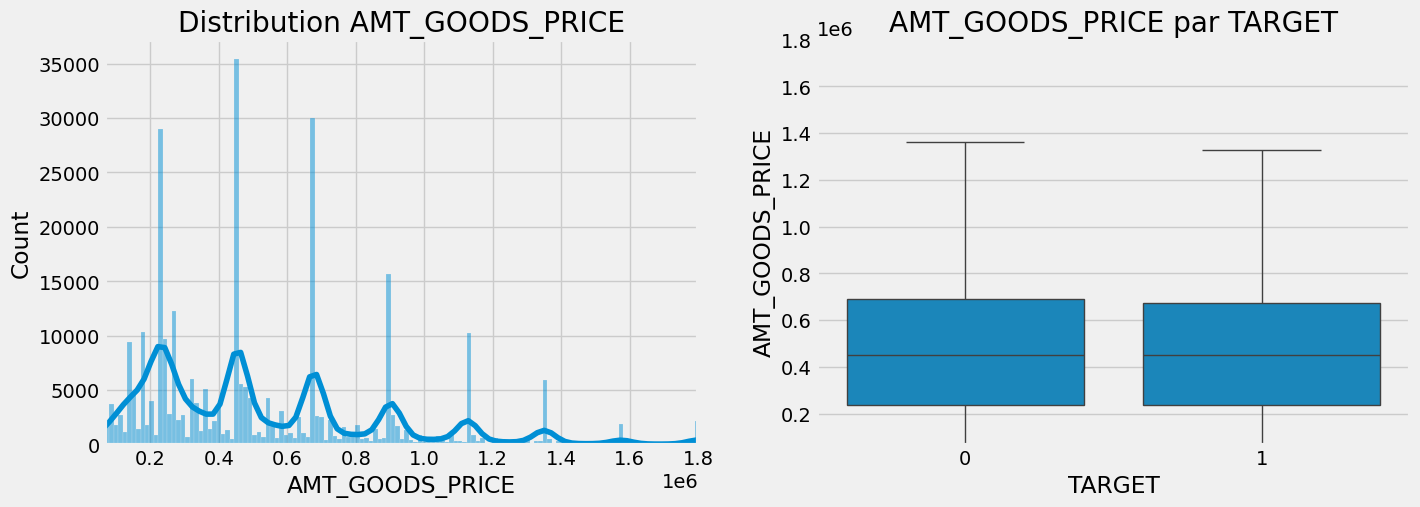

In [42]:
# Zoom sur les variables montant : histogrammes et boxplots bruts (échelle normale)
cols_num = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',]

for col in cols_num:
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.histplot(app_train[col], kde=True, ax=ax[0])
    ax[0].set_title(f'Distribution {col}')
    ax[0].set_xlim(app_train[col].quantile(0.01), app_train[col].quantile(0.99))
    
    sns.boxplot(x='TARGET', y=col, data=app_train, ax=ax[1], showfliers=False)
    ax[1].set_title(f'{col} par TARGET')
    ax[1].set_ylim(app_train[col].quantile(0.01), app_train[col].quantile(0.99))
    plt.show()

Nous regardons les mêmes variables sans transformation. Les distributions sont très étirées : d’où l’intérêt du log. Les différences de montants restent limitées entre clients remboursant et non-remboursant.

---

---

#### Encodage des variables catégorielles

Avant d’aller plus loin, il faut gérer les variables catégorielles : un modèle de machine learning ne peut pas les exploiter directement (sauf certains comme LightGBM). 

Il faut donc les convertir en valeurs numériques avant l’entraînement. Deux méthodes principales existent :

- Encodage par étiquette (label encoding) : on associe un entier à chaque modalité unique, sans créer de nouvelles colonnes.

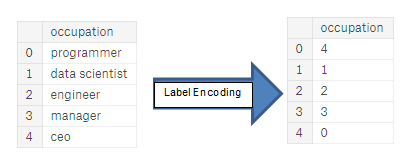

- Encodage à chaud (Encodage one-hot) : créer une colonne par modalité unique d’une variable catégorielle ; chaque observation reçoit 1 dans la colonne correspondant à sa catégorie et 0 dans toutes les autres.

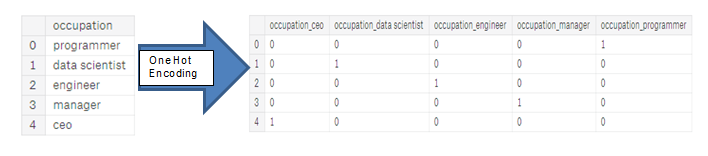

Le label encoding pose un problème : il crée un ordre arbitraire entre les modalités (par ex. programmer = 4 et data scientist = 1), ce qui peut conduire le modèle à exploiter cette hiérarchie fictive. Pour seulement deux modalités (ex. Male/Female), c’est acceptable, mais au-delà, l’encodage one-hot reste la solution la plus fiable, car il n’impose pas de valeur numérique arbitraire. 

Son inconvénient est l’explosion du nombre de variables, que l’on peut cependant maîtriser par PCA ou d’autres méthodes de réduction de dimension.



Dans ce notebook, nous appliquerons la règle suivante :

- Label encoding pour toute variable catégorielle à deux modalités, avec LabelEncoder de Scikit-Learn.

- One-hot encoding pour toute variable catégorielle à plus de deux modalités, avec pandas.get_dummies().

Cette approche pourra évoluer dans les itérations suivantes, notamment si nous devons réduire la dimensionnalité.

In [43]:
# Encodage des variables catégorielles : label encoding et one-hot
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [44]:
# One-hot encoding pour le reste
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 244)
Testing Features shape:  (48744, 239)


Nous transformons les variables catégorielles : label encoding pour celles à 2 modalités, one-hot encoding pour les autres. C’est indispensable avant d’attaquer la modélisation.

Nous constatons que le nombre de variables explose après encodage. On vérifie aussi que train et test ont des tailles cohérentes.

---

#### Alignement des données d'entraînement et de test

Les jeux d’entraînement et de test doivent partager les mêmes colonnes. L’encodage one-hot a ajouté des colonnes au jeu d’entraînement pour des modalités absentes du jeu de test. Pour les supprimer, on extrait d’abord la colonne cible du jeu d’entraînement (absente du test), puis on aligne les DataFrames avec axis=1 afin de synchroniser les colonnes, et non les lignes.

In [45]:
# Alignement des colonnes entre train et test
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


Les jeux d’entraînement et de test ont désormais les mêmes variables, indispensable pour l’apprentissage automatique. Leur nombre a considérablement augmenté avec l’encodage one-hot. Il sera pertinent d’envisager une réduction de dimensionnalité pour supprimer les variables peu utiles et alléger les jeux de données.

---

---

# Feature Engineering

La réussite tient avant tout au Feature Engineering : les gagnants sont ceux qui parviennent à extraire les variables les plus pertinentes des données. C’est particulièrement vrai pour les données structurées, où les modèles vainqueurs sont généralement des variantes de gradient boosting. 

On observe en pratique que le Feature Engineering offre un meilleur retour sur investissement que le choix du modèle ou l’optimisation des hyperparamètres. Comme le répète souvent Andrew Ng : « Le machine learning appliqué, c’est avant tout du Feature Engineering. »

Choisir le bon modèle et ajuster ses paramètres reste important, mais un modèle n’apprend que sur des données de qualité : c’est au data scientist de s’assurer que ces données sont les plus pertinentes possibles, avec l’aide éventuelle d’outils automatisés.

--- 

Feature Engineering couvre deux aspects :

- La construction de variables : créer de nouvelles caractéristiques à partir des données existantes,

- La sélection de variables : ne retenir que les plus utiles ou réduire la dimensionnalité.


De nombreuses techniques existent pour ces deux étapes. Dans ce notebook, nous nous limiterons à deux méthodes simples de construction de variables :

- les caractéristiques polynomiales

- les variables issues de l’expertise métier.

#### Polynomial Features :

Une méthode simple de construction de variables consiste à générer des caractéristiques polynomiales. Elle crée à la fois des puissances des variables existantes (par exemple EXT_SOURCE_1², EXT_SOURCE_2²) et des termes d’interaction (comme EXT_SOURCE_1 × EXT_SOURCE_2, EXT_SOURCE_1 × EXT_SOURCE_2², EXT_SOURCE_1² × EXT_SOURCE_2², etc.).

 Ces termes d’interaction peuvent révéler une influence sur la cible que les variables individuelles n’affichent pas : deux variables faiblement corrélées prise séparément peuvent, une fois combinées, montrer une relation plus marquée. 
 
 Bien que courants en statistiques, ces termes sont moins fréquents en machine learning, mais méritent d’être testés pour améliorer la prédiction du remboursement.


Dans le code suivant, nous appliquons cette méthode aux variables EXT_SOURCE et DAYS_BIRTH en utilisant PolynomialFeatures de Scikit-Learn. Cette classe génère automatiquement toutes les puissances et interactions jusqu’à un degré spécifié. Nous choisissons ici un degré 3 pour limiter l’explosion du nombre de variables et réduire le risque de surapprentissage.

Ajout d'import: 

In [46]:
# Import des outils pour les features polynomiales et le scaling
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [47]:
# Création des features polynomiales sur EXT_SOURCE et DAYS_BIRTH
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# Imputation des valeurs manquantes par la médiane
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

# Génération des features polynomiales degré 3
poly_transformer = PolynomialFeatures(degree = 3)

In [48]:
# Entrainemeznt des features
poly_transformer.fit(poly_features)

# Transformationn des features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


Nous générons 35 nouvelles variables issues des interactions et puissances jusqu’au degré 3. On peut ainsi capturer des effets croisés non visibles dans les variables originales.

In [49]:
# Affichage des noms des nouvelles variables créées
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

On récupère les noms de toutes les variables polynomiales obtenues. Cela permet d’identifier rapidement les nouvelles interactions. Il ne reste plus qu’à vérifier lesquelles de ces nouvelles variables sont corrélées à la cible.

In [50]:
# Création d’un DataFrame polynomiale et analyse des corrélations avec la cible
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['TARGET'] = poly_target

poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Affichage des plus negative et des plus positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


Plusieurs de ces nouvelles variables affichent une corrélation absolue plus forte avec la cible que les variables d’origine. Lors de la construction des modèles, on peut donc comparer les performances avec et sans ces nouvelles caractéristiques pour mesurer leur apport.

Nous allons ajouter ces variables à une copie des jeux d’entraînement et de test, puis évaluer les modèles avec et sans elles. En machine learning, la meilleure façon de savoir si une méthode fonctionne est souvent de l’expérimenter directement.

In [51]:
# Fusion des features polynomiales avec les datasets train/test (par SK_ID_CURR)
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Alignement des jeux d'entraînement et de test
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 274)
Testing data with polynomial features shape:   (48744, 274)


On ajoute ces nouvelles variables aux jeux de données d’entraînement et de test, ce qui augmente considérablement la dimension mais peut enrichir la modélisation.

---

#### Domain Knowledge Features

Il n’est pas tout à fait exact de parler de « connaissances métier », puisque je ne suis pas expert en crédit ; on peut plutôt qualifier cela de « tentatives d’application d’une connaissance financière limitée ». 

Dans cet esprit, nous créons cinq variables inspirées du script d’Aguiar pour repérer le risque de défaut :

- CREDIT_INCOME_PERCENT : pourcentage du montant du crédit par rapport au revenu du client

- ANNUITY_INCOME_PERCENT : pourcentage de l’annuité mensuelle par rapport au revenu du client

- CREDIT_TERM : durée du remboursement en mois (l’annuité étant le montant mensuel dû)

- DAYS_EMPLOYED_PERCENT : proportion des jours travaillés par rapport à l’âge du client


In [52]:
# Création de variables métier
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [53]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

On ajoute ici des ratios simples mais souvent très informatifs, comme le poids de la mensualité sur le revenu. Ces variables sont faciles à expliquer et à interpréter par les équipes métier.

---

Explorons ces indicateurs issus de la connaissance métier à l’aide d’un graphique KDE.

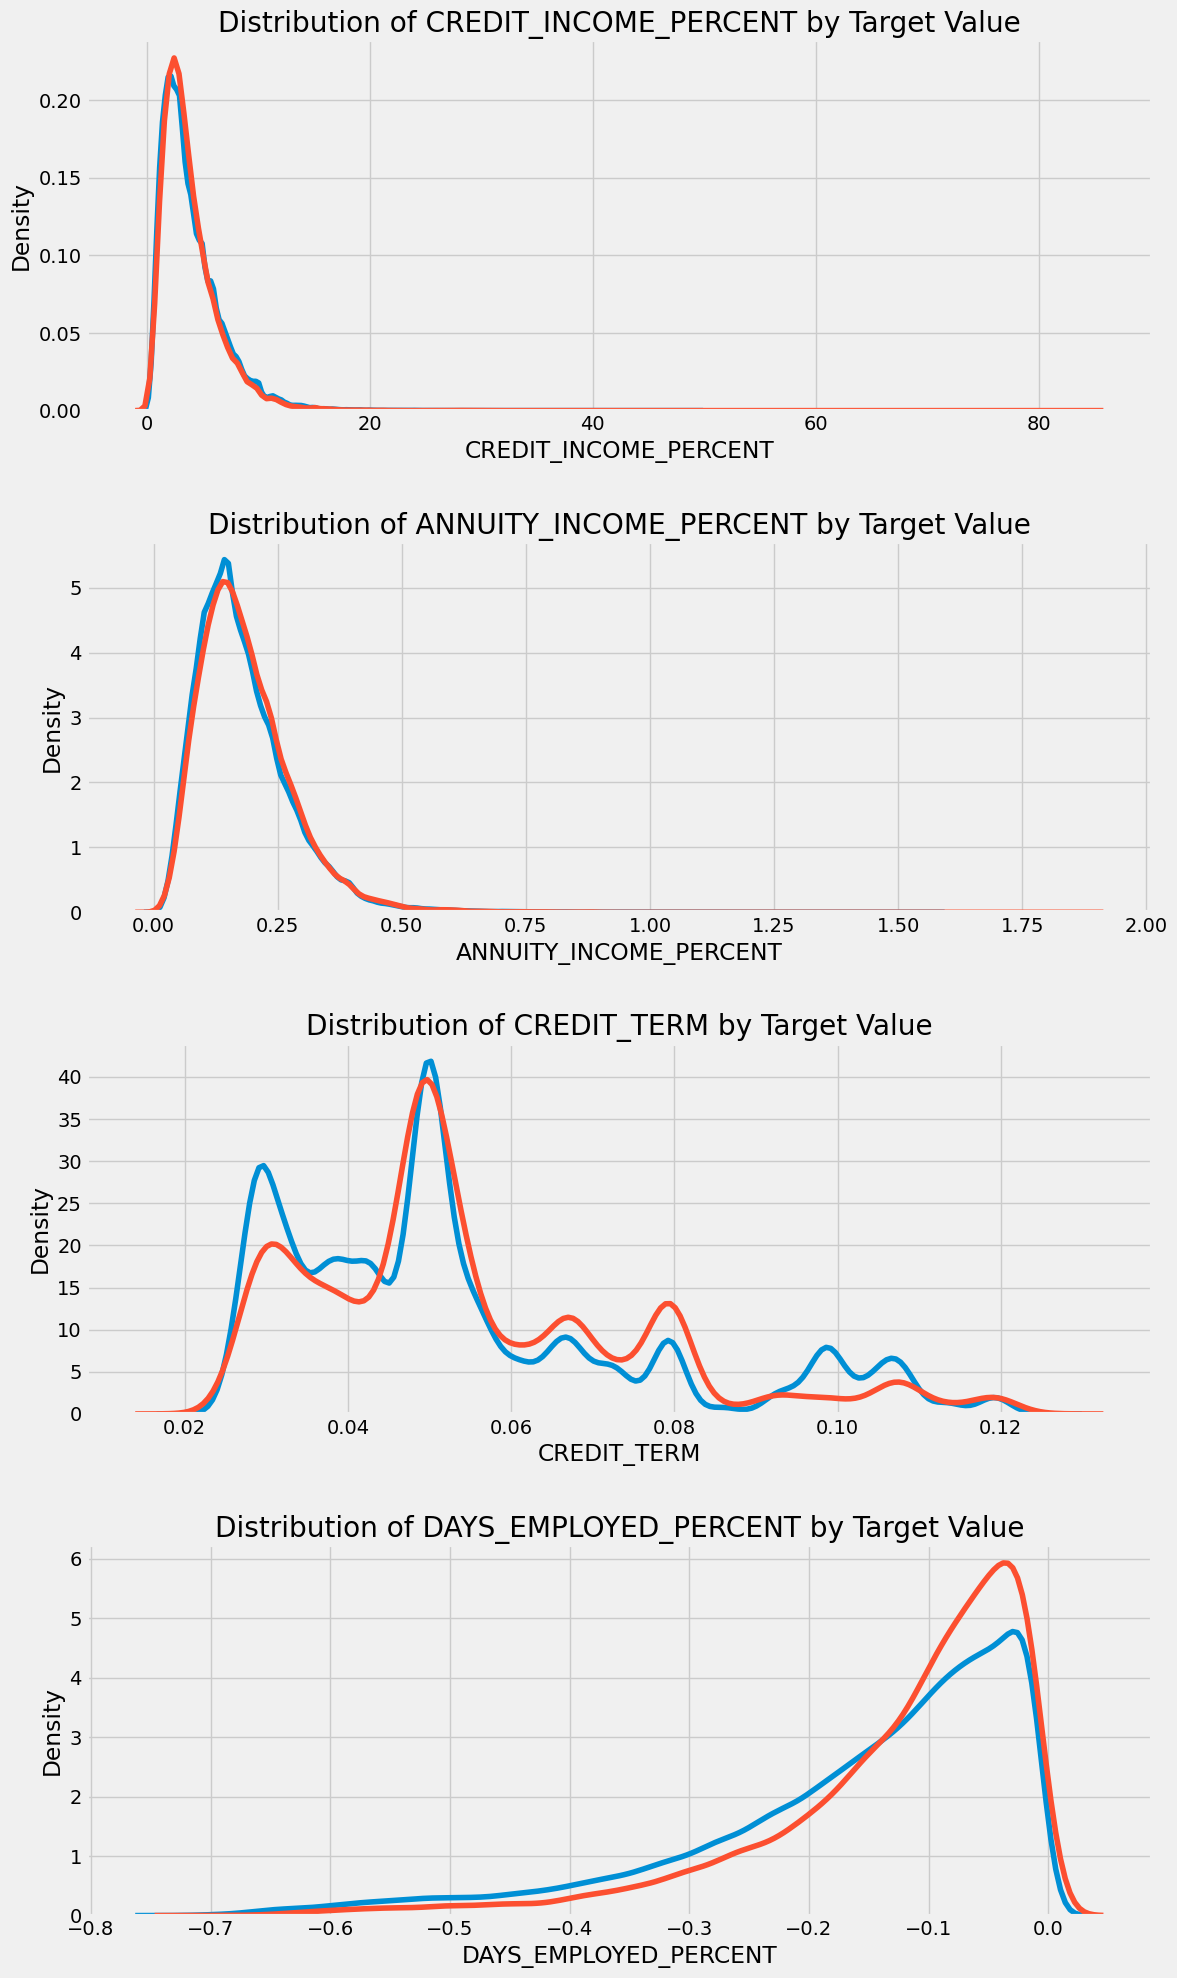

In [54]:
# Visualisation des nouvelles variables métier par rapport à la cible
plt.figure(figsize = (12, 20))
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    
    plt.subplot(4, 1, i + 1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')
    
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)

ICI -> Rouge = Target 1 = Non rembourser à temps && Bleu = Target 0 = Rembourser à temps

On voit que certaines de ces variables distinguent bien les deux groupes. Par exemple, le ratio crédit/revenu est souvent plus élevé chez les clients qui font défaut. On garde ces indicateurs pour la suite.

Il reste difficile de prédire a priori l’utilité de ces nouvelles variables. La seule manière d’en être sûr est de les tester plus présentement !

---

### Premier Test en situation

#### Baseline

Pour un repère naïf, on pourrait attribuer la même prédiction à toutes les observations du jeu de test. Ici, on prédit la probabilité de défaut : en cas d’incertitude, on choisit 0,5 pour chaque cas, ce qui donne un AUC ROC de 0,5 (tirage aléatoire).

Ce score étant connu d’avance, un repère naïf est inutile. Prenons pour baseline un modèle plus élaboré : la régression logistique.

#### Logistic Regression Implementation

Je vais ici me concentrer sur l’implémentation du modèle plutôt que sur la théorie.
Pour établir notre baseline, nous exploiterons toutes les variables après encodage des catégories. Nous prétraiterons les données en :

- Imputant les valeurs manquantes

- Normalisant l’échelle des variables (feature scaling)

Le code suivant effectue ces deux étapes.

In [55]:
# Baseline : régression logistique simple
# On prépare les données (imputation des NaN, normalisation)
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()
    
features = list(train.columns)

test = app_test.copy()

imputer = SimpleImputer(strategy = 'median')

scaler = MinMaxScaler(feature_range = (0, 1))

imputer.fit(train)

train = imputer.transform(train)
test = imputer.transform(app_test)

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 239)
Testing data shape:  (48744, 239)


Nous traitons les valeurs manquantes par la médiane et normalisons les variables. On prépare les données pour la modélisation.

Nous utilisons la classe LogisticRegression de Scikit-Learn pour notre premier modèle. Nous n’ajustons qu’un seul paramètre par rapport aux réglages par défaut : nous diminuons la régularisation C pour réduire le surapprentissage. 

Cette modification améliore légèrement la performance tout en conservant un point de référence bas pour nos futurs modèles.

Nous appliquons la syntaxe Scikit-Learn habituelle :

- Instanciation du modèle

- Entraînement avec .fit()

- Prédiction des probabilités de défaut sur le jeu de test avec .predict_proba() (nous récupérons les probabilités et non un label binaire).

In [56]:
# Entraînement du modèle de régression logistique (baseline)
log_reg = LogisticRegression(C = 0.0001)

log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

Nous entraînons notre premier modèle simple. Cette baseline va servir de point de comparaison pour la suite.

In [57]:
# Instanciation détaillée du modèle Logistic Regression (tous les paramètres affichés)
LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

# Entraînement sur les données préparées
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001)

Nous paramétrons le modèle avec une régularisation forte pour limiter l’overfitting, puis on l’entraîne sur tout le jeu d’apprentissage. C’est notre baseline simple et robuste.



Une fois le modèle entraîné, on utilise predict_proba pour obtenir les probabilités de défaut. Cette méthode renvoie un tableau de taille m×2 (m = nombre d’observations) :

- colonne 1 : probabilité que la cible soit 0

- colonne 2 : probabilité que la cible soit 1

Pour estimer le risque de non-remboursement (target = 1), on sélectionne la deuxième colonne. Le code ci-dessous réalise ces prédictions et extrait la colonne correspondante.

In [58]:
# Prédiction des probabilités de défaut sur le jeu de test
log_reg_pred = log_reg.predict_proba(test)[:, 1]

On récupère la probabilité de défaut pour chaque dossier. Cela va servir pour les évaluations AUC, score métier, etc.

In [59]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head(50)

SK_ID_CURR    TARGET
0       100001  0.078497
1       100005  0.137631
2       100013  0.082206
3       100028  0.080830
4       100038  0.132673
5       100042  0.064081
6       100057  0.094519
7       100065  0.109382
8       100066  0.055084
9       100067  0.093801
10      100074  0.209679
11      100090  0.124805
12      100091  0.117421
13      100092  0.110410
14      100106  0.132674
15      100107  0.103648
16      100109  0.112314
17      100117  0.234812
18      100128  0.074139
19      100141  0.107173
20      100150  0.079179
21      100168  0.066443
22      100169  0.137531
23      100170  0.090510
24      100171  0.108686
25      100172  0.133995
26      100184  0.216977
27      100187  0.071238
28      100212  0.087808
29      100222  0.102770
30      100223  0.063718
31      100232  0.074976
32      100241  0.135751
33      100245  0.078592
34      100253  0.066768
35      100256  0.101580
36      100271  0.179831
37      100278  0.120614
38      100280  0.073177
39      100306  0.141253
40      100311  0.120499
41      100312  0.189727
42      100330  0.090454
43      100331  0.106564
44      100352  0.096501
45      100358  0.116223
46      100367  0.100031
47      100382  0.085407
48      100384  0.079025
49      100385  0.101799

Les prédictions donnent la probabilité (entre 0 et 1) qu’un prêt ne soit pas remboursé. Pour en faire une décision binaire, on peut fixer un seuil de probabilité au-delà duquel on considère le prêt comme risqué.

La baseline en régression logistique devrait obtenir un score d’environ 0,671 lors de la soumission.

---


#### Modèle amélioré : Random Forest

Pour améliorer les performances limitées de notre baseline, changeons d’algorithme. Testons un Random Forest sur les mêmes données d’entraînement pour en mesurer l’impact. Ce modèle est bien plus puissant, surtout avec plusieurs centaines ; nous en utiliserons 100.

In [60]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

Nous instancions et entraînons un modèle Random Forest avec 100 arbres sur l’ensemble d’entraînement. Ce modèle peut mieux capter les interactions que la régression logistique.

In [61]:
# Entraînement du modèle Random Forest sur l'ensemble d'entraînement
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Nous prédisons la probabilité de défaut pour chaque client du jeu de test avec le modèle Random Forest.

In [62]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index = False)

Nous créons le DataFrame de soumission contenant les identifiants et les probabilités prédites, comme attendu pour l’évaluation. Que nous enregistrons dans le fichier de soumission.



Ces prédictions seront accessibles après exécution complète du notebook.
Ce modèle devrait obtenir un score d’environ 0,678 lors de la soumission.

---

#### Faire des prédictions à l'aide de fonctionnalités techniques

La seule façon de vérifier si les caractéristiques polynomiales et la connaissance métier ont amélioré le modèle est d’en entraîner un avec ces nouvelles variables, puis de comparer ses résultats à ceux du modèle sans ces features pour évaluer l’apport de notre Features Engineering.

In [63]:
# On prépare la liste des features polynomiales
poly_features_names = list(app_train_poly.columns)

# On prépare la liste des features polynomiales
imputer = SimpleImputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

# Instanciation et entraînement du Random Forest sur les features polynomiales
random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

Nous préparons les features polynomiales pour les modèles : gestion des valeurs manquantes puis normalisation.
On entraîne un Random Forest sur les variables polynomiales pour voir si elles apportent une réelle plus-value sur le score final.

In [64]:
random_forest_poly.fit(poly_features, train_labels)

# Prédiction sur le jeu de test avec le modèle polynomial
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


Nous générons les probabilités de défaut selon ce modèle enrichi de features polynomiales.

In [65]:
# Création du DataFrame de soumission et sauvegarde CSV
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

submit.to_csv('random_forest_baseline_engineered.csv', index = False)

Ce modèle a obtenu un score de 0,678 lors de la soumission, identique à celui sans les variables créées. Ces résultats montrent que cela n’a pas apporté d’amélioration dans ce cas.

---

#### Test des variables métier

Nous pouvons désormais évaluer les variables métier créées manuellement.

In [66]:
# Préparation des features "métier" (domain features)
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Imputation puis scaling des features métier
imputer = SimpleImputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

# Random Forest sur les variables métier + importance des features
random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

random_forest_domain.fit(domain_features, train_labels)

feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Prédiction sur le test avec le modèle métier + export
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.5s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.0s finished


On entraîne un modèle Random Forest uniquement sur les variables métier et on extrait leur importance pour évaluer leur poids dans la prédiction.

In [67]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_domain.csv', index = False)

Ce modèle obtient un score de 0,679. Le score reste équivalent à la baseline, donc ces variables seules n’améliorent pas le modèle ici, mais seront utiles avec d’autres algos.

Dans le prochain notebooks, nous en ferons d'avantage avec différents autres modèles.

---

#### Interprétation de modèle : importance des Features (Model Interpretation: Feature Importances)

Pour identifier les variables clés, examinons les importances de features du Random Forest. D’après notre analyse exploratoire, ce sont les EXT_SOURCE et DAYS_BIRTH qui devraient dominer. Nous pourrons ensuite nous appuyer sur ces importances pour réduire la dimensionnalité ultérieurement.

In [68]:
# Affiche les 15 features les plus importantes, avec leur importance normalisée.
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

Cette fonction permet de visualiser rapidement quelles sont les variables qui pèsent le plus dans un modèle donné.

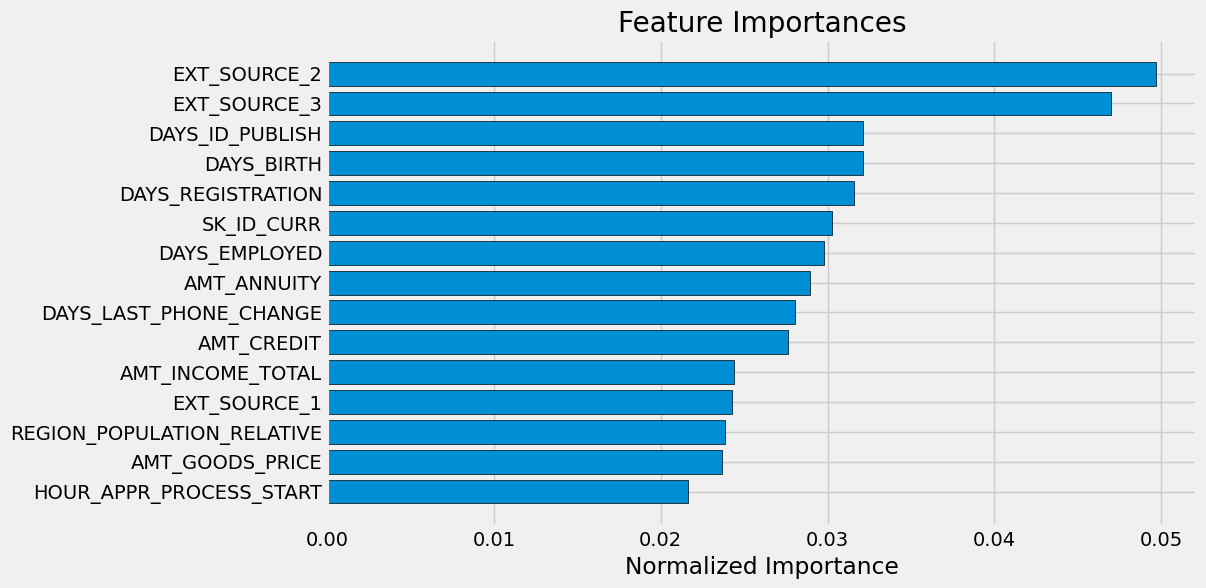

In [69]:
# Importance des variables dans le modèle baseline
feature_importances_sorted = plot_feature_importances(feature_importances)

Comme prévu, les variables les plus importantes sont EXT_SOURCE et DAYS_BIRTH. 

Seules quelques-unes ont un poids significatif dans le modèle, ce qui suggère qu’on peut en supprimer beaucoup sans nuire à la performance — voire l’améliorer. Ce n'est pas la méthode la plus poussée pour interpréter un modèle ou réduire la dimensionnalité, mais elles offrent un premier aperçu des facteurs qui influencent ses prédictions.

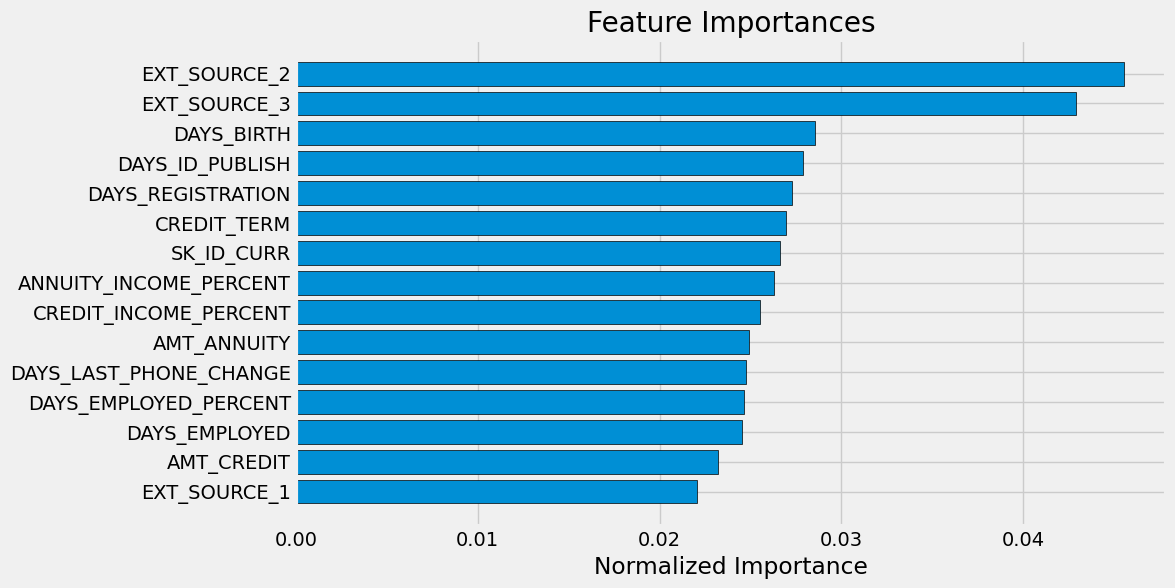

In [70]:
# Importance des variables dans le modèle métier
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

Nous constatons que nos quatre variables créées manuellement figurent parmi les 15 plus importantes ! Cela confirme que notre expertise métier était au moins partiellement pertinente.

---

Dans ce notebook, nous avons :

- Compris le problème, les données et le critère d’évaluation.

- Réalisé une EDA simple pour identifier tendances et anomalies.

- Pré-traiter les données : encodage des catégories, imputation des valeurs manquantes et mise à l’échelle.

- Créé des variables polynomiales et métier pour tester leur apport.

- Entraîné d’abord une régression logistique, puis un Random Forest pour améliorer le score.

- Évalué l’effet et interprété les features importantes.

---

Dans le prochain notebook nous aborderons une approche arborant la suite logique du projet de scoring, en commençant par la définition d’un score métier qui reflète le coût asymétrique des erreurs (faux négatifs vs faux positifs) et l’optimisation du seuil de décision. Il intègre ensuite la mise en place d’un pipeline de modélisation avec gestion du déséquilibre des classes et recherche d’hyperparamètres via GridSearchCV, afin de comparer différents algorithmes selon des critères techniques (AUC, accuracy) et métier. Enfin, il propose une analyse d’interprétabilité à la fois globale et locale (avec SHAP), pour expliquer clairement aux chargés de relation client les facteurs qui influencent chaque prédiction.

---